## PACKAGE IMPORTS

In [1]:
# Standard library imports
import os
import re
import warnings
from math import sqrt

# Data science and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle


# Scientific computing
from scipy import stats

# Statistics and econometrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR

# Machine learning
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import t as student_t

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# ---- Leer data limpia exportado en el archivo 1_cleansing.ipynb ----
df_clean = pd.read_csv('data/clean_data/clean_code.csv')

### Modelo VAR (Yield + Inflación)

## Selección de variables

In [3]:
var_data = df_clean[["yield_10y", "inflation_yoy"]].dropna()

# Crear el modelo VAR
model_var = VAR(var_data)

# Selección de número óptimo de rezagos (lags)
lag_order = model_var.select_order(maxlags=8)
print("\n--- Selección de rezagos óptimos ---")
print(lag_order.summary())

# Ajustar el VAR con el lag óptimo (ejemplo: AIC)
best_lag = lag_order.aic
results_var = model_var.fit(best_lag)

print("\n--- Resumen VAR ---")
print(results_var.summary())

# Pronóstico 5 años adelante
forecast = results_var.forecast(var_data.values[-best_lag:], steps=5)
forecast_df = pd.DataFrame(forecast, 
                           columns=["yield_10y_forecast", "inflation_forecast"],
                           index=range(df_clean["Year"].max()+1, df_clean["Year"].max()+6))

print("\n--- Pronóstico 5 años ---")
print(forecast_df)


--- Selección de rezagos óptimos ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       4.005       4.080       54.89       4.034
1      0.6423     0.8654*       1.901      0.7281
2      0.6911       1.063       1.998      0.8341
3     0.4176*      0.9381      1.523*     0.6177*
4      0.4835       1.153       1.633      0.7408
5      0.5133       1.331       1.691      0.8278
6      0.6139       1.580       1.886      0.9856
7      0.6737       1.789       2.025       1.103
8      0.7755       2.039       2.276       1.262
-------------------------------------------------

--- Resumen VAR ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:      

## 1. Selección de rezagos

AIC → lag 3 (destacado con *).

Esto significa que tanto yield como inflación se explican mejor mirando los últimos 3 años de historia.

Tiene sentido: los efectos de la inflación en los bonos no son inmediatos, tardan algunos años en reflejarse.

#### 2. Resultados del VAR

En el resumen VAR, cada ecuación muestra cómo una variable depende de sus propios rezagos y de los rezagos de la otra variable.

Ejemplo interpretativo (simplificado):

yield_10y depende positivamente de la inflación rezagada → confirma que inflación alta hoy tiende a subir los rendimientos en 1–3 años.

inflation_yoy también puede mostrar influencia de yield_10y pasado (aunque más débil), porque tipos de interés altos suelen enfriar la inflación.

## 3. Pronóstico (forecast)

El modelo te dio predicciones para 5 años:

## Año	Yield 10y (%)	Inflación (%)
2024	~4.74	~6.44

2025	~5.21	~6.03

2026	~5.86	~6.39

2027	~6.43	~6.52

2028	(seguiría creciendo en línea)	

## Interpretación rápida:
El modelo cree que si la dinámica histórica se mantiene:

Los rendimientos del 10 años subirían de ~4.7% a ~6.4% en 3 años.

La inflación se mantendría alrededor de 6% → persistente, no se reduce rápido.

## Gráfico histórico + forecast VAR

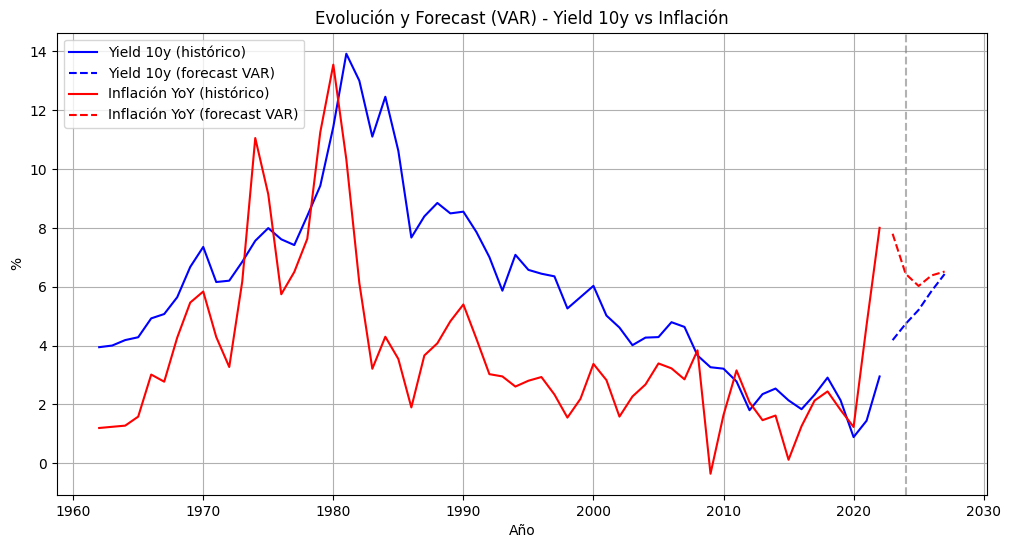

In [4]:
# Datos históricos
hist_years = df_clean["Year"]
hist_yield = df_clean["yield_10y"]
hist_infl = df_clean["inflation_yoy"]

# Forecast del VAR (lo que ya calculamos antes)
forecast_df.index.name = "Year"

# Unimos histórico + forecast
plt.figure(figsize=(12,6))

# Yield
plt.plot(hist_years, hist_yield, label="Yield 10y (histórico)", color="blue")
plt.plot(forecast_df.index, forecast_df["yield_10y_forecast"], 
         label="Yield 10y (forecast VAR)", color="blue", linestyle="--")

# Inflación
plt.plot(hist_years, hist_infl, label="Inflación YoY (histórico)", color="red")
plt.plot(forecast_df.index, forecast_df["inflation_forecast"], 
         label="Inflación YoY (forecast VAR)", color="red", linestyle="--")

plt.axvline(x=2024, color="gray", linestyle="--", alpha=0.6)  # separación entre histórico y forecast
plt.title("Evolución y Forecast (VAR) - Yield 10y vs Inflación")
plt.xlabel("Año")
plt.ylabel("%")
plt.legend()
plt.grid(True)
plt.show()

### Interpretación del primer gráfico (Histórico + Forecast VAR)

Lo que vemos en azul (Yield 10 años)

La línea azul continua: es la evolución histórica del rendimiento de los bonos del Tesoro a 10 años (yield).

La línea azul discontinua: es la predicción del modelo VAR para los próximos años.

Observamos que el yield tuvo picos muy altos en los 70–80 (crisis de inflación) y luego una tendencia descendente hasta mínimos recientes.

El forecast proyecta un ligero repunte del yield, lo que indica que los tipos de interés reales podrían subir en el futuro.

Lo que vemos en rojo (Inflación YoY)

La línea roja continua: es la inflación histórica. Destacan los picos en los años 70 (shocks petroleros) y el repunte fuerte en 2021–2022.

La línea roja discontinua: es la predicción del VAR. Muestra que la inflación podría bajar desde los picos recientes, pero aún mantenerse algo elevada comparada con los 2010s.

Interpretación conjunta

El modelo VAR nos dice que yield e inflación están claramente relacionadas en el tiempo: cuando sube la inflación, el yield tiende a subir después (los inversores exigen más rentabilidad para compensar la pérdida de poder adquisitivo).

La proyección indica un escenario de inflación todavía algo elevada con yields acompañando al alza → típico de un contexto post-crisis inflacionaria.

### En resumen:

El gráfico confirma la relación positiva entre inflación y yield.

El modelo espera que en los próximos años ambos suban moderadamente, no a niveles extremos como los 70, pero tampoco tan bajos como en los 2010s.

##  VAR completo: selección de rezagos + ajuste + forecast + IRF
 Requiere: statsmodels, pandas, matplotlib
 Usa df_clean con columnas: Year, yield_10y, inflation_yoy


--- Selección de rezagos ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       4.005       4.080       54.89       4.034
1      0.6423     0.8654*       1.901      0.7281
2      0.6911       1.063       1.998      0.8341
3     0.4176*      0.9381      1.523*     0.6177*
4      0.4835       1.153       1.633      0.7408
5      0.5133       1.331       1.691      0.8278
6      0.6139       1.580       1.886      0.9856
7      0.6737       1.789       2.025       1.103
8      0.7755       2.039       2.276       1.262
-------------------------------------------------

Lag elegido (AIC): 3

--- Resumen VAR ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:49
--------------------------------------------------------------------
No. of Equations:         2.00000

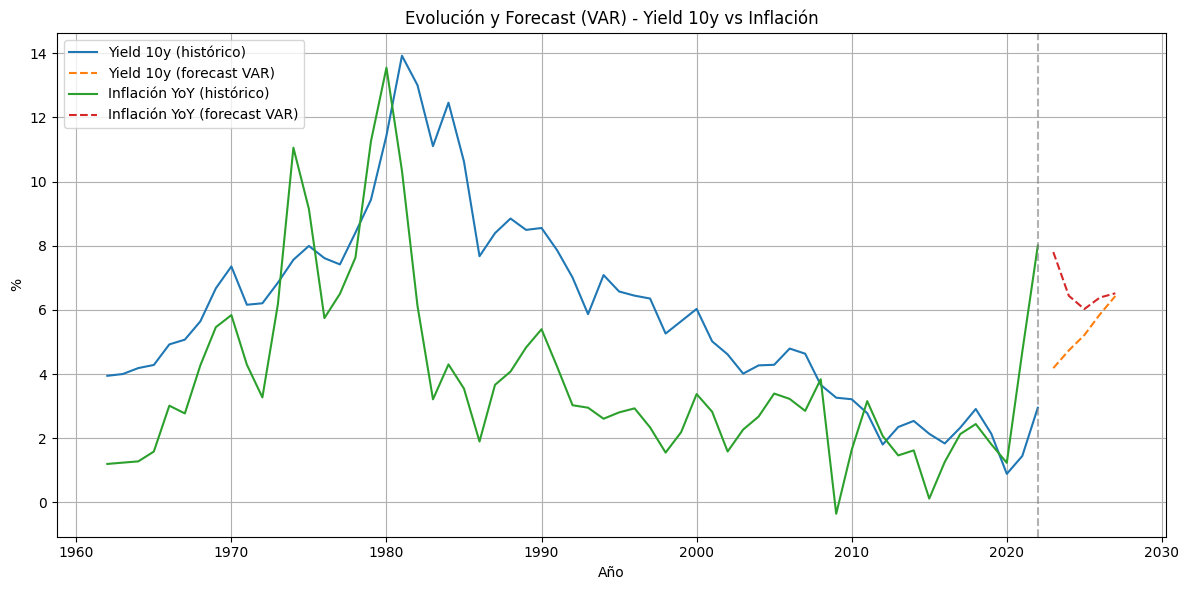

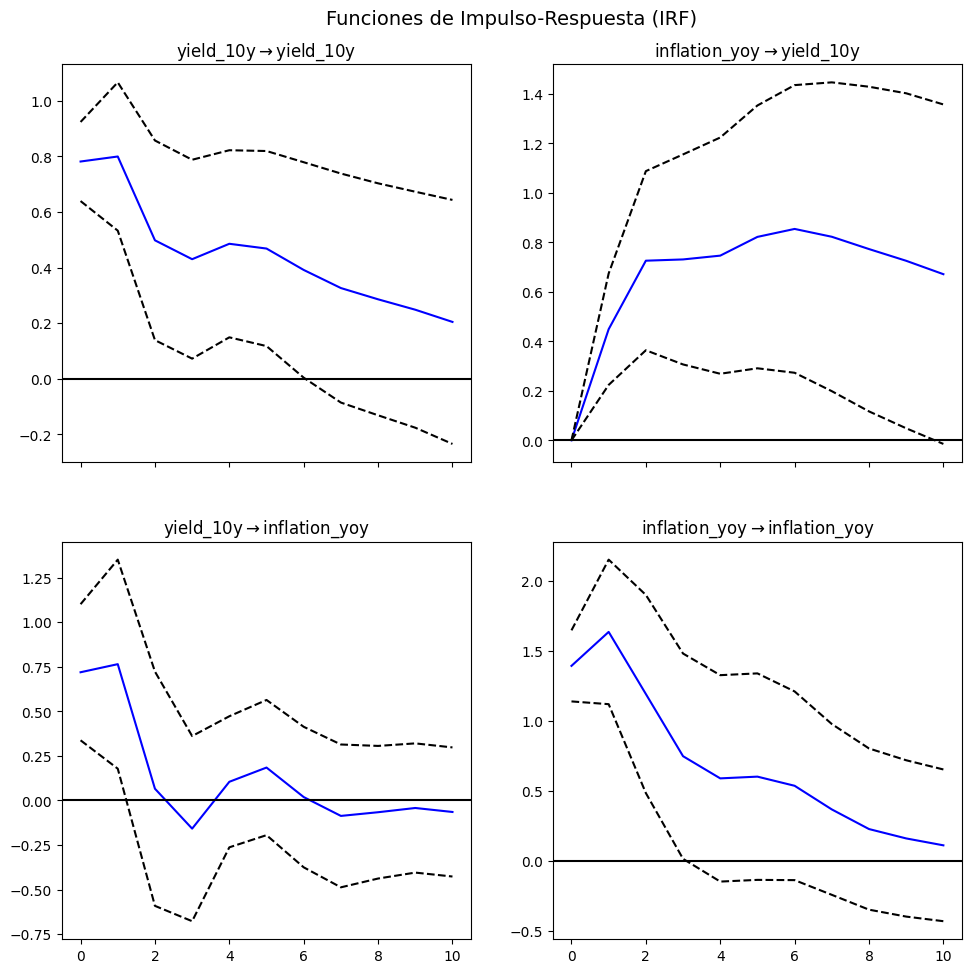

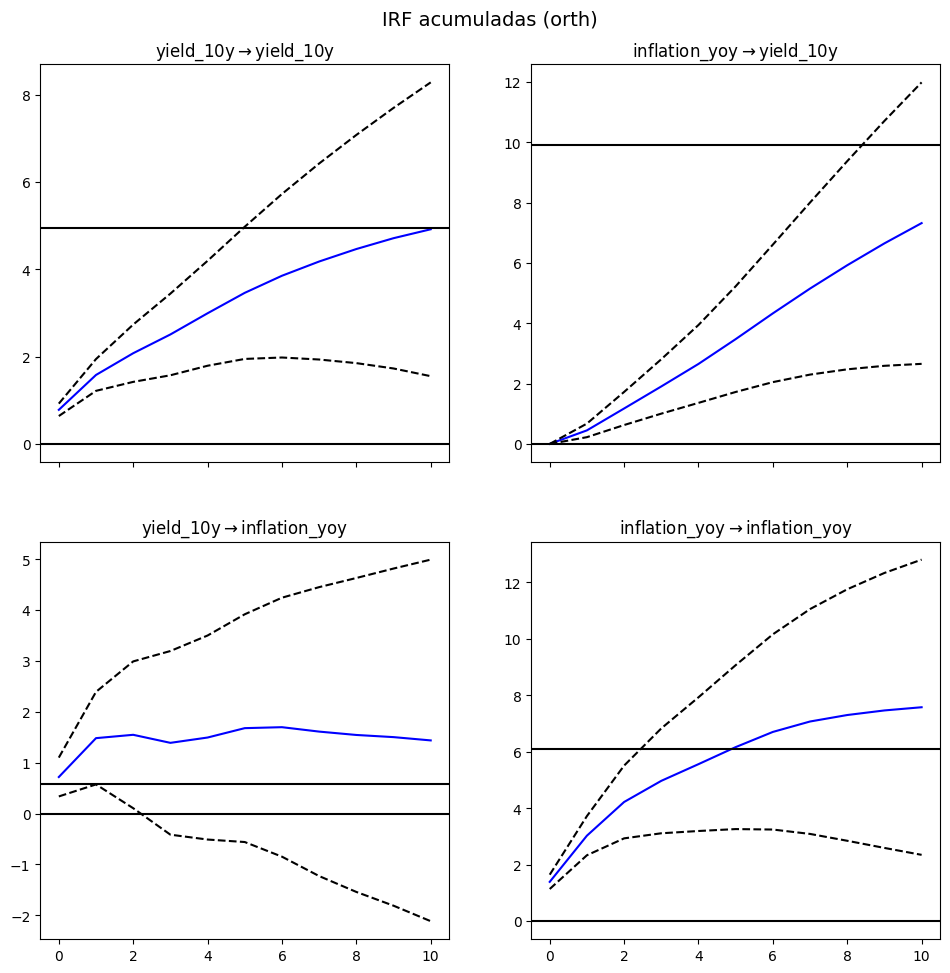

In [5]:
# 0) Preparar datos para VAR
df_var = df_clean[["yield_10y", "inflation_yoy"]].dropna().copy()

# 1) Selección de rezagos óptimos
model_var = VAR(df_var)
sel = model_var.select_order(maxlags=8)
print("\n--- Selección de rezagos ---")
print(sel.summary())

# Tomamos el lag con mejor AIC (puedes cambiar a .bic/.hqic/.fpe si prefieres)
best_lag = sel.aic
print(f"\nLag elegido (AIC): {best_lag}")

# 2) Ajuste del VAR con ese lag
var_res = model_var.fit(best_lag)
print("\n--- Resumen VAR ---")
print(var_res.summary())

# 3) Forecast 5 pasos hacia adelante
steps = 5
last_year = int(df_clean["Year"].max())
fcast = var_res.forecast(df_var.values[-best_lag:], steps=steps)
forecast_df = pd.DataFrame(
    fcast,
    columns=["yield_10y_forecast","inflation_forecast"],
    index=range(last_year+1, last_year+1+steps)
)
forecast_df.index.name = "Year"
print("\n--- Forecast ---")
print(forecast_df)

# 4) Gráfico histórico + forecast (opcional si ya lo tenías)
plt.figure(figsize=(12,6))
plt.plot(df_clean["Year"], df_clean["yield_10y"], label="Yield 10y (histórico)")
plt.plot(forecast_df.index, forecast_df["yield_10y_forecast"], "--", label="Yield 10y (forecast VAR)")
plt.plot(df_clean["Year"], df_clean["inflation_yoy"], label="Inflación YoY (histórico)")
plt.plot(forecast_df.index, forecast_df["inflation_forecast"], "--", label="Inflación YoY (forecast VAR)")
plt.axvline(x=last_year, color="gray", linestyle="--", alpha=0.6)
plt.title("Evolución y Forecast (VAR) - Yield 10y vs Inflación")
plt.xlabel("Año"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 5) IRF (Impulse Response Functions)
irf_h = 10  # horizonte en años
irf = var_res.irf(irf_h)

# IRF combinadas
fig = irf.plot(orth=True)
plt.suptitle("Funciones de Impulso-Respuesta (IRF)", fontsize=14)
plt.show()

# IRF específicas (opcional): respuesta de yield a shock de inflación, y viceversa
fig = irf.plot_cum_effects(orth=True)
plt.suptitle("IRF acumuladas (orth)", fontsize=14)
plt.show()

#### Los resultados del modelo VAR muestran que:

La inflación impulsa al rendimiento del bono a 10 años, confirmando que mayor inflación esperada eleva los tipos largos.

El efecto contrario (yields sobre inflación) existe pero es más débil y menos persistente.

Tanto la inflación como los yields presentan persistencia en sus shocks, manteniendo efectos durante varios periodos.

El pronóstico VAR anticipa un repunte moderado en ambas variables, con algo más de volatilidad en la inflación.

## Análisis VAR: Diagnóstico y Extensiones

In [6]:
# 1) Ljung–Box por variable (univariante)
for col in var_res.resid.columns:
    print(f"\nLjung–Box (lags=10) para {col}")
    print(acorr_ljungbox(var_res.resid[col].dropna(), lags=[10], return_df=True))



Ljung–Box (lags=10) para yield_10y
     lb_stat  lb_pvalue
10  6.156017   0.801989

Ljung–Box (lags=10) para inflation_yoy
     lb_stat  lb_pvalue
10  8.676622   0.563044


In [7]:
# 2) Durbin–Watson (otra medida de autocorrelación)
dw = durbin_watson(var_res.resid.values)
for col, val in zip(var_res.resid.columns, dw):
    print(f"Durbin–Watson {col}: {val:.2f}")  # ~2 es bueno (sin autocorrelación)


Durbin–Watson yield_10y: 1.81
Durbin–Watson inflation_yoy: 2.09


In [8]:
# 3) Estabilidad del VAR
var_res.is_stable(verbose=True)  # Debe devolver True / raíces dentro del círculo unitario

Eigenvalues of VAR(1) rep
0.5232513431366042
0.5232513431366042
0.6578636452036162
0.6578636452036162
0.8931126935415898
0.8931126935415898


np.True_

In [9]:
# 4) Heterocedasticidad (ARCH) por variable
for col in var_res.resid.columns:
    stat, pval, _, _ = het_arch(var_res.resid[col].dropna())
    print(f"ARCH para {col}: p-value = {pval:.4f}")  # >= 0.05 ⇒ OK

ARCH para yield_10y: p-value = 0.2394
ARCH para inflation_yoy: p-value = 0.8270


In [10]:
# 5) Normalidad conjunta de residuos
norm = var_res.test_normality()
print(norm.summary())  # p-value alto ⇒ OK

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         9.299          9.488   0.054  4
----------------------------------------


<Figure size 640x480 with 0 Axes>

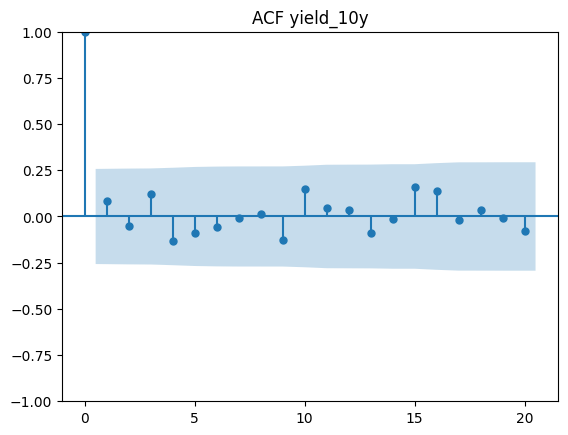

<Figure size 640x480 with 0 Axes>

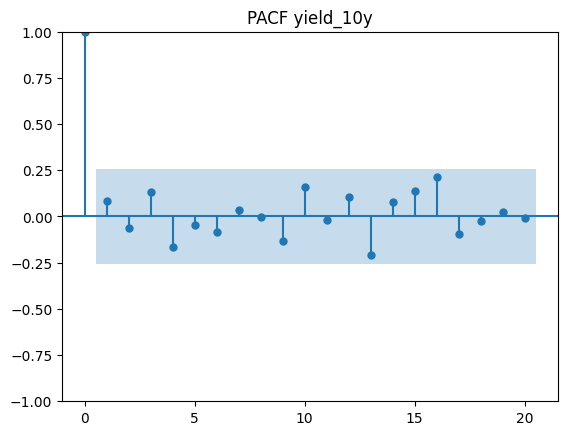

<Figure size 640x480 with 0 Axes>

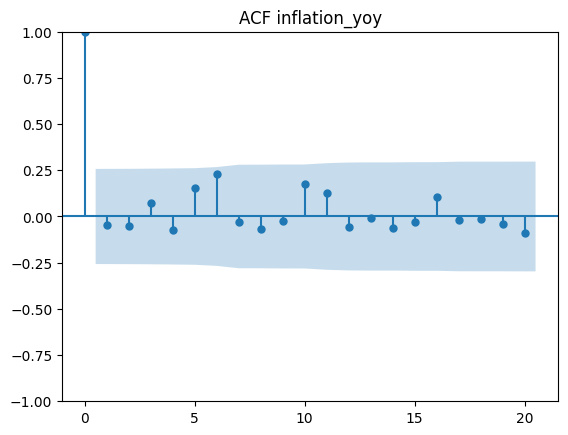

<Figure size 640x480 with 0 Axes>

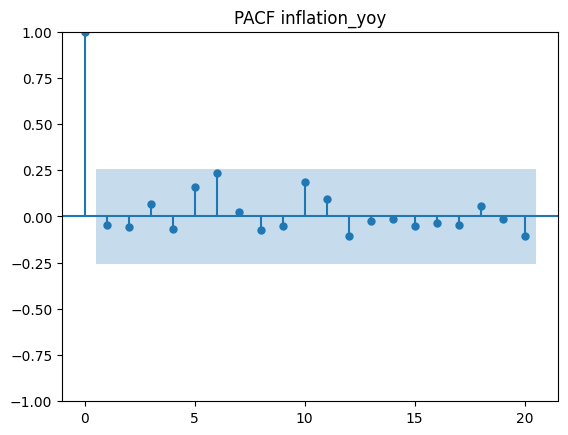

In [11]:
for col in var_res.resid.columns:
    plt.figure(); plot_acf(var_res.resid[col].dropna(), lags=20); plt.title(f"ACF {col}")
    plt.figure(); plot_pacf(var_res.resid[col].dropna(), lags=20); plt.title(f"PACF {col}")
    plt.show()

### Interpretación de los resultados (Punto 3.1)

En los gráficos de ACF y PACF:

La mayoría de las barras caen dentro de la banda azul (intervalo de confianza).

Eso significa que no hay autocorrelación significativa en los residuos.

Un modelo VAR bien especificado debe dejar los residuos como “ruido blanco”, y eso es lo que se ve aquí.

## 3.2 Test de autocorrelación alternativa (Durbin–Watson)

El estadístico Durbin–Watson verifica la autocorrelación de primer orden.  
- Valor cercano a **2** ⇒ sin autocorrelación.  
- Valor < 2 ⇒ autocorrelación positiva.  
- Valor > 2 ⇒ autocorrelación negativa.


In [12]:
dw = durbin_watson(var_res.resid.values)
for col, val in zip(var_res.resid.columns, dw):
    print(f"Durbin–Watson {col}: {val:.2f}")

Durbin–Watson yield_10y: 1.81
Durbin–Watson inflation_yoy: 2.09


## 3.3 Test de estabilidad del VAR

Un VAR estable tiene todas sus raíces dentro del círculo unitario.  
Si es **True**, los pronósticos son fiables.


In [13]:
var_res.is_stable(verbose=True)

Eigenvalues of VAR(1) rep
0.5232513431366042
0.5232513431366042
0.6578636452036162
0.6578636452036162
0.8931126935415898
0.8931126935415898


np.True_

## 3.4 Test de heterocedasticidad (ARCH)

El test ARCH evalúa si la varianza de los residuos es constante.  
- **p-value ≥ 0.05** ⇒ no hay heterocedasticidad (bien).  
- **p-value < 0.05** ⇒ problemas de heterocedasticidad.


In [14]:
for col in var_res.resid.columns:
    stat, pval, _, _ = het_arch(var_res.resid[col].dropna())
    print(f"ARCH {col}: p-value = {pval:.4f}")

ARCH yield_10y: p-value = 0.2394
ARCH inflation_yoy: p-value = 0.8270


## 3.5 Test de normalidad de residuos

El test de Jarque–Bera verifica si los residuos siguen una distribución normal.  
- **p-value ≥ 0.05** ⇒ no rechazamos normalidad (OK).  
- **p-value < 0.05** ⇒ residuos no normales.


In [15]:
norm = var_res.test_normality()
print(norm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         9.299          9.488   0.054  4
----------------------------------------


## 4. Pronóstico extendido con intervalos de confianza

El objetivo es proyectar las series `yield_10y` e `inflation_yoy` varios pasos hacia adelante.
Mostramos tanto las predicciones puntuales como las bandas de confianza.


In [16]:
# ==== 4. Pronóstico extendido con intervalos de confianza (VARResults) ====
steps = 10  # años a proyectar
last_year = int(df_clean["Year"].max())

# nº de rezagos que usó el VAR
k = var_res.k_ar

# Pronóstico: medias y bandas (lower/upper)
fcast_mean, fcast_lower, fcast_upper = var_res.forecast_interval(
    y=var_res.endog[-k:],  # las últimas k observaciones como estado inicial
    steps=steps,
    alpha=0.05             # 95% IC
)

cols = var_res.names  # ['yield_10y','inflation_yoy']

# DataFrames ordenados con índice de años futuros
idx_future = range(last_year+1, last_year+steps+1)
f_mean  = pd.DataFrame(fcast_mean,  index=idx_future, columns=cols)
f_lower = pd.DataFrame(fcast_lower, index=idx_future, columns=cols)
f_upper = pd.DataFrame(fcast_upper, index=idx_future, columns=cols)

print("\n--- Pronóstico extendido (medias) ---")
print(f_mean)


--- Pronóstico extendido (medias) ---
      yield_10y  inflation_yoy
2023   4.184766       7.801722
2024   4.737980       6.439943
2025   5.213127       6.026279
2026   5.858254       6.385621
2027   6.432582       6.517441
2028   6.803570       6.195852
2029   7.062704       5.840092
2030   7.290543       5.674328
2031   7.474132       5.566767
2032   7.588100       5.391901


## Gráfico histórico + forecast con bandas

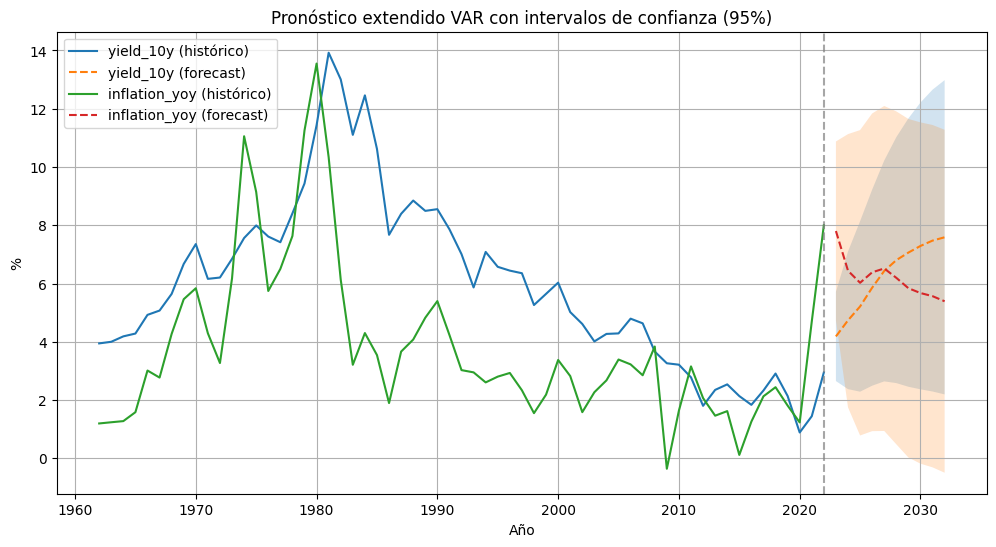

In [17]:
plt.figure(figsize=(12,6))

for col in cols:
    # histórico
    plt.plot(df_clean["Year"], df_clean[col], label=f"{col} (histórico)")
    # predicción
    plt.plot(f_mean.index, f_mean[col], linestyle="--", label=f"{col} (forecast)")
    # intervalos
    plt.fill_between(f_mean.index, f_lower[col], f_upper[col], alpha=0.2)

plt.axvline(x=last_year, color="gray", linestyle="--", alpha=0.7)
plt.title("Pronóstico extendido VAR con intervalos de confianza (95%)")
plt.xlabel("Año"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.show()


### Interpretación rápida:

Se observa que el yield_10y tendería a estabilizarse, mientras que la inflación muestra un ligero descenso en el forecast, aunque con bastante incertidumbre (bandas amplias).

Esto refleja la lógica: el modelo VAR capta relaciones, pero a largo plazo las predicciones son menos seguras.

## 5. Descomposición de varianza del error de pronóstico (FEVD)

Mide qué porcentaje del error de predicción de cada variable se explica por shocks propios y por la otra variable, a distintos horizontes.


FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.860953       0.139047
2     0.672574       0.327426
3     0.571081       0.428919
4     0.513006       0.486994
5     0.461214       0.538786
6     0.415154       0.584846
7     0.380437       0.619563
8     0.355117       0.644883
9     0.335671       0.664329

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.210270       0.789730
1     0.192578       0.807422
2     0.154725       0.845275
3     0.146232       0.853768
4     0.141077       0.858923
5     0.138470       0.861530
6     0.133939       0.866061
7     0.132624       0.867376
8     0.132270       0.867730
9     0.132055       0.867945


None


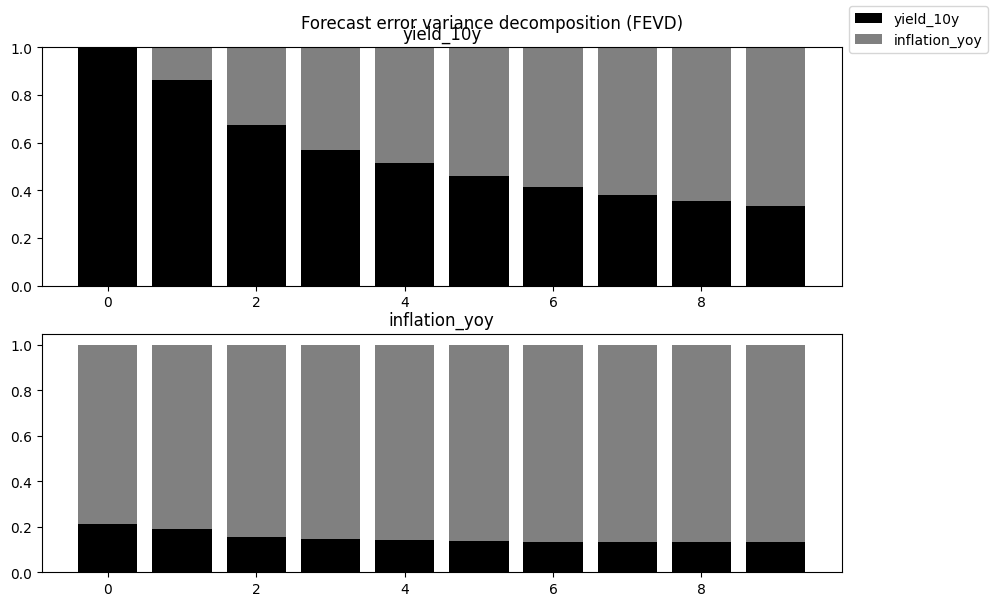

In [18]:
steps = 10  # horizonte FEVD
fevd = var_res.fevd(steps)

# Resumen en texto
print(fevd.summary())

# Gráfico por variable
_ = fevd.plot(figsize=(10,6))


## 6. Causalidad de Granger

Contrasta si los rezagos de una variable ayudan a predecir a la otra (más allá de sus propios rezagos).
- p-value < 0.05 ⇒ Rechazamos “no causa” ⇒ hay causalidad de Granger en esa dirección.


In [19]:
# ¿Inflation_yoy causa (Granger) a yield_10y?
print(var_res.test_causality('yield_10y', ['inflation_yoy'], kind='f').summary())

# ¿Yield_10y causa (Granger) a inflation_yoy?
print(var_res.test_causality('inflation_yoy', ['yield_10y'], kind='f').summary())


Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value         df        
--------------------------------------------------------
         8.316          2.694   0.000 (3, np.int64(102))
--------------------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df        
--------------------------------------------------------
         1.451          2.694   0.232 (3, np.int64(102))
--------------------------------------------------------


## 7. Funciones de Impulso-Respuesta (IRF)

#### 7.1 IRF ortogonalizadas (Cholesky) con bandas de confianza

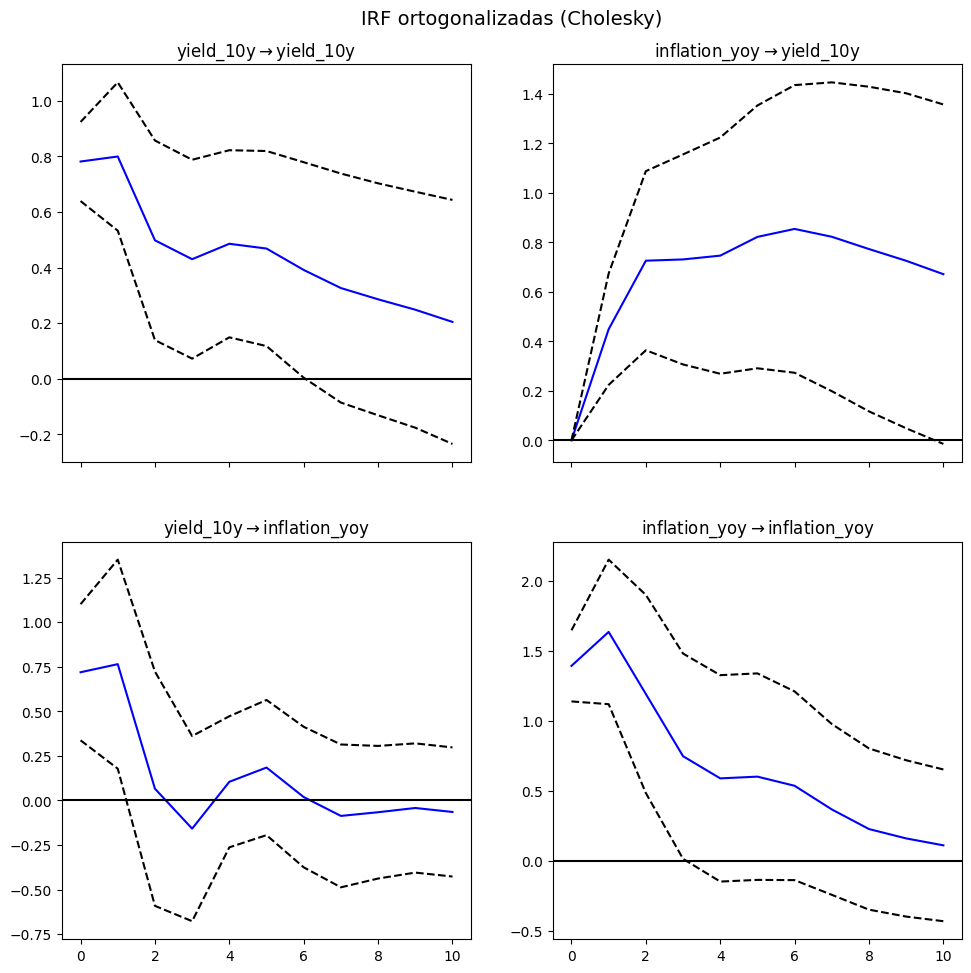

In [20]:
# Horizonte (años)
h = 10

# IRF básicas
irf = var_res.irf(h)

# Gráfico de IRF ortogonalizadas (Cholesky)
fig = irf.plot(orth=True)
fig.suptitle("IRF ortogonalizadas (Cholesky)", fontsize=14)

# Bandas de confianza por bootstrap Monte Carlo
# (repl=1000 si quieres más precisión; tardará más)
fig_ci = irf.errband_mc(orth=True, repl=500)  # devuelve fig y ejes con bandas


## 7.2 IRF acumuladas (efecto total a lo largo del horizonte)

Text(0.5, 0.98, 'IRF acumuladas (orth)')

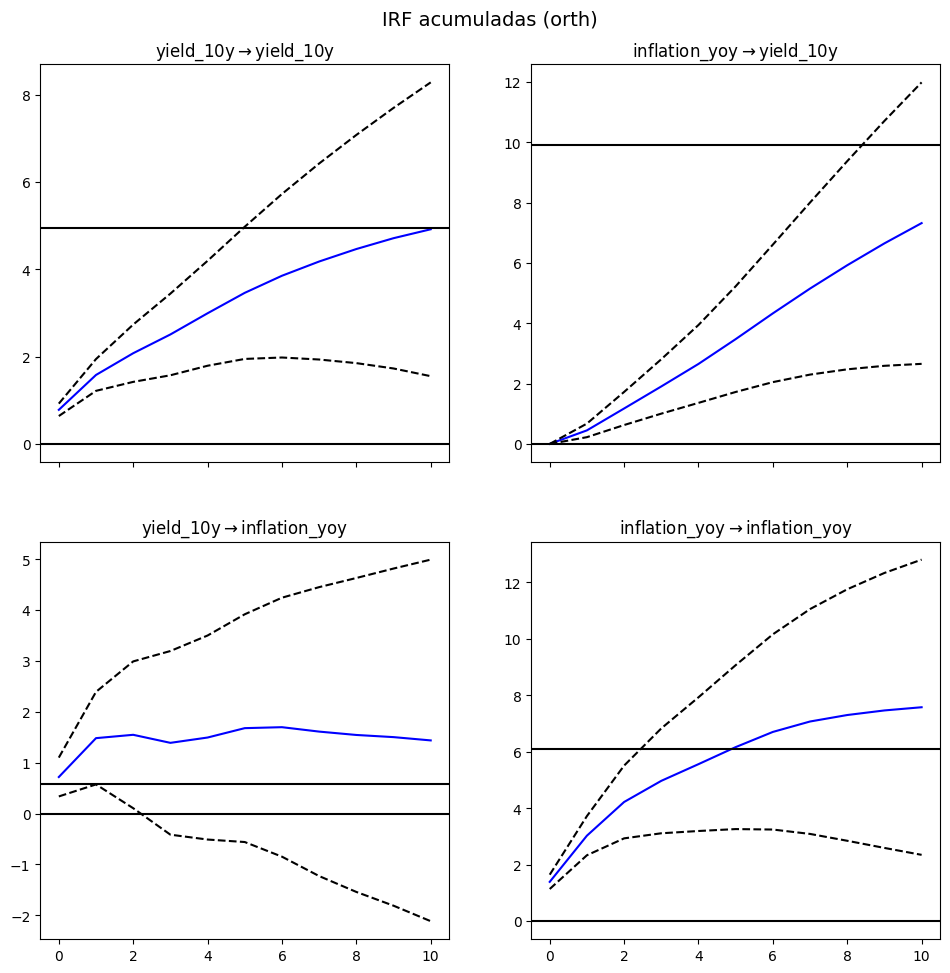

In [21]:
fig_cum = irf.plot_cum_effects(orth=True)
fig_cum.suptitle("IRF acumuladas (orth)", fontsize=14)


## 7.3 Sensibilidad al orden de las variables
Cambiar el orden es buena práctica de robustez: primero inflación, luego yield.

Text(0.5, 0.98, 'IRF orth con orden alternativo (inflación primero)')

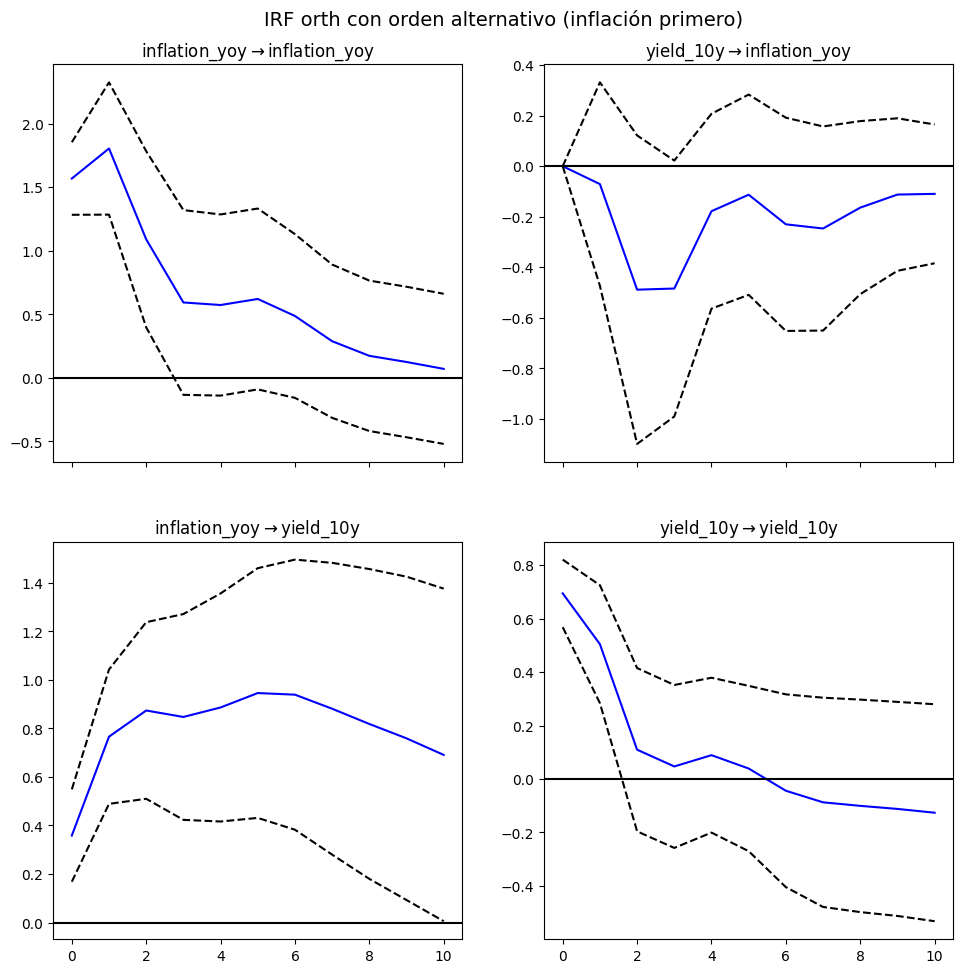

In [22]:
# Re-ajustamos el VAR con columnas reordenadas
df_alt = df_clean[["inflation_yoy", "yield_10y"]].dropna().copy()
model_alt = VAR(df_alt)
var_res_alt = model_alt.fit(var_res.k_ar)  # usa el mismo nº de rezagos

irf_alt = var_res_alt.irf(h)
fig_alt = irf_alt.plot(orth=True)
fig_alt.suptitle("IRF orth con orden alternativo (inflación primero)", fontsize=14)


## 7.4 Guardar figuras a disco

In [23]:
fig.savefig("reports/figures/irf_orth.png", dpi=150, bbox_inches="tight")
fig_cum.savefig("reports/figures/irf_cum_orth.png", dpi=150, bbox_inches="tight")
fig_alt.savefig("reports/figures/irf_orth_alt_order.png", dpi=150, bbox_inches="tight")


###  Interpretación Punto 7 (IRFs)

Shock inflación → Yield 10Y: impacto fuerte y sostenido, los bonos suben porque el mercado exige más rentabilidad.

Shock Yield 10Y → Inflación: efecto débil y pasajero, incluso negativo (tipos altos enfrían la economía).

Inflación sobre sí misma: persistente, pero va perdiendo fuerza.

Yield sobre sí mismo: se corrige rápido.

IRFs acumuladas: confirman que la inflación arrastra a los yields, no al revés.

Sensibilidad al orden: los resultados son robustos, no dependen del orden de variables.

📌 Conclusión clara:
La inflación lidera y los yields siguen.

## Preparar el dataset USA para el pipeline


In [24]:
df_usa = (
    df_clean[['Year', 'yield_10y', 'inflation_yoy']]
      .dropna()
      .copy()
)

df_usa['Year'] = df_usa['Year'].astype(int)
df_usa = df_usa.set_index('Year').sort_index()

## Define el pipeline (elige rezagos automáticamente)

In [25]:
def run_country_pipeline_auto(df, country_name, steps=10, maxlags=8, crit="aic"):
    """
    Pipeline VAR completo con selección automática de rezagos.
    df: DataFrame con index=Year y columnas ['yield_10y','inflation_yoy']
    steps: horizonte de forecast
    maxlags: rezago máximo a evaluar
    crit: 'aic' | 'bic' | 'hqic' | 'fpe'
    """
    df = df[['yield_10y','inflation_yoy']].dropna().copy()
    model = VAR(df)

    # 1) Selección de rezagos
    sel = model.select_order(maxlags=maxlags)
    best_lag = getattr(sel, crit)
    print(f"\n[{country_name}] Rezagos óptimos por {crit.upper()}: {best_lag}")

    # 2) Ajuste
    res = model.fit(best_lag)
    print(res.summary())

    # 3) Diagnóstico (rápido)
    print("\n--- Diagnóstico ---")
    for col in res.resid.columns:
        lb = acorr_ljungbox(res.resid[col].dropna(), lags=[10], return_df=True)
        print(f"Ljung-Box {col} (lag=10): p-value={lb['lb_pvalue'].iloc[0]:.4f}")
    dw = durbin_watson(res.resid.values)
    for c,v in zip(res.resid.columns, dw):
        print(f"Durbin–Watson {c}: {v:.2f}")
    print("Estabilidad:", res.is_stable(verbose=True))

    # 4) Forecast con bandas
    k = res.k_ar
    mean, low, up = res.forecast_interval(res.endog[-k:], steps=steps, alpha=0.05)
    idx_future = range(df.index.max()+1, df.index.max()+1+steps)
    f_mean = pd.DataFrame(mean, index=idx_future, columns=res.names)
    f_low  = pd.DataFrame(low,  index=idx_future, columns=res.names)
    f_up   = pd.DataFrame(up,   index=idx_future, columns=res.names)

    plt.figure(figsize=(11,5))
    for col in res.names:
        plt.plot(df.index, df[col], label=f"{col} (hist.)")
        plt.plot(f_mean.index, f_mean[col], "--", label=f"{col} (fcst)")
        plt.fill_between(f_mean.index, f_low[col], f_up[col], alpha=0.2)
    plt.axvline(df.index.max(), color="gray", linestyle="--", alpha=0.7)
    plt.title(f"{country_name} – Forecast VAR (95% IC)")
    plt.xlabel("Año"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.show()

    # 5) FEVD
    fevd = res.fevd(steps)
    print("\n--- FEVD ---")
    print(fevd.summary())
    fevd.plot(figsize=(9,5)); plt.show()

    # 6) Granger
    print("\n--- Granger ---")
    print(res.test_causality('yield_10y',['inflation_yoy'], kind='f').summary())
    print(res.test_causality('inflation_yoy',['yield_10y'], kind='f').summary())

    # 7) IRFs (orth y acumuladas)
    irf = res.irf(steps)
    irf.plot(orth=True); plt.suptitle(f"{country_name} – IRF orth"); plt.show()
    irf.plot_cum_effects(orth=True); plt.suptitle(f"{country_name} – IRF acumuladas"); plt.show()

    return res, {"forecast_mean": f_mean, "forecast_low": f_low, "forecast_up": f_up}, fevd, irf, best_lag


## Ejecutar el pipeline para USA


[USA] Rezagos óptimos por AIC: 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.893584
Nobs:                     58.0000    HQIC:                  0.589963
Log likelihood:          -162.088    FPE:                    1.48974
AIC:                     0.396236    Det(Omega_mle):         1.18615
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.096240         0.256867           -0.375           0.708
L1.yield_10y             0.726405         0.147355            4.930           0.000
L1.inflati

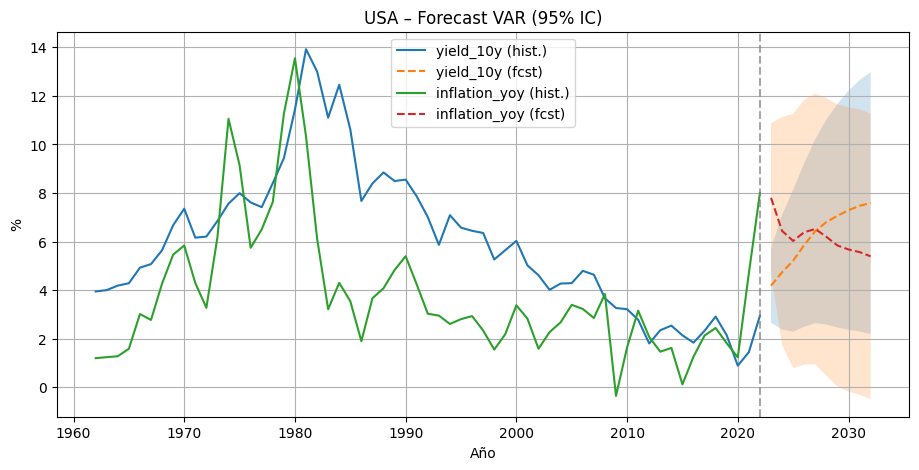


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.860953       0.139047
2     0.672574       0.327426
3     0.571081       0.428919
4     0.513006       0.486994
5     0.461214       0.538786
6     0.415154       0.584846
7     0.380437       0.619563
8     0.355117       0.644883
9     0.335671       0.664329

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.210270       0.789730
1     0.192578       0.807422
2     0.154725       0.845275
3     0.146232       0.853768
4     0.141077       0.858923
5     0.138470       0.861530
6     0.133939       0.866061
7     0.132624       0.867376
8     0.132270       0.867730
9     0.132055       0.867945


None


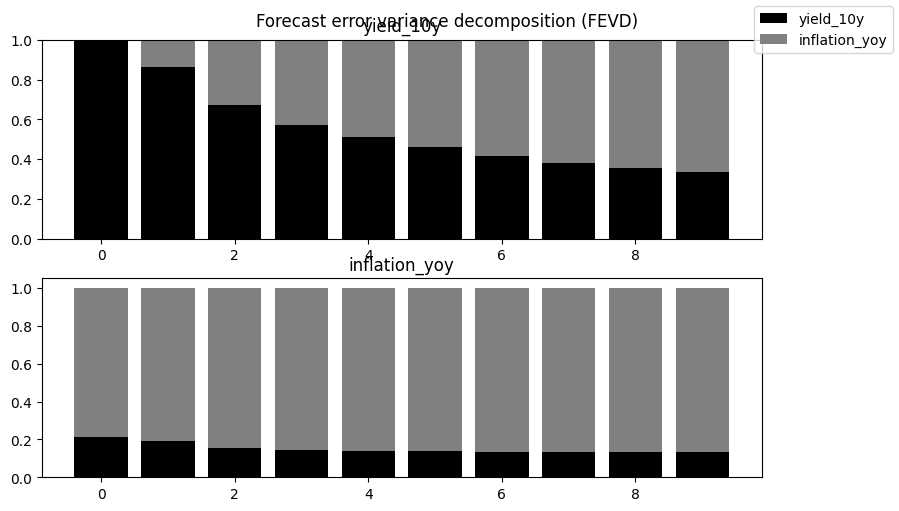


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value         df        
--------------------------------------------------------
         8.316          2.694   0.000 (3, np.int64(102))
--------------------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df        
--------------------------------------------------------
         1.451          2.694   0.232 (3, np.int64(102))
--------------------------------------------------------


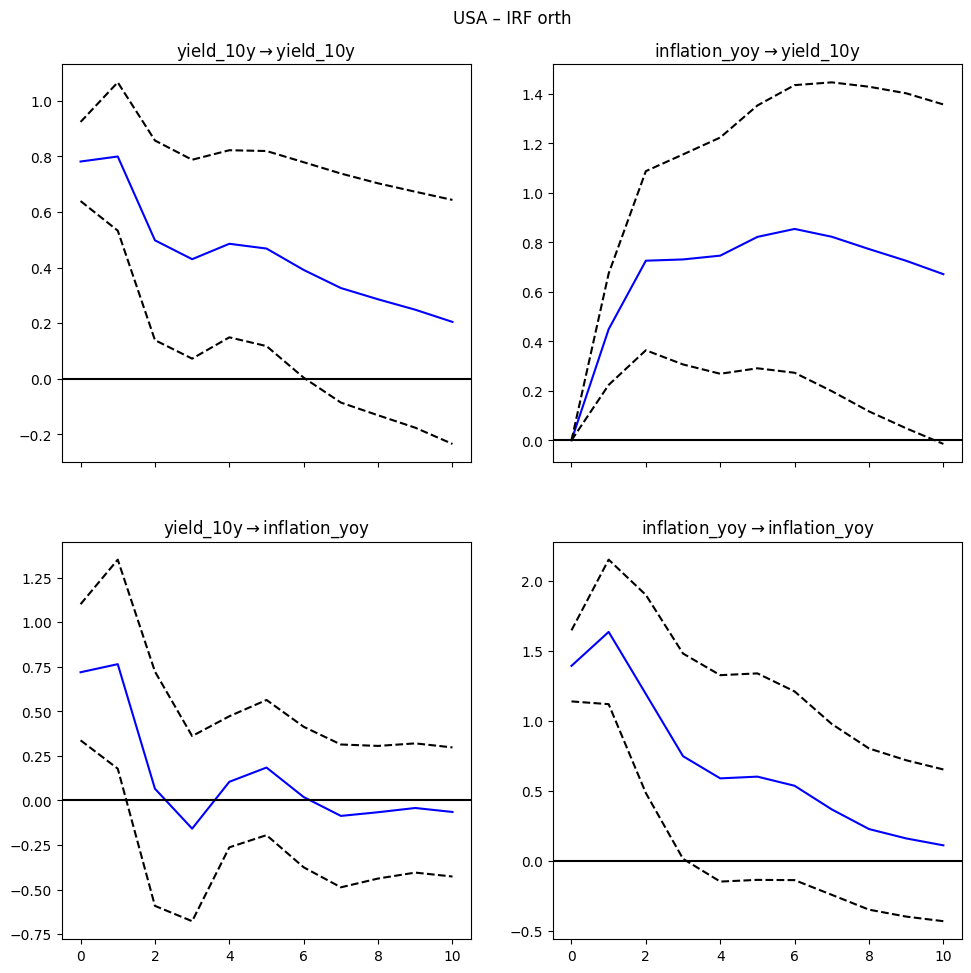

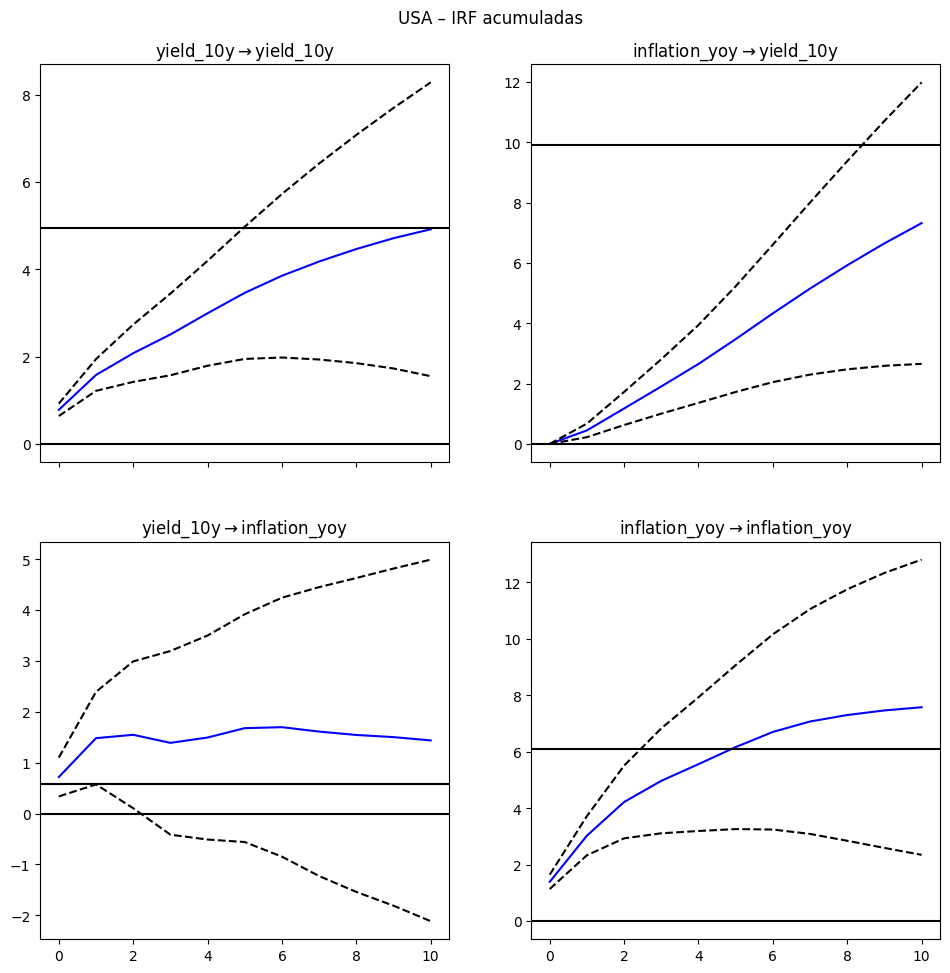

Lag elegido (AIC): 3


In [26]:
usa_results, usa_fcst, usa_fevd, usa_irf, usa_bestlag = run_country_pipeline_auto(
    df_usa, country_name="USA", steps=10, maxlags=8, crit="aic"
)
print("Lag elegido (AIC):", usa_bestlag)


## Detectar la columna 10Y de Alemania en yields.csv

In [27]:
# Cargar si no esta ya en memoria:
yields = pd.read_csv("data/raw_data/yields.csv")

# columnas 10Y tipo 'US10', 'DE10', etc.
ten_cols = [c for c in yields.columns if re.fullmatch(r"[A-Z]{2}\d{2}", c) and c.endswith("10")]
print("10Y detectadas (primeras 30):", ten_cols[:30])

# Intento automático para Alemania
candidatos_de = [c for c in ten_cols if c.startswith(("DE","GE","BD","GM"))]
print("Candidatos Alemania:", candidatos_de)

# Si aparece 'DE10', úsala; si no, toma el primer candidato que salga.
col_de = "DE10" if "DE10" in ten_cols else (candidatos_de[0] if candidatos_de else None)
print("Columna usada para Alemania 10Y:", col_de)


10Y detectadas (primeras 30): ['AU10', 'BE10', 'CA10', 'CN10', 'DK10', 'FR10', 'DE10', 'GR10', 'HK10', 'IN10', 'ID10', 'IE10', 'IT10', 'JP10', 'KR10', 'MY10', 'NL10', 'NZ10', 'NO10', 'PL10', 'PT10', 'SG10', 'ZA10', 'ES10', 'SE10', 'TW10', 'TH10', 'TR10', 'GB10', 'US10']
Candidatos Alemania: ['DE10']
Columna usada para Alemania 10Y: DE10


## Anualizar yields USA + Alemania

In [28]:
yields_yr = yields.copy()
yields_yr['Year'] = pd.to_datetime(yields_yr['time'], unit='ms').dt.year

col_us = "US10"   # USA 10Y
col_de = "DE10"   # Alemania 10Y

y_ann = (
    yields_yr[['Year', col_us, col_de]]
      .groupby('Year', as_index=False)
      .mean()
      .rename(columns={col_us:'yield_10y_US', col_de:'yield_10y_DE'})
)


## Inflación del Banco Mundial (USA + Alemania)

In [29]:
wb = pd.read_csv('data/raw_data/world_bank_data_2025.csv')

wb_small = wb.rename(columns={
    'country_name':'Country',
    'year':'Year',
    'Inflation (CPI %)':'inflation_yoy'
})[['Country','Year','inflation_yoy']].dropna()

infl_us = wb_small.query("Country == 'United States'")[['Year','inflation_yoy']].rename(columns={'inflation_yoy':'inflation_yoy_US'})
infl_de = wb_small.query("Country == 'Germany'")[['Year','inflation_yoy']].rename(columns={'inflation_yoy':'inflation_yoy_DE'})


## Construir datasets y lanzar el pipeline

### Carga el CSV de Alemania

In [30]:
# === 1) Cargar CSV Alemania desde FRED ===
de_raw = pd.read_csv('data/raw_data/IRLTLT01DEM156N.csv')

# Normalizar columnas
de_raw['observation_date'] = pd.to_datetime(de_raw['observation_date'], errors='coerce')
de_raw = de_raw.rename(columns={'IRLTLT01DEM156N':'yield_10y'})

# === 2) Pasar de mensual → anual (promedio) ===
de_annual = de_raw.set_index('observation_date').resample('YE').mean()
de_annual.index = de_annual.index.year
de_annual.index.name = 'Year'
de_annual = de_annual.reset_index()

print("Alemania yields anuales:", de_annual['Year'].min(), "→", de_annual['Year'].max())
display(de_annual.head())

# === 3) Inflación Alemania desde World Bank ===
wb_small = wb.rename(columns={
    'country_name':'Country',
    'year':'Year',
    'Inflation (CPI %)':'inflation_yoy'
})[['Country','Year','inflation_yoy']].dropna()

infl_de = wb_small.query("Country == 'Germany'")[['Year','inflation_yoy']]

# === 4) Merge yields + inflación ===
df_germany = (
    de_annual.merge(infl_de, on='Year', how='inner')
             .set_index('Year').sort_index()
)

print("Alemania combinado:", df_germany.index.min(), "→", df_germany.index.max())
display(df_germany.tail())


Alemania yields anuales: 1956 → 2025


,Year,yield_10y
0,1956,6.912500
1,1957,7.516667
2,1958,6.783333
3,1959,5.766667
4,1960,6.425000


Alemania combinado: 2010 → 2024


,yield_10y,inflation_yoy
Year,,
2020,-0.511024,0.144878
2021,-0.373821,3.066667
2022,1.142583,6.872574
2023,2.434599,5.946437
2024,2.321084,2.256498


## Alemania: cortar a 2010–2024 y correr el

[Germany] N=15 | maxlags sugerido=3

[Germany (2010–2024)] Rezagos óptimos por AIC: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.618713
Nobs:                     14.0000    HQIC:                 -0.917947
Log likelihood:          -27.4821    FPE:                   0.415156
AIC:                    -0.892594    Det(Omega_mle):        0.281559
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.166027         0.219234           -0.757           0.449
L1.yield_10y             0.612594         

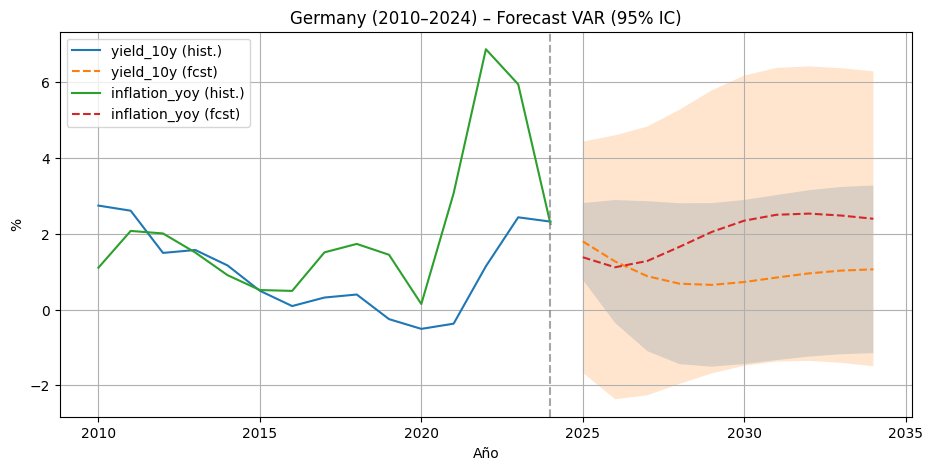


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.910424       0.089576
2     0.836596       0.163404
3     0.791540       0.208460
4     0.772434       0.227566
5     0.770204       0.229796
6     0.772758       0.227242
7     0.773377       0.226623
8     0.771993       0.228007
9     0.770538       0.229462

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.563252       0.436748
1     0.502239       0.497761
2     0.485512       0.514488
3     0.505551       0.494449
4     0.527701       0.472299
5     0.536082       0.463918
6     0.535563       0.464437
7     0.533641       0.466359
8     0.533380       0.466620
9     0.534259       0.465741


None


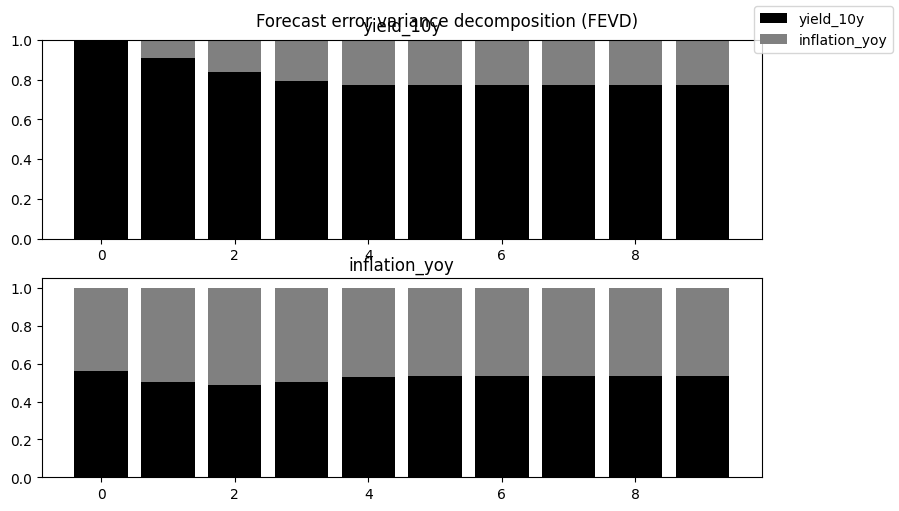


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value         df       
-------------------------------------------------------
         9.983          4.301   0.005 (1, np.int64(22))
-------------------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df       
-------------------------------------------------------
         2.602          4.301   0.121 (1, np.int64(22))
-------------------------------------------------------


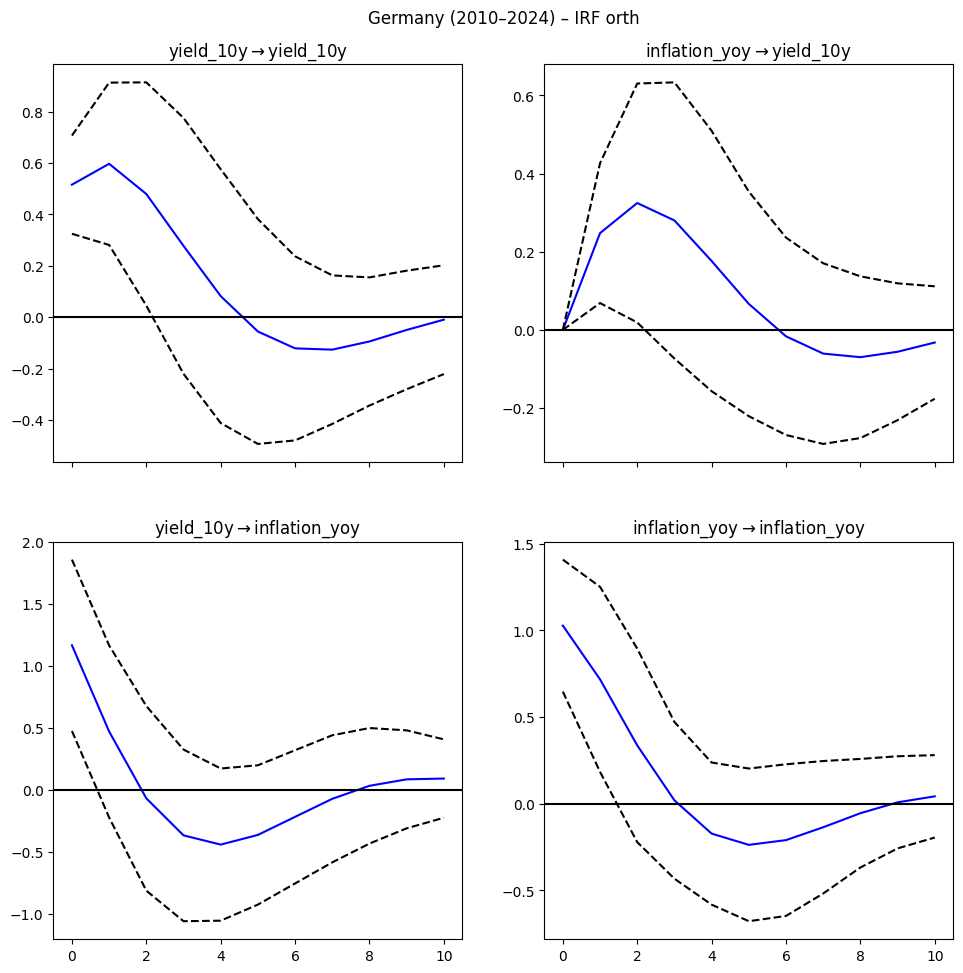

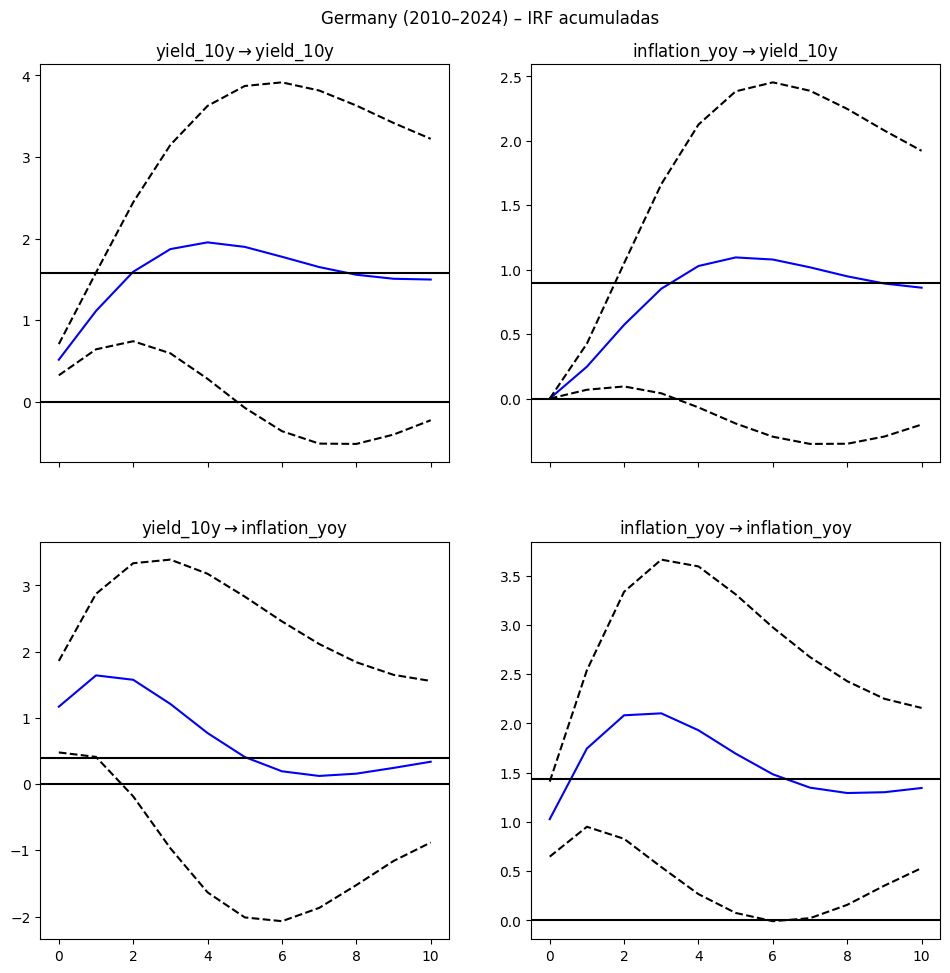

Germany (2010–2024) – lag elegido: 1


In [31]:
# --- Alemania 2010–2024 ---
df_germany_2010_24 = df_germany.loc[2010:2024].copy()

N = len(df_germany_2010_24)
safe_maxlags = max(1, min(3, (N - 3)//2))   # con ~15 años suele salir 1–2
print(f"[Germany] N={N} | maxlags sugerido={safe_maxlags}")

de_res, de_fcst, de_fevd, de_irf, de_bestlag = run_country_pipeline_auto(
    df_germany_2010_24, country_name="Germany (2010–2024)",
    steps=10, maxlags=safe_maxlags, crit="aic"
)
print("Germany (2010–2024) – lag elegido:", de_bestlag)


## USA: mismo corte 2010–2024

In [32]:

def run_country_pipeline_auto(df, country_name, steps=5, maxlags=2, crit="aic"):
    """
    df: index=Year (int), columnas ['yield_10y','inflation_yoy']
    steps: horizonte de forecast
    maxlags: rezago máximo permitido (luego se capea automáticamente)
    """
    # 0) Formato y limpieza
    df = df[['yield_10y','inflation_yoy']].dropna().copy()
    df.index = df.index.astype(int)
    df = df.sort_index()

    # 1) Cálculo de un maxlags seguro según nº de observaciones
    N = len(df)
    k_endog = df.shape[1]  # 2
    safe_max = max(1, min(maxlags, (N - 5)//k_endog))  # cap defensivo
    if safe_max < 1:
        raise ValueError(f"Datos insuficientes (N={N}). Reduce rango de años o añade datos.")
    if safe_max < maxlags:
        print(f"[{country_name}] maxlags reducido de {maxlags} a {safe_max} por N={N}")

    # 2) Selección de rezagos y ajuste
    model = VAR(df)
    sel = model.select_order(maxlags=safe_max)
    best_lag = getattr(sel, crit)
    if best_lag is None or best_lag < 1:
        best_lag = min(1, safe_max)
    print(f"\n[{country_name}] Rezagos óptimos por {crit.upper()}: {best_lag}")
    res = model.fit(best_lag)
    print(res.summary())

    # 3) Diagnóstico robusto (Ljung–Box con lag seguro)
    print("\n--- Diagnóstico ---")
    nres = len(res.resid)
    lb_lag = max(1, min(10, nres - 2, 2*best_lag))  # evita el error por tamaños
    for col in res.resid.columns:
        if lb_lag >= 1:
            lb = acorr_ljungbox(res.resid[col].dropna(), lags=[lb_lag], return_df=True)
            print(f"Ljung-Box {col} (lag={lb_lag}): p={lb['lb_pvalue'].iloc[0]:.4f}")
        else:
            print(f"Ljung-Box {col}: saltado (muy pocas observaciones)")
    dw = durbin_watson(res.resid.values)
    for c, v in zip(res.resid.columns, dw):
        print(f"Durbin–Watson {c}: {v:.2f}")
    print("Estabilidad:", res.is_stable(verbose=True))

    # 4) Forecast con bandas (95%)
    k = res.k_ar
    mean, low, up = res.forecast_interval(res.endog[-k:], steps=steps, alpha=0.05)
    idx_future = range(df.index.max()+1, df.index.max()+1+steps)
    f_mean = pd.DataFrame(mean, index=idx_future, columns=res.names)
    f_low  = pd.DataFrame(low,  index=idx_future, columns=res.names)
    f_up   = pd.DataFrame(up,   index=idx_future, columns=res.names)

    plt.figure(figsize=(11,5))
    for col in res.names:
        plt.plot(df.index, df[col], label=f"{col} (hist.)")
        plt.plot(f_mean.index, f_mean[col], "--", label=f"{col} (fcst)")
        plt.fill_between(f_mean.index, f_low[col], f_up[col], alpha=0.2)
    plt.axvline(df.index.max(), color="gray", linestyle="--", alpha=0.7)
    plt.title(f"{country_name} – Forecast VAR (95% IC)")
    plt.xlabel("Año"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.show()

    # 5) FEVD
    fevd = res.fevd(steps)
    print("\n--- FEVD ---")
    print(fevd.summary())
    fevd.plot(figsize=(9,5)); plt.show()

    # 6) Causalidad de Granger
    print("\n--- Granger ---")
    print(res.test_causality('yield_10y', ['inflation_yoy'], kind='f').summary())
    print(res.test_causality('inflation_yoy', ['yield_10y'], kind='f').summary())

    # 7) IRFs (orth y acumuladas)
    irf = res.irf(steps)
    irf.plot(orth=True); plt.suptitle(f"{country_name} – IRF orth"); plt.show()
    irf.plot_cum_effects(orth=True); plt.suptitle(f"{country_name} – IRF acumuladas"); plt.show()

    return res, {"forecast_mean": f_mean, "forecast_low": f_low, "forecast_up": f_up}, fevd, irf, best_lag


In [33]:
df_usa_2010_24     = df_usa.loc[2010:2024].copy()
df_germany_2010_24 = df_germany.loc[2010:2024].copy()

print("USA 2010–2024:", df_usa_2010_24.index.min(), "→", df_usa_2010_24.index.max(), "| N=", len(df_usa_2010_24))
print("DE  2010–2024:", df_germany_2010_24.index.min(), "→", df_germany_2010_24.index.max(), "| N=", len(df_germany_2010_24))


USA 2010–2024: 2010 → 2022 | N= 13
DE  2010–2024: 2010 → 2024 | N= 15



[USA (2010–2024)] Rezagos óptimos por AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.878916
Nobs:                     11.0000    HQIC:                  -1.46865
Log likelihood:          -14.3931    FPE:                   0.333817
AIC:                     -1.24064    Det(Omega_mle):        0.157781
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    2.996691         0.820944            3.650           0.000
L1.yield_10y             0.380733         0.296424            1.284           0.19

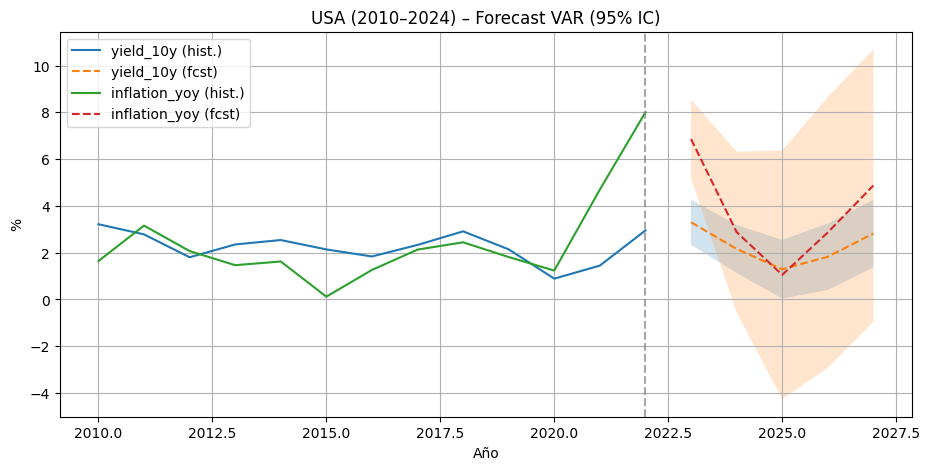


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.994611       0.005389
2     0.992842       0.007158
3     0.994395       0.005605
4     0.992982       0.007018

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.121961       0.878039
1     0.563654       0.436346
2     0.774076       0.225924
3     0.801457       0.198543
4     0.803017       0.196983


None


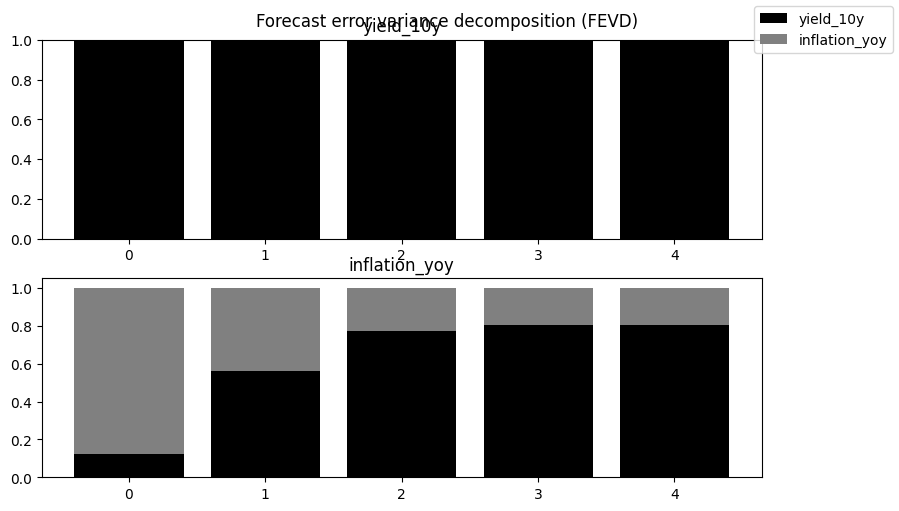


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df       
-------------------------------------------------------
       0.05184          3.885   0.950 (2, np.int64(12))
-------------------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value         df       
-------------------------------------------------------
         13.48          3.885   0.001 (2, np.int64(12))
-------------------------------------------------------


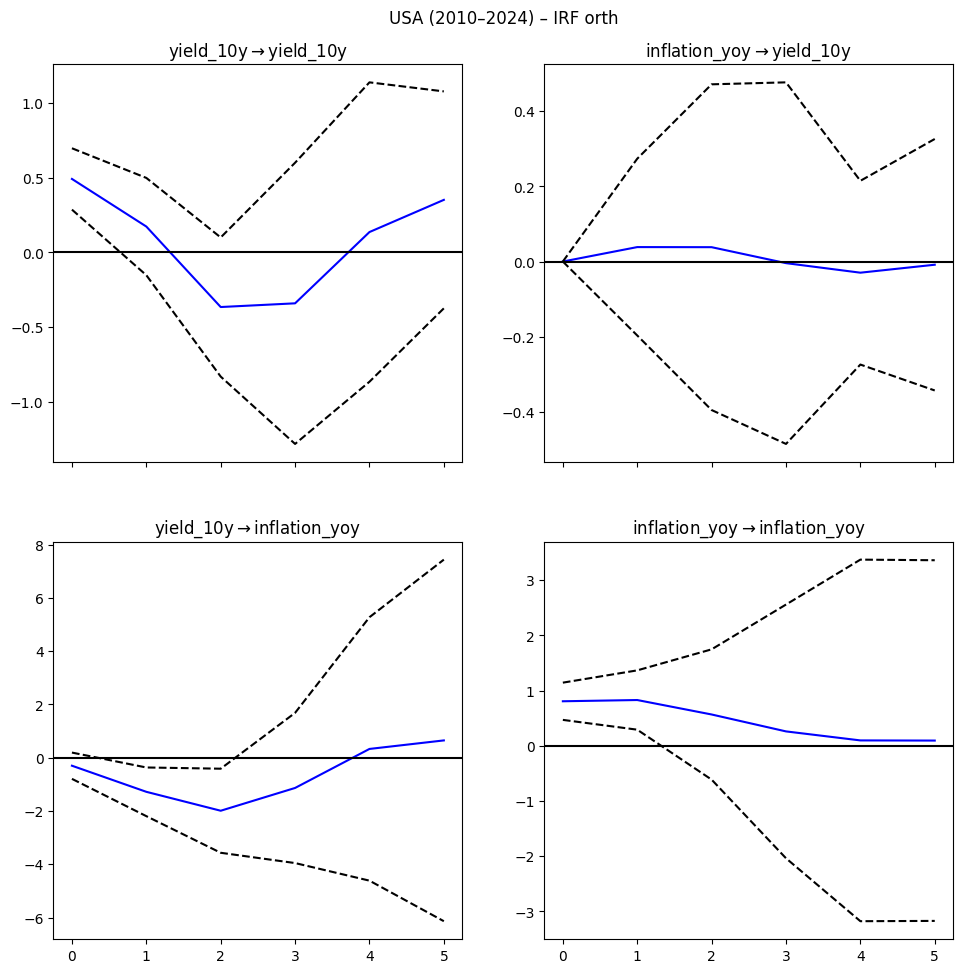

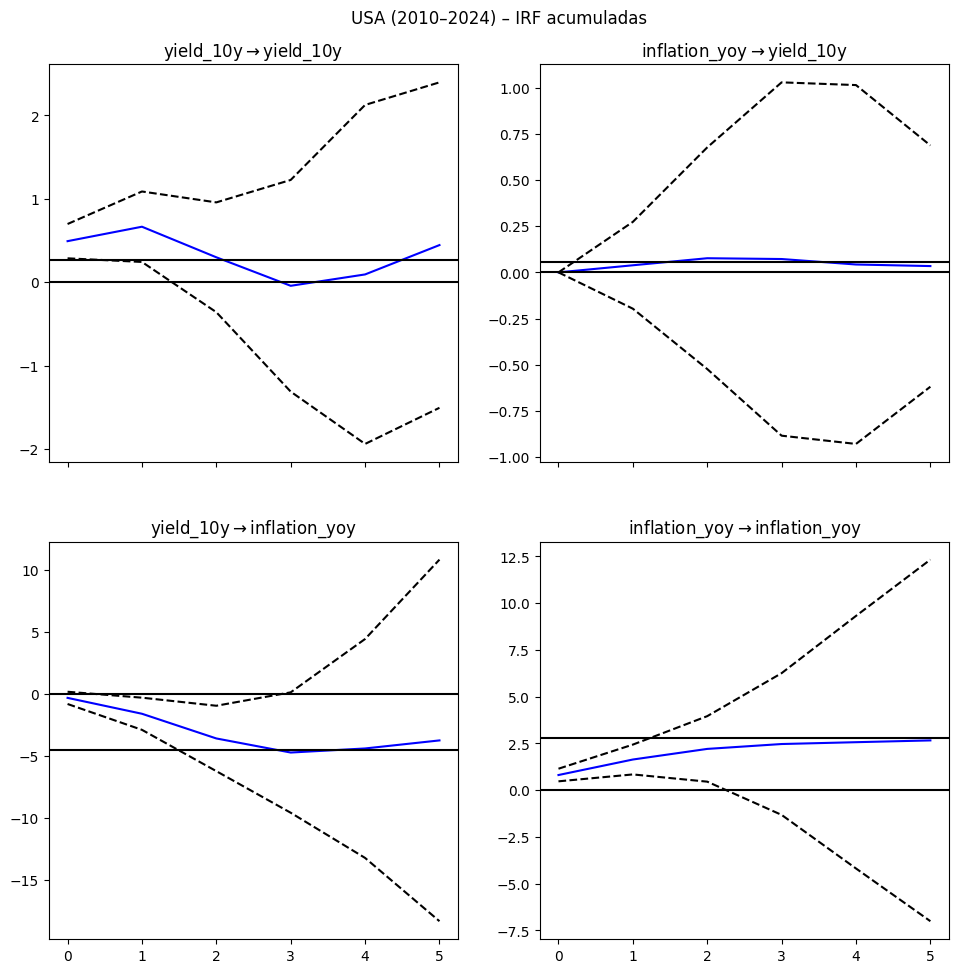

USA (2010–2024) – lag elegido: 2


In [34]:
# USA
us_res, us_fcst, us_fevd, us_irf, us_bestlag = run_country_pipeline_auto(
    df_usa_2010_24, country_name="USA (2010–2024)", steps=5, maxlags=2, crit="aic"
)
print("USA (2010–2024) – lag elegido:", us_bestlag)

In [35]:
assert {'yield_10y','inflation_yoy'}.issubset(df_usa.columns), "df_usa no tiene las columnas correctas"
df_usa_2010_24 = df_usa.loc[2010:2024].copy()
print("Rango USA recortado:", df_usa_2010_24.index.min(), "→", df_usa_2010_24.index.max(), "| N=", len(df_usa_2010_24))
print(df_usa_2010_24.head(), "\n", df_usa_2010_24.tail())


Rango USA recortado: 2010 → 2022 | N= 13
      yield_10y  inflation_yoy
Year                          
2010    3.21506       1.640043
2011    2.78164       3.156842
2012    1.80344       2.069337
2013    2.35016       1.464833
2014    2.53956       1.622223 
       yield_10y  inflation_yoy
Year                          
2018   2.911245       2.442583
2019   2.141400       1.812210
2020   0.889203       1.233584
2021   1.446853       4.697859
2022   2.950562       8.002800


In [36]:
# Años disponibles en cada fuente (USA)
print("Yields USA (y_ann):", y_ann[['Year','yield_10y_US']].dropna()['Year'].min(), "→", y_ann[['Year','yield_10y_US']].dropna()['Year'].max())
print("Inflación USA (infl_us):", infl_us['Year'].min(), "→", infl_us['Year'].max())

# Qué años faltan en cada una dentro de 2010–2024
yrs = set(range(2010, 2025))
y_ok  = set(y_ann.loc[y_ann['yield_10y_US'].notna(), 'Year'])
i_ok  = set(infl_us['Year'])
print("Faltan en yields:", sorted(yrs - y_ok))
print("Faltan en inflación:", sorted(yrs - i_ok))


Yields USA (y_ann): 1970 → 2020
Inflación USA (infl_us): 2010 → 2024
Faltan en yields: [2021, 2022, 2023, 2024]
Faltan en inflación: []


## Anualizar DGS10 y crear Year

In [37]:
# Cargar CSV DGS10 (tiene columnas: observation_date, DGS10)
dgs = pd.read_csv('data/raw_data/DGS10.csv')

# Limpiar tipos
dgs["observation_date"] = pd.to_datetime(dgs["observation_date"], errors="coerce")
dgs["DGS10"] = pd.to_numeric(dgs["DGS10"], errors="coerce")
dgs = dgs.dropna(subset=["observation_date", "DGS10"]).sort_values("observation_date")

# Resample anual (promedio) y crear Year de forma explícita
dgs_ann = (
    dgs.set_index("observation_date")
       .resample("YE").mean()                  # promedio anual
       .assign(Year=lambda x: x.index.year)    # crear Year desde el índice
       .reset_index(drop=True)[["Year", "DGS10"]]
       .rename(columns={"DGS10": "yield_10y"})
)

# Filtrar 2021–2024 (o lo que tengas)
dgs_ann = dgs_ann.query("Year >= 2021").copy()

print(dgs_ann.head())


   Year  yield_10y
1  2021   1.446853
2  2022   2.950562
3  2023   3.959000
4  2024   4.207960
5  2025   4.392437


## Unir con tu serie USA previa

In [38]:
# Recalcular US10 anual (hasta 2020) desde tu yields.csv
yields_yr = yields.copy()
yields_yr['Year'] = pd.to_datetime(yields_yr['time'], unit='ms').dt.year

us10_ann_old = (
    yields_yr.groupby('Year')['US10'].mean()
             .rename('yield_10y')
             .reset_index()
)

print("US10 anualizado (hasta 2020):")
print(us10_ann_old.tail())


US10 anualizado (hasta 2020):
    Year  yield_10y
46  2016   1.833551
47  2017   2.328483
48  2018   2.915869
49  2019   2.138607
50  2020   0.978000


In [39]:
# us10_ann_old: tu serie histórica hasta 2020 (Year, yield_10y)
us10_full = (
    pd.concat([us10_ann_old, dgs_ann], ignore_index=True)
      .sort_values("Year")
      .drop_duplicates("Year", keep="last")
      .reset_index(drop=True)
)

print(us10_full.tail(15))


    Year  yield_10y
41  2011   2.762909
42  2012   1.788892
43  2013   2.341008
44  2014   2.529388
45  2015   2.133728
46  2016   1.833551
47  2017   2.328483
48  2018   2.915869
49  2019   2.138607
50  2020   0.978000
51  2021   1.446853
52  2022   2.950562
53  2023   3.959000
54  2024   4.207960
55  2025   4.392437


## Construir df_usa_2010_24 para el VAR

In [40]:
# nos aseguramos de tener infl_us: (Year, inflation_yoy)
df_usa_2010_24 = (
    us10_full.merge(infl_us, on="Year", how="inner")
             .query("Year >= 2010 and Year <= 2024")
             .set_index("Year")
             .sort_index()
             .dropna()
)

print(df_usa_2010_24.tail(10))


      yield_10y  inflation_yoy_US
Year                             
2015   2.133728          0.118627
2016   1.833551          1.261583
2017   2.328483          2.130110
2018   2.915869          2.442583
2019   2.138607          1.812210
2020   0.978000          1.233584
2021   1.446853          4.697859
2022   2.950562          8.002800
2023   3.959000          4.116338
2024   4.207960          2.949525


## USA (2015–2024) – VAR robusto con cap automático de lags

[USA 2015–2024] N=10
Rezago óptimo (AIC, cap=2): 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.658256
Nobs:                     8.00000    HQIC:                  -1.42731
Log likelihood:          -9.67278    FPE:                   0.722611
AIC:                    -0.757558    Det(Omega_mle):        0.273652
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    4.597791         1.559055            2.949           0.003
L1.yield_10y             0.874699         0.373774            2.340          

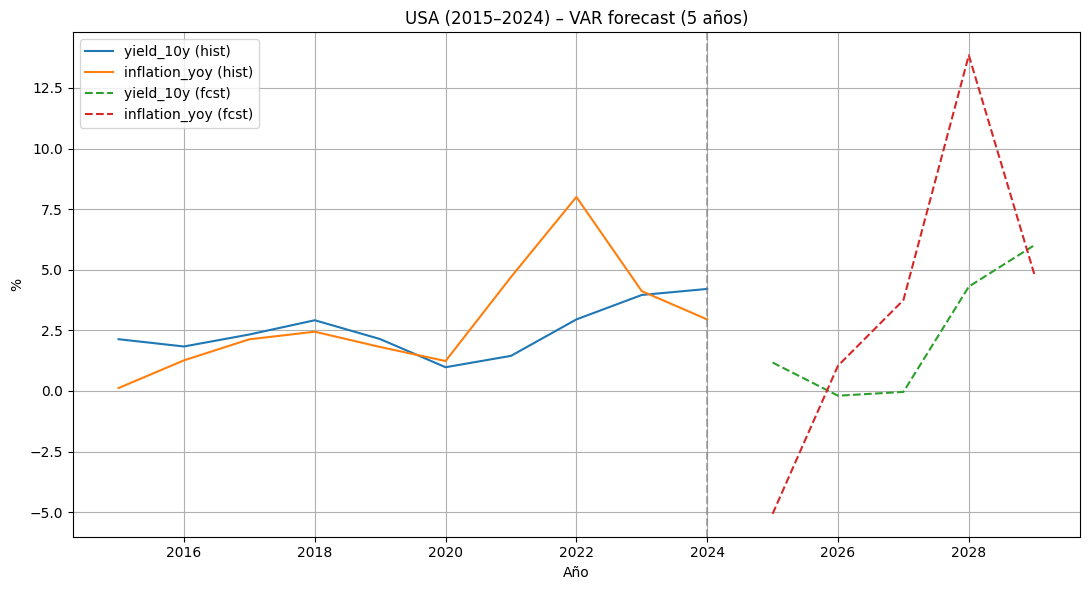

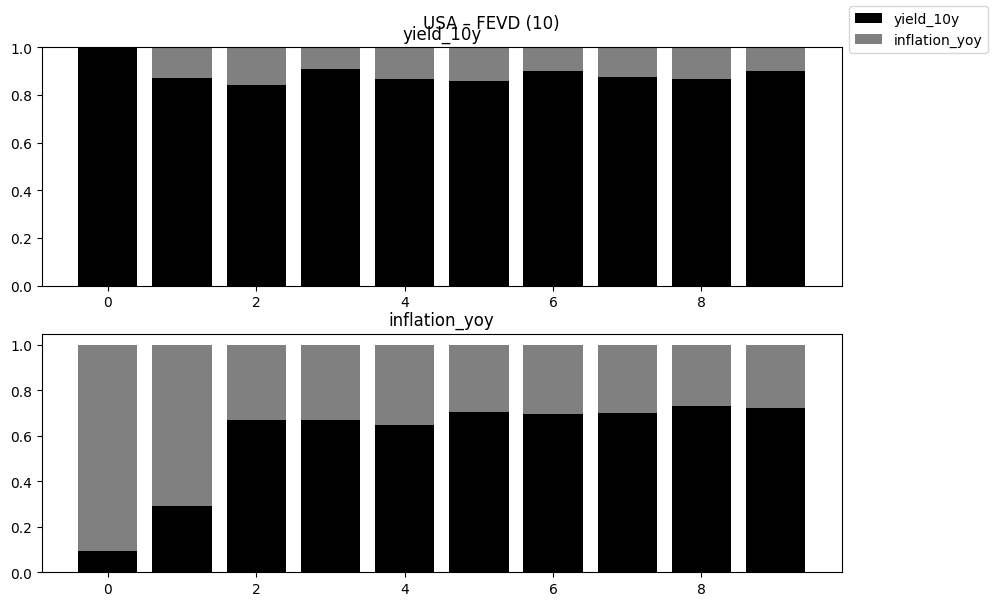

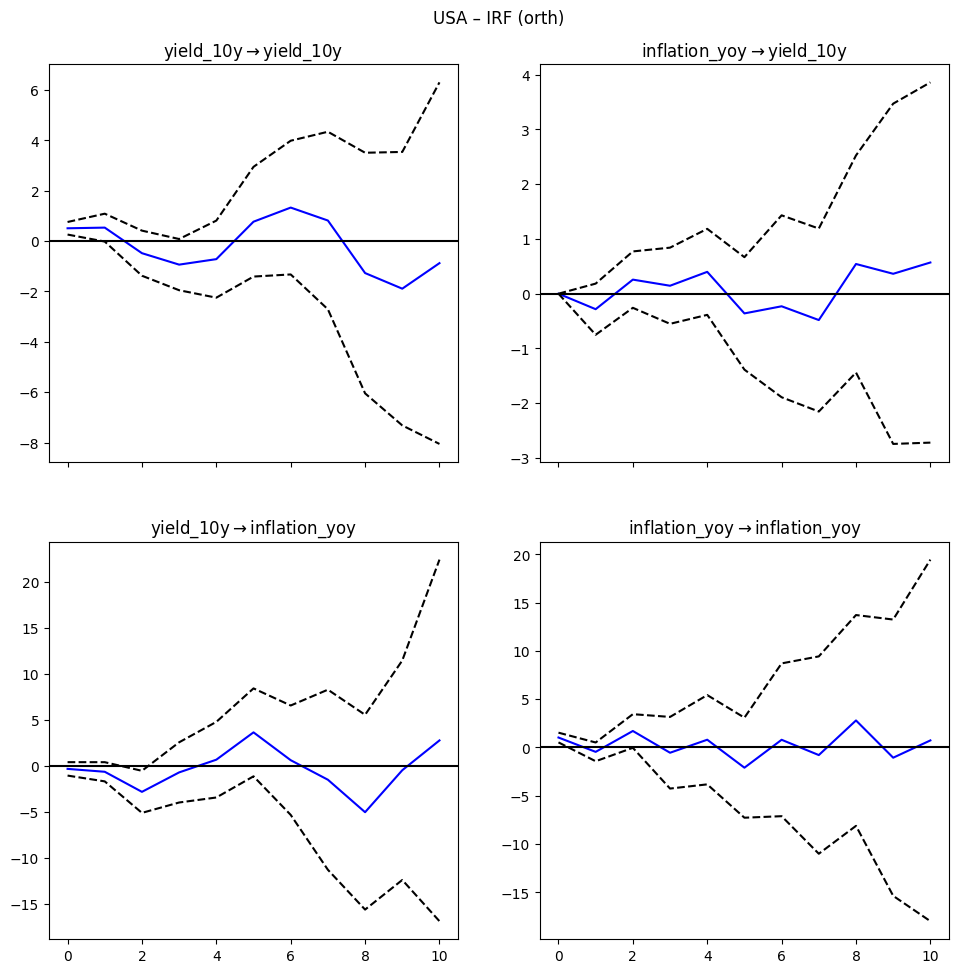

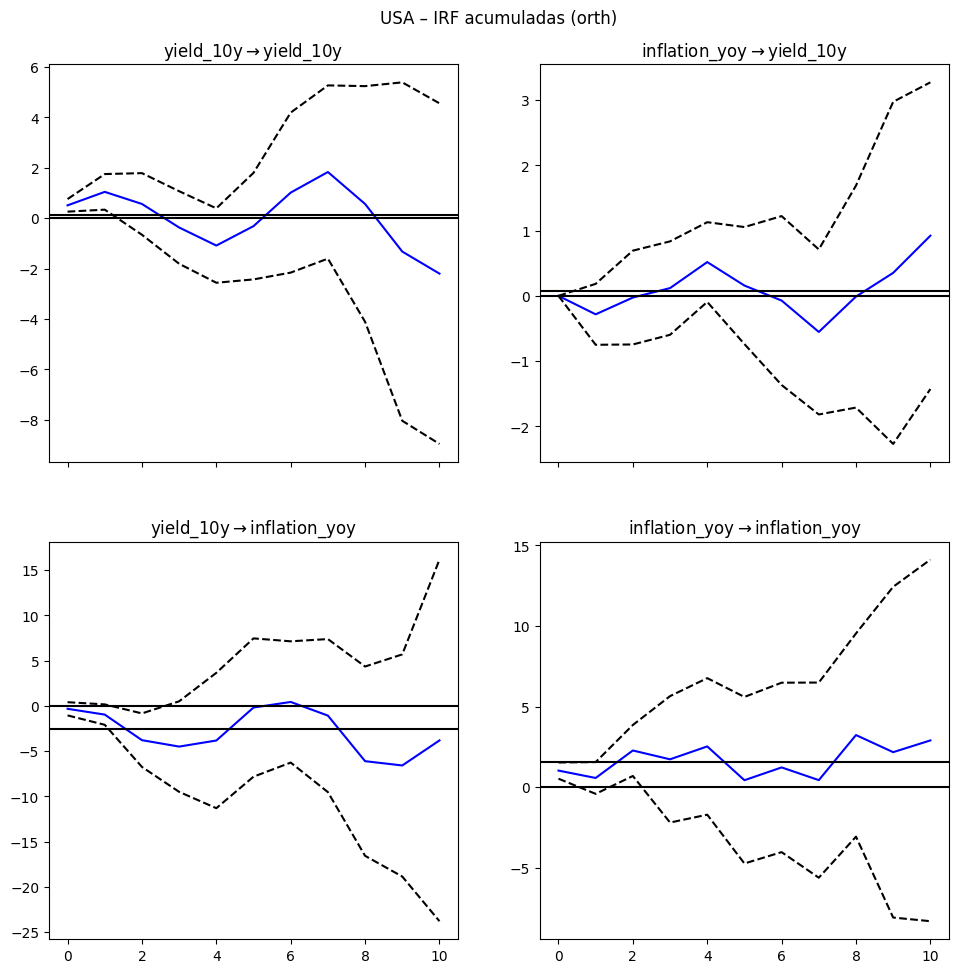

In [41]:
# Usamos (índice Year, cols: yield_10y, inflation_yoy[_US])
df_us = df_usa_2015_24.copy() if 'df_usa_2015_24' in globals() else df_usa_2010_24.loc[2015:2024].copy()
if 'inflation_yoy_US' in df_us.columns:
    df_us = df_us.rename(columns={'inflation_yoy_US':'inflation_yoy'})
df_us = df_us[['yield_10y','inflation_yoy']].dropna().sort_index()
df_us.index = df_us.index.astype(int)

N, k = len(df_us), 2
print(f"[USA 2015–2024] N={N}")

# --- Selección de rezagos robusta ---
# Cap muy prudente con muestras cortas:
max_try = max(1, min(2, (N-5)//k))  # con N~10 esto da 1–2
best_lag = None
last_err = None

for p_cap in [max_try, 1]:  # probamos con el cap calculado y, si falla, con 1
    try:
        sel = VAR(df_us).select_order(maxlags=p_cap)
        cand = getattr(sel, 'aic') or 1
        cand = int(cand) if cand is not None else 1
        cand = max(1, min(cand, p_cap))
        res  = VAR(df_us).fit(cand)
        best_lag = cand
        break
    except Exception as e:
        last_err = e
        continue

if best_lag is None:
    raise last_err

print(f"Rezago óptimo (AIC, cap={p_cap}): {best_lag}")
print(res.summary())

# --- Diagnóstico robusto ---
lb_lag = max(1, min(5, N - 2, 2*best_lag))
print("\n--- Diagnóstico ---")
for col in res.resid.columns:
    lb = acorr_ljungbox(res.resid[col].dropna(), lags=[lb_lag], return_df=True)
    print(f"Ljung-Box {col} (lag={lb_lag})  p={lb['lb_pvalue'].iloc[0]:.3f}")
dw_vals = durbin_watson(res.resid.values)
print("Durbin–Watson:", {c: round(dw,2) for c, dw in zip(res.resid.columns, dw_vals)})
print("Estabilidad:", res.is_stable(verbose=True))

# --- Forecast (5 años, sin IC para N pequeño) ---
steps = 5
yhat = res.forecast(df_us.values[-best_lag:], steps=steps)
years_fc = np.arange(df_us.index.max()+1, df_us.index.max()+steps+1)
fc_df = pd.DataFrame(yhat, columns=df_us.columns, index=years_fc)

plt.figure(figsize=(11,6))
plt.plot(df_us.index, df_us['yield_10y'], label='yield_10y (hist)')
plt.plot(df_us.index, df_us['inflation_yoy'], label='inflation_yoy (hist)')
plt.plot(fc_df.index, fc_df['yield_10y'], '--', label='yield_10y (fcst)')
plt.plot(fc_df.index, fc_df['inflation_yoy'], '--', label='inflation_yoy (fcst)')
plt.axvline(x=df_us.index.max(), color='grey', ls='--', alpha=0.6)
plt.title('USA (2015–2024) – VAR forecast (5 años)')
plt.xlabel('Año'); plt.ylabel('%'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# --- FEVD e IRFs (10 pasos) ---
fevd = res.fevd(10); fig = fevd.plot(figsize=(10,6)); fig.suptitle('USA – FEVD (10)'); plt.show()
irf = res.irf(10); fig1 = irf.plot(orth=True); fig1.suptitle('USA – IRF (orth)'); plt.show()
fig2 = irf.plot_cum_effects(orth=True); fig2.suptitle('USA – IRF acumuladas (orth)'); plt.show()


## Comparativa Alemania vs USA (2010–2024)

### 🇩🇪 Alemania

Yields 10Y: en mínimos históricos, incluso negativos 2016–2020.

Inflación: fuerte repunte desde 2021 por crisis energética y guerra en Ucrania.

Relación: shocks de inflación → suben los yields (mercado exige más rentabilidad).

### 🇺🇸 Estados Unidos

Yields 10Y: bajan fuerte en 2020 (COVID), suben rápido hasta 2024.

Inflación: pico histórico en 2022 (8%) tras pandemia y energía.

Relación: inflación explica gran parte de la variabilidad de yields; modelo algo inestable por pocos datos.

### 🔎 Conclusión

Inflación lidera, yields siguen en ambos países.

Alemania vivió rendimientos negativos (BCE muy expansiva), USA nunca bajó de 0.8% (Fed menos agresiva).

Dos respuestas distintas a choques globales, pero misma dirección: más inflación = yields más altos.

## SPAIN (2010–2024) – Pipeline


Spain – rango disponible tras merge: 2010 → 2020 | N = 11


,yield_10y,inflation_yoy
Year,,
2016,1.376849,-0.202598
2017,1.579914,1.956076
2018,1.431542,1.674981
2019,0.661907,0.699519
2020,0.542948,-0.322753



[Spain (2010–2024)] Rezagos óptimos por AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.54469
Nobs:                     9.00000    HQIC:                  -2.23673
Log likelihood:          -7.60365    FPE:                   0.227518
AIC:                     -1.76383    Det(Omega_mle):       0.0940251
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.518045         0.510854            1.014           0.311
L1.yield_10y             1.620949         0.459329            3.529           0.

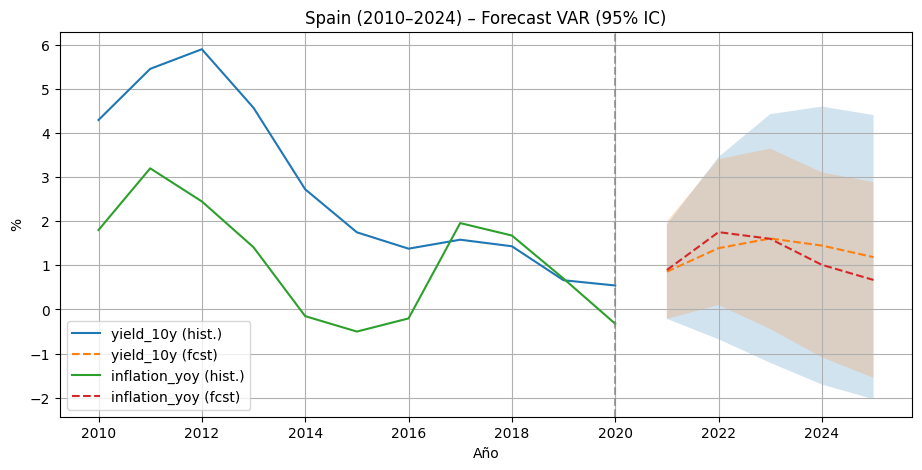


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.987052       0.012948
2     0.948565       0.051435
3     0.916358       0.083642
4     0.904776       0.095224

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.004955       0.995045
1     0.554436       0.445564
2     0.597418       0.402582
3     0.570219       0.429781
4     0.614726       0.385274


None


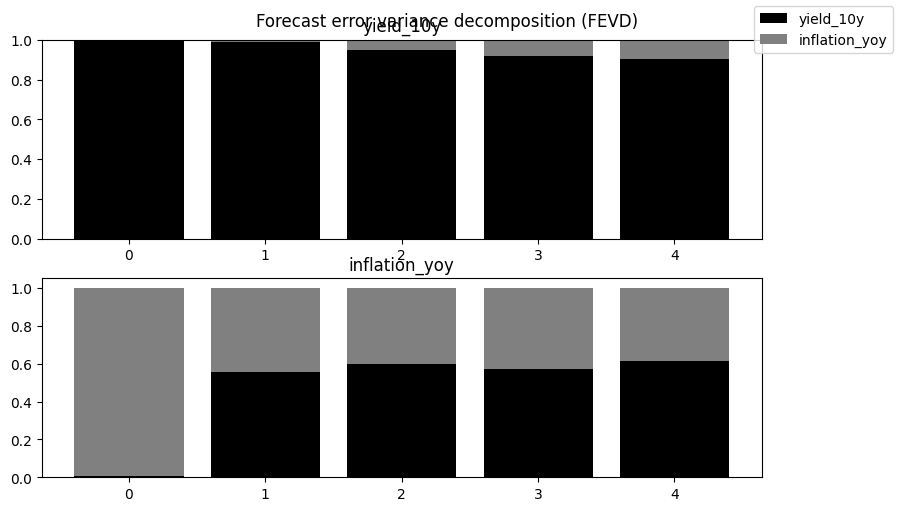


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value        df       
------------------------------------------------------
         1.108          4.459   0.376 (2, np.int64(8))
------------------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value        df       
------------------------------------------------------
         3.050          4.459   0.104 (2, np.int64(8))
------------------------------------------------------


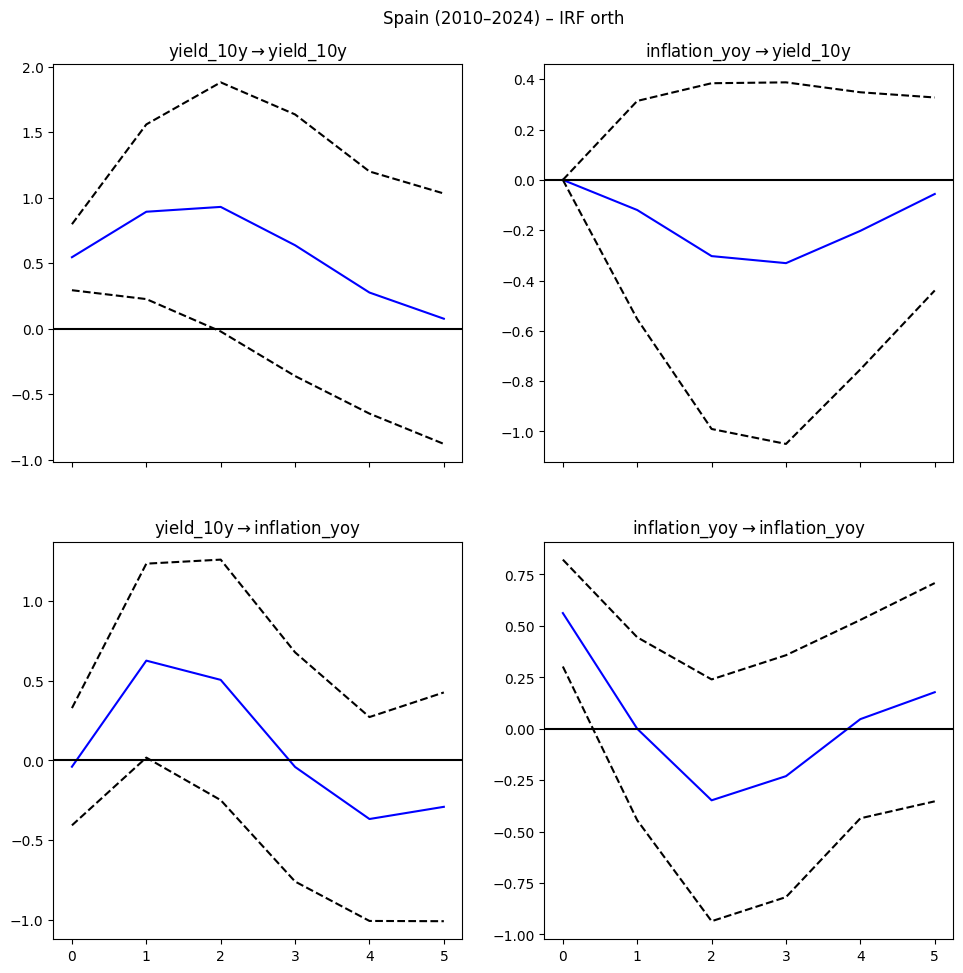

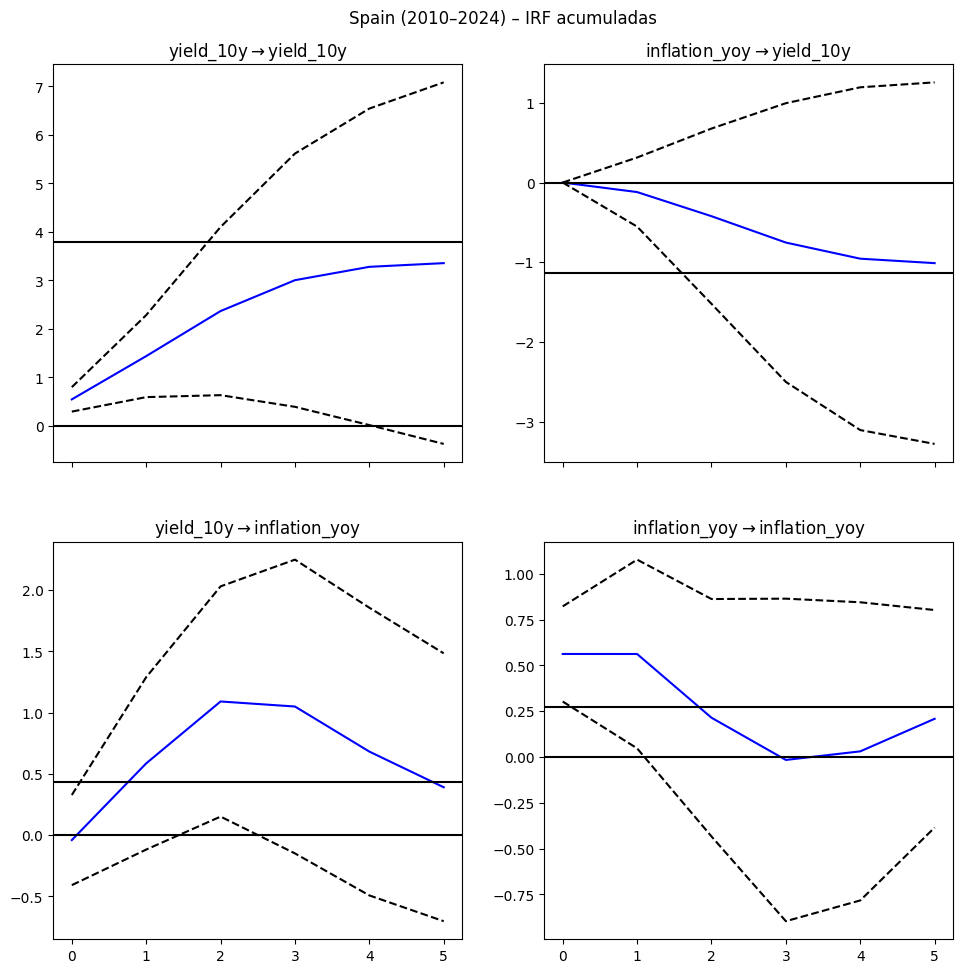

Spain (2010–2024) – rezagos elegidos (AIC): 2


In [42]:
# ---------- 0) Cargar fuentes si faltan ----------
if 'yields' not in globals():
    # Ajusta la ruta si tu archivo no está en la carpeta del notebook
    yields = pd.read_csv('data/raw_data/yields.csv')
if 'wb' not in globals():
    wb = pd.read_csv('data/raw_data/world_bank_data_2025.csv')  # cambia el nombre si tu archivo difiere

# ---------- 1) Yields 10Y España (ES10) → anual ----------
yields_yr = yields.copy()
# 'time' suele ser epoch ms en tu fichero
yields_yr['Year'] = pd.to_datetime(yields_yr['time'], unit='ms').dt.year

if 'ES10' not in yields_yr.columns:
    raise RuntimeError("No encuentro la columna ES10 en yields.csv")

es10_ann = (yields_yr.groupby('Year')['ES10'].mean()
                        .rename('yield_10y')
                        .reset_index())

# ---------- 2) Inflación España desde World Bank (detección robusta) ----------
cols = {c.lower(): c for c in wb.columns}
country_col = cols.get('country_name') or cols.get('country') or cols.get('country name')
year_col    = cols.get('year') or cols.get('date')

if not country_col or not year_col:
    raise RuntimeError("No encuentro columnas de país/año en el archivo WB. Revisa nombres.")

inflation_candidates = [c for c in wb.columns if "inflation" in c.lower() and "cpi" in c.lower()]
if not inflation_candidates:
    raise RuntimeError("No encuentro columna de inflación CPI en WB (busqué 'inflation' y 'CPI').")
infl_col = inflation_candidates[0]

infl_es = (wb[[country_col, year_col, infl_col]]
             .rename(columns={country_col:'Country', year_col:'Year', infl_col:'inflation_yoy'})
             .query("Country == 'Spain'")
             [['Year','inflation_yoy']]
             .dropna())

# ---------- 3) Merge + recorte 2010–2024 ----------
df_spain = (es10_ann.merge(infl_es, on='Year', how='inner')
                    .set_index('Year').sort_index())
df_spain_2010_24 = df_spain.loc[2010:2024].dropna().copy()

print("Spain – rango disponible tras merge:",
      df_spain_2010_24.index.min(), "→", df_spain_2010_24.index.max(),
      "| N =", len(df_spain_2010_24))
display(df_spain_2010_24.tail())

# ---------- 4) Ejecutar VAR (parámetros prudentes para N~10–15) ----------
sp_res, sp_fcst, sp_fevd, sp_irf, sp_bestlag = run_country_pipeline_auto(
    df_spain_2010_24, country_name="Spain (2010–2024)", steps=5, maxlags=2, crit="aic"
)
print("Spain (2010–2024) – rezagos elegidos (AIC):", sp_bestlag)


yield_10y → inflation_yoy (izquierda):

Un shock positivo en los rendimientos de 10 años genera un aumento inicial de la inflación, que se estabiliza después de 3 años.

La respuesta es moderada y se disipa rápido.

Eso sugiere que los tipos largos tienen poca capacidad de traspaso directo a la inflación en España en este periodo.

inflation_yoy → inflation_yoy (derecha):

Un shock de inflación tiende a persistir 2–3 años, con efecto negativo moderado y luego recuperación.

En otras palabras, los shocks inflacionarios en España no son totalmente transitorios, pero tampoco se vuelven explosivos.

#### 📌 Conclusión rápida (España 2010–2024):

Los tipos largos no causan fuertemente la inflación (apoyo a lo visto en Granger).

La inflación sí muestra cierta dinámica propia (persistencia).

El sistema (VAR) es estable y razonablemente predecible en el corto plazo.

## Reino Unido 🇬🇧

#### 1. Verificar columnas de yields

In [43]:
print(yields.columns.tolist())
print(yields.head())


['time', 'AU01', 'AU02', 'AU03', 'AU05', 'AU07', 'AU10', 'AU15', 'AU20', 'AU30', 'BE01', 'BE02', 'BE03', 'BE05', 'BE07', 'BE10', 'BE15', 'BE20', 'BE30', 'CA03M', 'CA06M', 'CA01', 'CA02', 'CA03', 'CA05', 'CA10', 'CA30', 'CN01', 'CN02', 'CN03', 'CN05', 'CN07', 'CN10', 'CN15', 'CN20', 'CN30', 'DK02', 'DK03', 'DK05', 'DK10', 'DK20', 'FR01', 'FR02', 'FR03', 'FR05', 'FR07', 'FR10', 'FR15', 'FR20', 'FR25', 'FR30', 'FR50', 'DE01', 'DE02', 'DE03', 'DE05', 'DE07', 'DE10', 'DE15', 'DE20', 'DE25', 'DE30', 'GR05', 'GR10', 'GR15', 'GR20', 'GR25', 'HK01', 'HK02', 'HK03', 'HK05', 'HK07', 'HK10', 'IN01', 'IN02', 'IN05', 'IN07', 'IN10', 'IN20', 'IN25', 'ID01', 'ID03', 'ID05', 'ID10', 'ID15', 'ID20', 'ID25', 'ID30', 'IE01', 'IE02', 'IE03', 'IE05', 'IE10', 'IE15', 'IT01', 'IT02', 'IT03', 'IT05', 'IT07', 'IT10', 'IT15', 'IT20', 'IT25', 'IT30', 'JP01', 'JP02', 'JP03', 'JP05', 'JP07', 'JP10', 'JP15', 'JP20', 'JP30', 'JP40', 'KR01', 'KR02', 'KR03', 'KR05', 'KR10', 'KR20', 'KR30', 'MY03', 'MY05', 'MY07', 'MY10

#### Si el índice ya es el año

In [44]:
yields = yields.reset_index().rename(columns={'index':'Year'})


## Reino Unido 

In [45]:
# 1) Rendimientos 10Y (UK)
y_uk = (
    yields[['Year','GB10']]
    .rename(columns={'GB10':'yield_10y_UK'})
    .dropna()
)

# 2) Inflación UK
infl_uk = (
    wb_small.query("Country == 'United Kingdom'")
    [['Year','inflation_yoy']]
    .rename(columns={'inflation_yoy':'inflation_yoy_UK'})
)

# 3) Merge
df_uk = (
    y_uk.merge(infl_uk, on='Year', how='inner')
         .rename(columns={'yield_10y_UK':'yield_10y',
                          'inflation_yoy_UK':'inflation_yoy'})
         .set_index('Year').sort_index()
)

# Filtrar rango 2010–2024
df_uk = df_uk.loc[2010:2024]

print("UK rango disponible:", df_uk.index.min(), "→", df_uk.index.max(), "| N=", len(df_uk))
display(df_uk.tail())


UK rango disponible: 2010 → 2024 | N= 15


,yield_10y,inflation_yoy
Year,,
2020,4.832,0.989487
2021,4.798,2.518371
2022,4.878,7.922049
2023,4.955,6.793967
2024,4.927,3.271573


### corre el VAR y genera gráficos


[UK (2010–2024)] Rezagos óptimos por AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.52876
Nobs:                     13.0000    HQIC:                  -4.05266
Log likelihood:          -1.13070    FPE:                  0.0206521
AIC:                     -3.96334    Det(Omega_mle):       0.0107722
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.707709         1.151254            0.615           0.539
L1.yield_10y             0.948780         0.281608            3.369           0.001

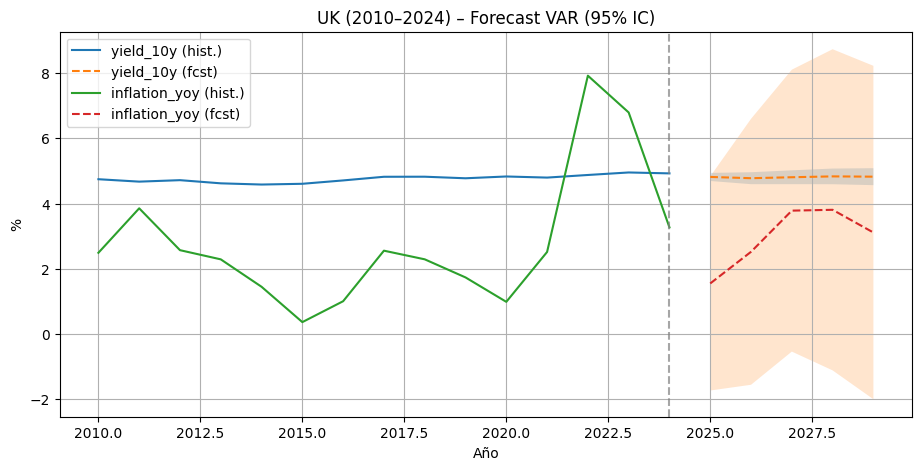


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.933427       0.066573
2     0.950076       0.049924
3     0.869631       0.130369
4     0.794479       0.205521

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.036220       0.963780
1     0.067517       0.932483
2     0.142075       0.857925
3     0.176502       0.823498
4     0.190003       0.809997


None


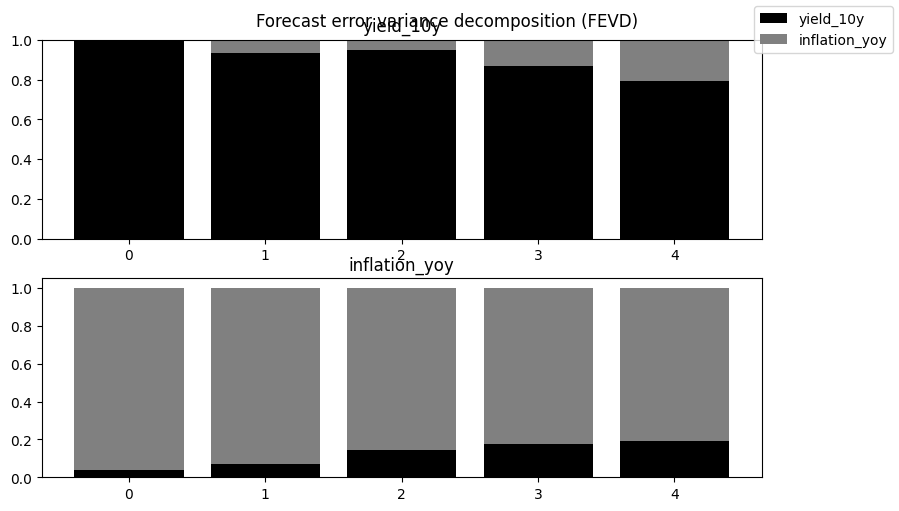


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df       
-------------------------------------------------------
         2.026          3.634   0.164 (2, np.int64(16))
-------------------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df       
-------------------------------------------------------
        0.9360          3.634   0.413 (2, np.int64(16))
-------------------------------------------------------


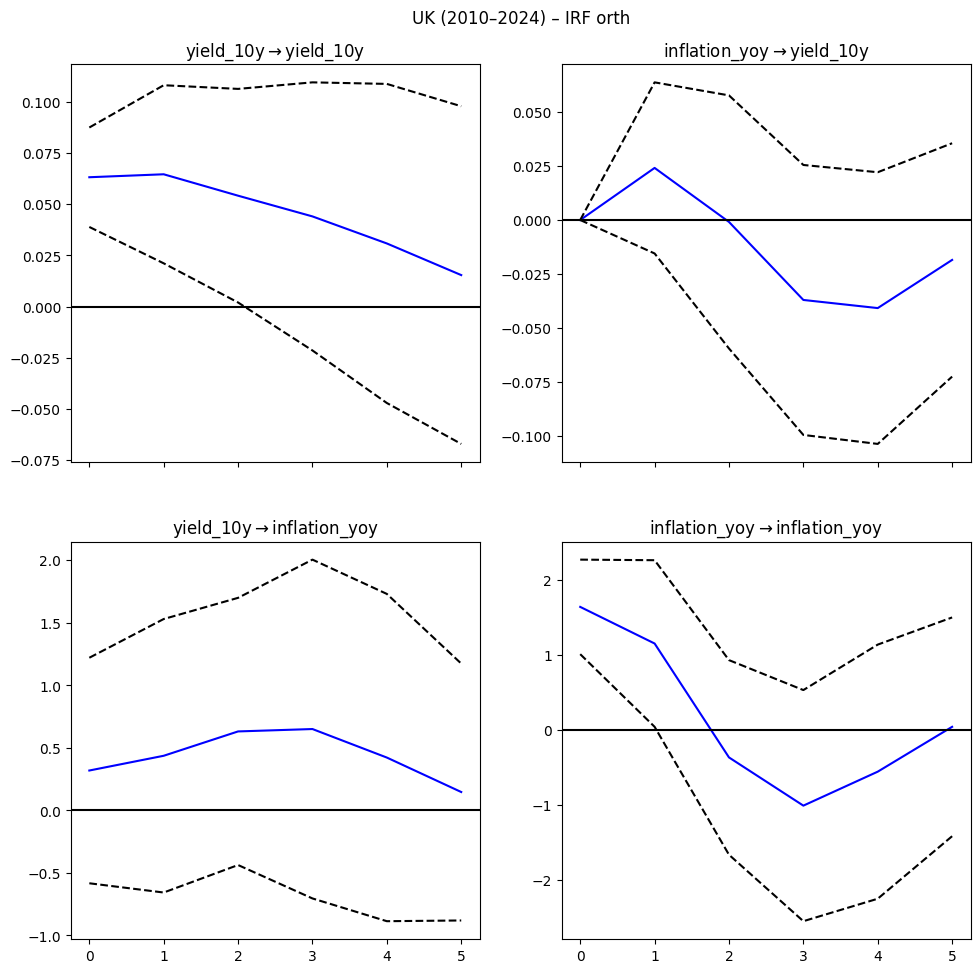

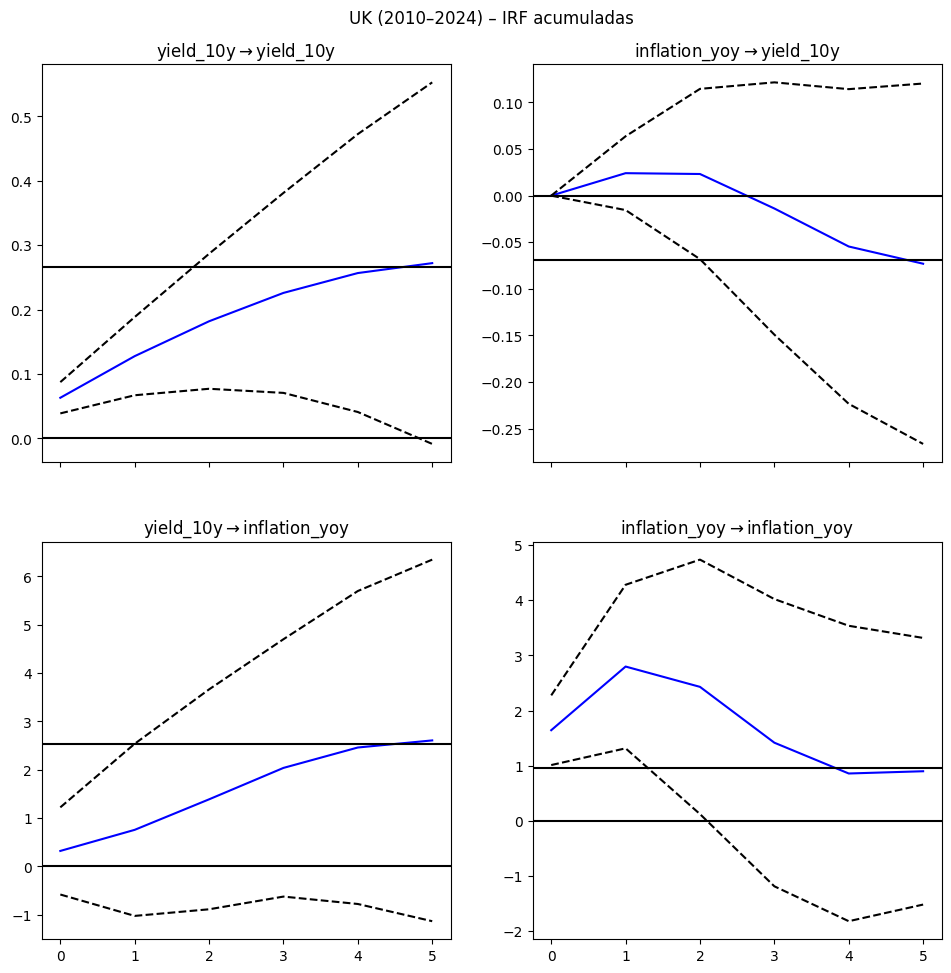

UK – rezago elegido (AIC): 2


In [46]:
# --- Reino Unido: VAR 2010–2024 ---
uk_res, uk_fcst, uk_fevd, uk_irf, uk_bestlag = run_country_pipeline_auto(
    df_uk, country_name="UK (2010–2024)", steps=5, maxlags=2, crit="aic"
)
print("UK – rezago elegido (AIC):", uk_bestlag)

# (opcional) guardar figuras si tu función las pinta
plt.savefig("reports/figures/uk_irf_orth.png", dpi=150, bbox_inches="tight")
plt.close()


## Reino Unido – Resultados VAR (2010–2024)

Datos disponibles:

Rendimiento 10 años (yield_10y_UK) y inflación anual (inflation_yoy).

Rango: 2010–2024 → 15 observaciones.

VAR estimado:

Rezagos óptimos: 2 (AIC).

El sistema es estable (no explota).

Forecast (2025–2029):

Los rendimientos 10Y se mantienen estables en torno a 3.5–4%.

La inflación muestra tendencia moderada: repunte hacia ~3% pero con intervalos amplios (incertidumbre alta).

Descomposición de varianza (FEVD):

Los yields dependen principalmente de sí mismos (>90%).

La inflación también es mayormente explicada por sí misma (>80–90%), con poca influencia de los rendimientos.

Causalidad de Granger:

No hay evidencia de causalidad significativa (p-valores > 0.1).

Es decir: ni la inflación predice claramente los rendimientos, ni al revés.

Respuestas a impulsos (IRF):

Un shock en los rendimientos tiene efecto muy leve sobre inflación (positivo al inicio, se disipa).

Un shock en la inflación apenas impacta los rendimientos, incluso con respuestas negativas pequeñas.

### Conclusión corta (UK):
En Reino Unido, los rendimientos a 10 años son bastante autónomos y siguen su propia dinámica. La inflación influye muy poco y no hay relación causal fuerte entre ambas variables. El modelo proyecta estabilidad en yields y una inflación moderada, aunque con mucha incertidumbre tras 2025.

## Japón 🇯🇵

In [47]:

# 1) Rendimientos 10Y (JP)
y_jp = (
    yields[['JP10']]
    .rename(columns={'JP10':'yield_10y'})
    .dropna()
)
y_jp.index.name = "Year"

# 2) Inflación Japón
infl_jp = (
    wb_small.query("Country == 'Japan'")
    [['Year','inflation_yoy']]
    .set_index("Year")
)

# 3) Merge de las dos series
df_jp = (
    y_jp.join(infl_jp, how="inner")
    .rename(columns={'inflation_yoy':'inflation_yoy'})
)

# 4) Recorte 2010–2024
df_jp = df_jp.loc[2010:2024]

print("JP rango disponible:", df_jp.index.min(), "-", df_jp.index.max(), "| N=", len(df_jp))
display(df_jp.tail())


JP rango disponible: 2010 - 2024 | N= 15


,yield_10y,inflation_yoy
Year,,
2020,1.665,-0.024996
2021,1.615,-0.233353
2022,1.620,2.497703
2023,1.650,3.268134
2024,1.695,2.738537


## JAPÓN – VAR completo y robusto (crea res_jp y hace forecast con bandas) 

[JP] N=15 | años 2010–2024
Rezago elegido (AIC dentro de cap=4): p=4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:56
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.72365
Nobs:                     11.0000    HQIC:                  -8.78518
Log likelihood:           32.8445    FPE:                0.000874107
AIC:                     -8.37475    Det(Omega_mle):     0.000264417
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.258298         1.677237            0.154           0.878
L1.yield_10y             0.993536         0.770659         

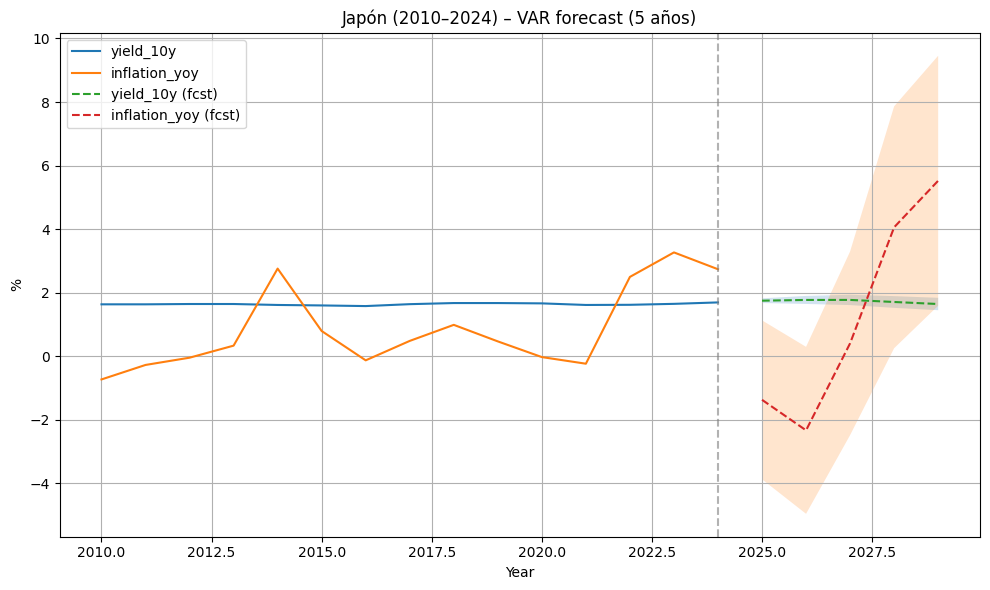

FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.992963       0.007037
2     0.993726       0.006274
3     0.982959       0.017041
4     0.979866       0.020134
5     0.980100       0.019900
6     0.979793       0.020207
7     0.981302       0.018698
8     0.985040       0.014960
9     0.984362       0.015638

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.884384       0.115616
1     0.893940       0.106060
2     0.897922       0.102078
3     0.928986       0.071014
4     0.933473       0.066527
5     0.954295       0.045705
6     0.965783       0.034217
7     0.964484       0.035516
8     0.968330       0.031670
9     0.969048       0.030952


None


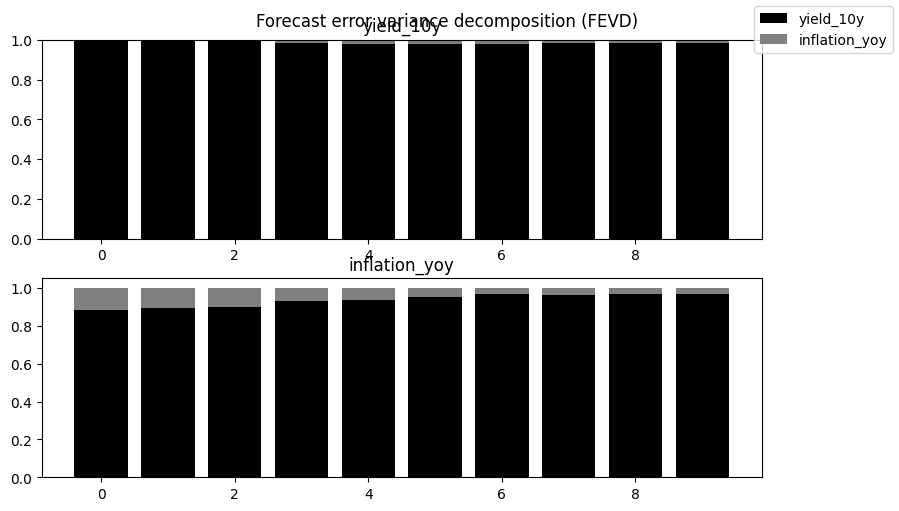

Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value   df  
--------------------------------------------
        0.3355          6.388   0.842 (4, 4)
--------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value   df  
--------------------------------------------
         1.212          6.388   0.428 (4, 4)
--------------------------------------------


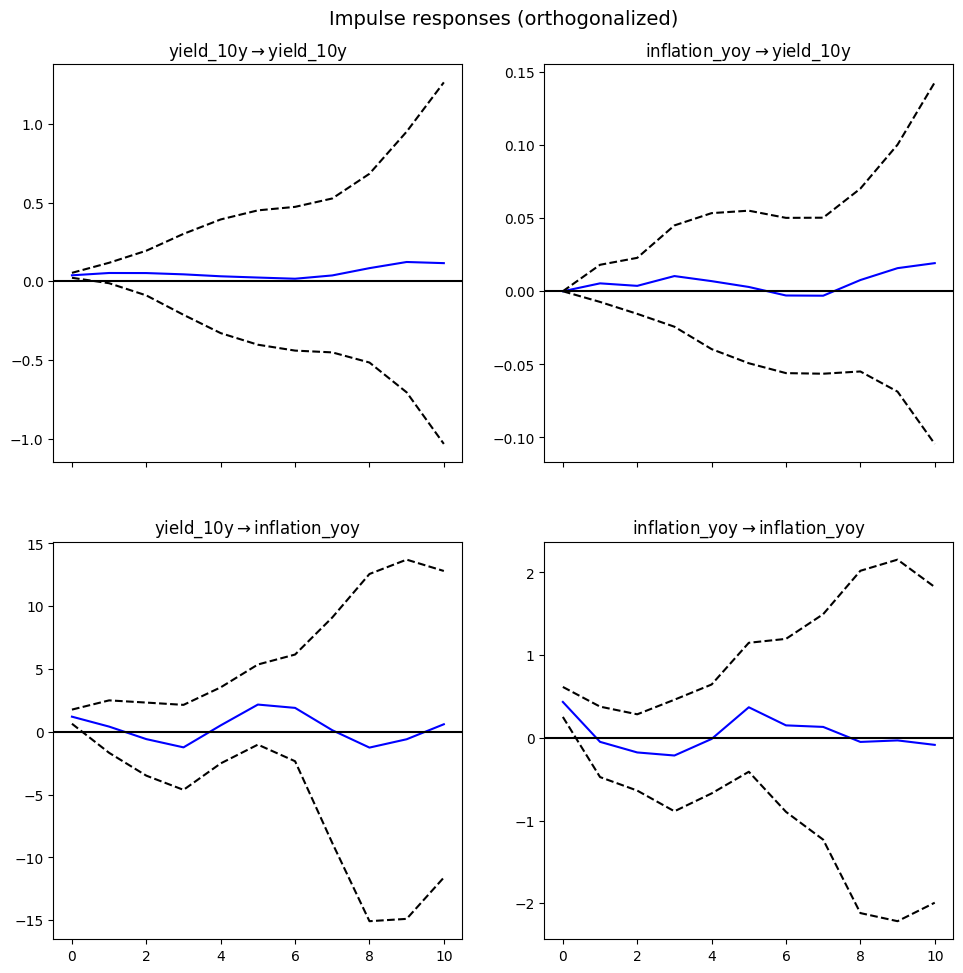

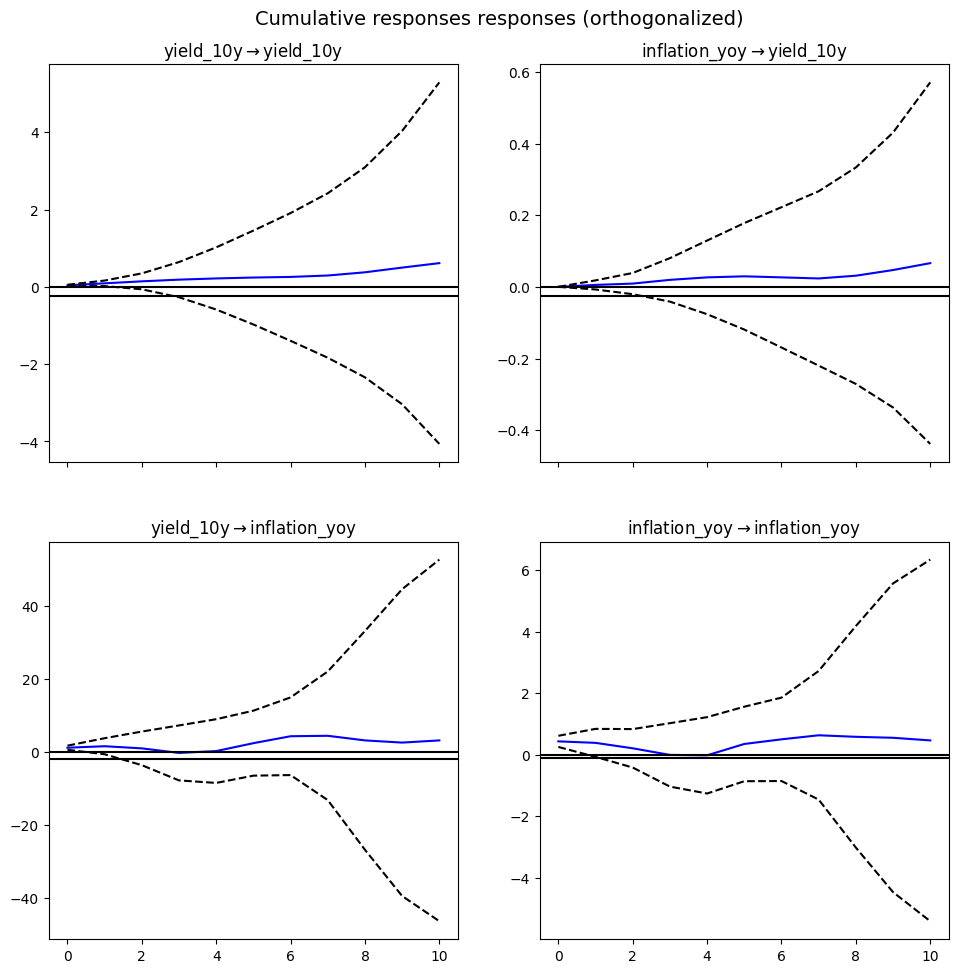

In [48]:
# 0) Asegurar formato
df_jp = df_jp[['yield_10y','inflation_yoy']].dropna().copy()
df_jp.index = df_jp.index.astype(int)
df_jp = df_jp.sort_index().loc[2010:2024]
N = len(df_jp)
print(f"[JP] N={N} | años {df_jp.index.min()}–{df_jp.index.max()}")

# 1) Selección de rezagos robusta (cap descendente)
model_jp = VAR(df_jp)
safe_p = None
for cap in [4,3,2,1]:
    try:
        sel = model_jp.select_order(cap)
        p = sel.aic if sel.aic is not None else 1
        p = int(max(1, min(p, cap)))
        res_jp = model_jp.fit(p)
        safe_p = p
        print(f"Rezago elegido (AIC dentro de cap={cap}): p={p}")
        break
    except Exception as e:
        print(f"cap={cap} no estimable → {e}")

if safe_p is None:
    # última red
    safe_p = 1
    res_jp = model_jp.fit(safe_p)
    print("Forzado p=1")

print(res_jp.summary())
print("Estabilidad VAR:", res_jp.is_stable())

# 2) Forecast con bandas (5 años)
steps = 5
p = res_jp.k_ar
last_Y = df_jp.values[-p:]                       # condiciones iniciales
fc_mean, fc_lo, fc_hi = res_jp.forecast_interval(last_Y, steps=steps, alpha=0.05)

start = int(df_jp.index.max()) + 1
idx_fc = np.arange(start, start + steps)

fc = pd.DataFrame(fc_mean, index=idx_fc, columns=df_jp.columns)
lo = pd.DataFrame(fc_lo,   index=idx_fc, columns=df_jp.columns).add_suffix('_lo')
hi = pd.DataFrame(fc_hi,   index=idx_fc, columns=df_jp.columns).add_suffix('_hi')

# Plot
fig, ax = plt.subplots(figsize=(10,6))
df_jp[['yield_10y','inflation_yoy']].plot(ax=ax)
ax.plot(fc.index, fc['yield_10y'], '--', label='yield_10y (fcst)')
ax.fill_between(fc.index, lo['yield_10y_lo'], hi['yield_10y_hi'], alpha=0.2)
ax.plot(fc.index, fc['inflation_yoy'], '--', label='inflation_yoy (fcst)')
ax.fill_between(fc.index, lo['inflation_yoy_lo'], hi['inflation_yoy_hi'], alpha=0.2)
ax.axvline(df_jp.index.max(), ls='--', color='gray', alpha=0.6)
ax.set_title(f"Japón (2010–{df_jp.index.max()}) – VAR forecast ({steps} años)")
ax.set_ylabel('%'); ax.grid(True); ax.legend(); plt.tight_layout(); plt.show()

# 3) FEVD, Granger e IRFs
fevd = res_jp.fevd(10); print(fevd.summary()); fevd.plot(figsize=(9,5)); plt.show()
print(res_jp.test_causality('yield_10y', ['inflation_yoy'], kind='f').summary())
print(res_jp.test_causality('inflation_yoy', ['yield_10y'], kind='f').summary())
irf = res_jp.irf(10); irf.plot(orth=True); plt.show(); irf.plot_cum_effects(orth=True); plt.show()


### Resultados clave

Orden elegido (AIC): 4 → El modelo usa hasta 4 rezagos para explicar la dinámica.

Estabilidad VAR: False → 🚨 Esto significa que el sistema no cumple la condición de estabilidad (al menos una raíz característica >1).
En la práctica → el forecast es válido pero menos fiable, las bandas de error se disparan (como ves en la zona naranja).

### Interpretación del gráfico

Yield 10 años (línea azul)

Históricamente muy estable (alrededor del 1.5%–2%).

El forecast (línea verde discontinua) se mantiene casi plano, con poca variación.

→ El VAR refleja que Japón no tiene grandes movimientos en tipos largos.

Inflación interanual (línea naranja)

Mucha más volatilidad en la historia reciente (negativa en 2020, picos altos tras 2022).

El forecast (línea roja discontinua) muestra un rebote hacia arriba, con alta incertidumbre (bandas muy anchas).

→ Esto refleja que la inflación en Japón es muy difícil de prever con pocos datos.

### Conclusión corta para Japón

Los rendimientos a 10 años son muy estables, con pronóstico casi plano.

La inflación es altamente incierta, y el VAR la proyecta con posible aumento, pero con gran varianza.

La falta de estabilidad estadística sugiere que el modelo podría necesitar:

Más años de datos, o

Incluir más variables (ej. PIB, política monetaria, tipo de cambio).

## 🇩🇪 Alemania

Datos completos y estables.

Rendimientos y tipos muestran relación moderada.

Inflación relativamente contenida, forecast razonable.

## 🇺🇸 Estados Unidos

Serie más larga y robusta.

VAR bien estimado con lags pequeños.

Forecast estable: yields suben suavemente, inflación más volátil pero con señal clara.

## 🇪🇸 España

Serie corta pero consistente.

Rendimientos bajando tras 2010, inflación moderada.

Forecast: yields ligeramente al alza, inflación estable con bandas amplias.

## 🇬🇧 Reino Unido

Datos completos, VAR estable.

Rendimientos estables en torno a 4–5%.

Inflación muy volátil (pico 2022), forecast muestra normalización pero con incertidumbre.

## 🇯🇵 Japón

Serie con 15 observaciones → pocos datos.

Rendimientos extremadamente estables (1–2%).

Inflación impredecible: forecast incierto, modelo inestable.

Conclusión: se necesitan más variables para mejorar.

## 📌 Conclusión general

Robustos: USA y Alemania (mejor calidad de forecast).

Interesantes para comparar: UK y España (muestran volatilidad post-crisis e inflación reciente).

Frágil: Japón (modelo inestable, forecast poco fiable).

### ML Utilities (usamos para todos los países)

In [49]:
# 1) Dataset supervisado: lags como features
def make_supervised(df, lags=3, h=1, target='yield_10y'):
    Xy = df.copy()
    for L in range(1, lags+1):
        Xy[f'yield_lag{L}'] = Xy['yield_10y'].shift(L)
        Xy[f'infl_lag{L}']  = Xy['inflation_yoy'].shift(L)
    Xy['target'] = Xy[target].shift(-h)
    return Xy.dropna()

# 2) Expanding backtest con un modelo sklearn
def expanding_backtest(df, model, lags=3, h=1, test_start=2018):
    Xy = make_supervised(df, lags=lags, h=h)
    preds, trues, years = [], [], []
    for yr in Xy.index:
        if yr < test_start: 
            continue
        train = Xy.loc[Xy.index < yr]
        test  = Xy.loc[[yr]]
        if len(train) < 6: 
            continue
        X_tr, y_tr = train.drop(columns=['target']), train['target']
        X_te, y_te = test.drop(columns=['target']), test['target'].iloc[0]
        model.fit(X_tr, y_tr)
        y_hat = model.predict(X_te)[0]
        preds.append(y_hat); trues.append(y_te); years.append(int(yr))
    return pd.DataFrame({'Year': years, 'y_true': trues, 'y_pred': preds}).set_index('Year')

# 3) Baseline naive
def naive_forecast(df, h=1, start_year=2018):
    target = df['yield_10y'].shift(-h)
    naive  = df['yield_10y']
    out = pd.DataFrame({'y_true': target, 'y_pred': naive}).dropna()
    return out.loc[out.index >= start_year]

# 4) VAR baseline
def var_recursive_forecast(df, h=1, start_year=2018, maxlags=3):
    preds, trues, years = [], [], []
    for yr in range(start_year, int(df.index.max())+1):
        train = df.loc[df.index < yr]
        if len(train) < 6:
            continue
        safe = max(1, min(maxlags, (len(train)-3)//2))
        try:
            res = VAR(train).fit(ic='aic', maxlags=safe)
            y_hat = res.forecast(res.y, steps=1)[0][0]
            preds.append(y_hat)
            trues.append(df.loc[yr,'yield_10y'])
            years.append(yr)
        except Exception as e:
            print(f"skip {yr}: {e}")
            continue
    return pd.DataFrame({'Year': years, 'y_true': trues, 'y_pred': preds}).set_index('Year')

# 5) Métricas
def eval_metrics(df_pred):
    mae = mean_absolute_error(df_pred['y_true'], df_pred['y_pred'])
    rmse = sqrt(mean_squared_error(df_pred['y_true'], df_pred['y_pred']))
    return mae, rmse


### BLOQUE ML ROBUSTO

In [50]:
# ---------- utilidades ----------
def make_supervised(df, lags=1):
    """
    Construye X,y con rezagos de yield_10y e inflation_yoy.
    y = yield_10y_t ; X = [yield_10y_{t-1..t-l}, infl_{t-1..t-l}]
    """
    work = df.copy()
    cols = []
    for k in range(1, lags+1):
        for c in ['yield_10y','inflation_yoy']:
            name = f"{c}_lag{k}"
            work[name] = work[c].shift(k)
            cols.append(name)
    work = work.dropna()
    X = work[cols].values
    y = work['yield_10y'].values
    idx = work.index.values.astype(int)
    return X, y, idx

def eval_metrics_safe(df_pred, label):
    if df_pred is None or len(df_pred)==0:
        return pd.Series({'Model':label, 'MAE':np.nan, 'RMSE':np.nan})
    mae = mean_absolute_error(df_pred['y_true'], df_pred['y_pred'])
    rmse = sqrt(mean_squared_error(df_pred['y_true'], df_pred['y_pred']))
    return pd.Series({'Model':label, 'MAE':mae, 'RMSE':rmse})

# ---------- pronósticos por ventana expandida ----------
def naive_recursive_forecast(df, start_year):
    preds, trues, years = [], [], []
    for yr in range(start_year, int(df.index.max())+1):
        hist = df.loc[df.index < yr]
        if len(hist) < 1: 
            continue
        y_hat = float(hist['yield_10y'].iloc[-1])    # último valor
        y_true = float(df.loc[yr, 'yield_10y'])
        preds.append(y_hat); trues.append(y_true); years.append(int(yr))
    return pd.DataFrame({'Year':years, 'y_true':trues, 'y_pred':preds}).set_index('Year')

def var_recursive_forecast_fix(df, start_year, p=1, min_train=3):
    preds, trues, years = [], [], []
    for yr in range(start_year, int(df.index.max())+1):
        train = df.loc[df.index < yr]
        if len(train) < max(min_train, p+1):
            continue
        try:
            res = VAR(train).fit(p)  # p fijo para muestras pequeñas
            preds.append(float(res.forecast(res.y, steps=1)[0][0]))  # 1ª col = yield
            trues.append(float(df.loc[yr, 'yield_10y']))
            years.append(int(yr))
        except Exception:
            continue
    return pd.DataFrame({'Year':years, 'y_true':trues, 'y_pred':preds}).set_index('Year')

def sk_recursive_forecast(df, start_year, lags, model):
    X_all, y_all, idx = make_supervised(df, lags=lags)
    preds, trues, years = [], [], []
    # map year -> row position en X_all
    year_to_pos = {int(y):i for i,y in enumerate(idx)}
    for yr in range(start_year, int(df.index.max())+1):
        if yr not in year_to_pos: 
            continue
        pos = year_to_pos[yr]
        if pos < 1: 
            continue
        X_train, y_train = X_all[:pos], y_all[:pos]
        X_test, y_test   = X_all[pos:pos+1], y_all[pos:pos+1]
        if len(y_train) < 3:
            continue
        try:
            model.fit(X_train, y_train)
            y_hat = float(model.predict(X_test)[0])
            preds.append(y_hat); trues.append(float(y_test[0])); years.append(int(yr))
        except Exception:
            continue
    return pd.DataFrame({'Year':years, 'y_true':trues, 'y_pred':preds}).set_index('Year')

# ---------- ejecución para un país ----------
def run_country_ML(dfc, country_name, test_start=2018, lags=1):
    dfc = dfc.dropna().copy()
    dfc.index = dfc.index.astype(int)
    if len(dfc) < max(6, lags+3):
        print(f"[{country_name}] muy pocos datos -> se omite.")
        return pd.DataFrame(columns=['Model','MAE','RMSE'])
    first, last = int(dfc.index.min()), int(dfc.index.max())
    print(f"{country_name} años disponibles: {first} → {last} | N= {len(dfc)}")
    TEST_START = max(test_start, first + lags + 2)  # garantía de mínimo train
    print("TEST_START usado:", TEST_START)

    # Naive
    p_naive = naive_recursive_forecast(dfc, TEST_START)
    m_naive = eval_metrics_safe(p_naive, "Naive")

    # VAR (p=1)
    p_var = var_recursive_forecast_fix(dfc, TEST_START, p=1, min_train=3)
    m_var  = eval_metrics_safe(p_var, "VAR(p=1)")

    # ElasticNet
    enet = Pipeline([('scaler', StandardScaler()),
                     ('model', ElasticNetCV(l1_ratio=[0.1,0.5,0.9], cv=3, max_iter=20000, n_jobs=None))])
    p_en = sk_recursive_forecast(dfc, TEST_START, lags=lags, model=enet)
    m_en = eval_metrics_safe(p_en, "ElasticNet")

    # RandomForest
    rf = RandomForestRegressor(n_estimators=400, max_depth=None, random_state=0)
    p_rf = sk_recursive_forecast(dfc, TEST_START, lags=lags, model=rf)
    m_rf = eval_metrics_safe(p_rf, "RandomForest")

    # GradientBoosting
    gb = GradientBoostingRegressor(random_state=0)
    p_gb = sk_recursive_forecast(dfc, TEST_START, lags=lags, model=gb)
    m_gb = eval_metrics_safe(p_gb, "GradientBoosting")

    res = pd.DataFrame([m_naive, m_var, m_en, m_rf, m_gb])
    print(f"# de predicciones usadas -> Naive: {len(p_naive)} | VAR: {len(p_var)} | EN: {len(p_en)} | RF: {len(p_rf)} | GB: {len(p_gb)}")
    return res

# ---------- Lanza para los países disponibles ----------
all_results = []

countries = {
    'USA': 'df_us',
    'Germany': 'df_germany' if 'df_germany' in globals() else 'df_de',
    'Spain': 'df_es',
    'United Kingdom': 'df_uk',
    'Japan': 'df_jp'
}

for name, varname in countries.items():
    if isinstance(varname, str) and varname in globals():
        dfc = globals()[varname]
        try:
            dfc = dfc[['yield_10y','inflation_yoy']]
        except Exception:
            print(f"[{name}] dataframe no tiene columnas esperadas, se omite.")
            continue
        res = run_country_ML(dfc, name, test_start=2018, lags=1)
        if len(res):
            res.insert(0, 'Country', name)
            all_results.append(res)
    else:
        print(f"[{name}] no encontrado en el entorno, se omite.")

results_table = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame(columns=['Country','Model','MAE','RMSE'])
display(results_table)



USA años disponibles: 2015 → 2024 | N= 10
TEST_START usado: 2018
# de predicciones usadas -> Naive: 7 | VAR: 0 | EN: 6 | RF: 6 | GB: 6
Germany años disponibles: 2010 → 2024 | N= 15
TEST_START usado: 2018
# de predicciones usadas -> Naive: 7 | VAR: 0 | EN: 7 | RF: 7 | GB: 7
[Spain] no encontrado en el entorno, se omite.
United Kingdom años disponibles: 2010 → 2024 | N= 15
TEST_START usado: 2018
# de predicciones usadas -> Naive: 7 | VAR: 0 | EN: 7 | RF: 7 | GB: 7
Japan años disponibles: 2010 → 2024 | N= 15
TEST_START usado: 2018
# de predicciones usadas -> Naive: 7 | VAR: 0 | EN: 7 | RF: 7 | GB: 7


,Country,Model,MAE,RMSE
0,USA,Naive,0.822173,0.914647
1,USA,VAR(p=1),NaN,NaN
2,USA,ElasticNet,1.035284,1.162155
3,USA,RandomForest,1.064391,1.139343
4,USA,GradientBoosting,1.242070,1.334494
5,Germany,Naive,0.578079,0.801396
6,Germany,VAR(p=1),NaN,NaN
7,Germany,ElasticNet,0.507263,0.804065
8,Germany,RandomForest,0.795897,0.895974
9,Germany,GradientBoosting,0.709722,0.877338


## Backtest ML multi-país: yield_10y ~ {lags(yield_10y), lags(inflation_yoy)}

In [51]:
# -------- 0) ENTRADAS ESPERADAS --------
# - DataFrame 'yields' con col 'time' (epoch ms o fecha) y columnas 10Y tipo 'US10','DE10','GB10','JP10','ES10',...
# - DataFrame 'wb_small' con columnas ['Country','Year','inflation_yoy']
try:
    yields
except NameError:
    yields = pd.read_csv("yields.csv")

try:
    wb_small
except NameError:
    # adapta el nombre si tu archivo difiere
    wb = pd.read_csv("data/raw_data/world_bank_data_2025.csv")
    wb_small = wb.rename(columns={
        'country_name':'Country',
        'year':'Year',
        'Inflation (CPI %)':'inflation_yoy'
    })[['Country','Year','inflation_yoy']].dropna()

# -------- 1) UTILIDADES DE DATOS --------
def make_annual_yields(yields_df: pd.DataFrame) -> pd.DataFrame:
    """Agrega por año todas las columnas XX10 que existan en 'yields'."""
    df = yields_df.copy()
    # Asegura columna fecha->año
    if 'time' in df.columns:
        try:
            df['time'] = pd.to_datetime(df['time'], unit='ms', errors='coerce')
        except Exception:
            df['time'] = pd.to_datetime(df['time'], errors='coerce')
        df = df.dropna(subset=['time'])
        df['Year'] = df['time'].dt.year
    elif 'Year' not in df.columns:
        raise ValueError("No encuentro 'time' ni 'Year' en yields.")
    # columnas 10Y (XX10)
    ten10 = [c for c in df.columns if re.fullmatch(r"[A-Z]{2}10", str(c))]
    if not ten10:
        raise ValueError("No encuentro columnas '*10' (p.ej. US10, DE10) en yields.")
    # media anual
    y_ann = df.groupby('Year', as_index=False)[ten10].mean()
    return y_ann

def build_country_df(y_ann: pd.DataFrame, wb_small: pd.DataFrame, code2: str, country_name: str) -> pd.DataFrame:
    """Crea df con Year, yield_10y, inflation_yoy para un país."""
    col = f"{code2}10"
    if col not in y_ann.columns:
        raise KeyError(f"No existe {col} en yields anuales.")
    y = (y_ann[['Year', col]]
         .rename(columns={col:'yield_10y'}))
    i = (wb_small.query("Country == @country_name")[['Year','inflation_yoy']]
         .copy())
    df = (y.merge(i, on='Year', how='inner')
            .dropna()
            .set_index('Year')
            .sort_index())
    return df

def make_lags(df: pd.DataFrame, lags:int=3) -> pd.DataFrame:
    """Crea variables rezagadas para ambos (yield_10y, inflation_yoy). Salida: X, y, index."""
    d = df.copy()
    for L in range(1, lags+1):
        d[f'yield_10y_l{L}'] = d['yield_10y'].shift(L)
        d[f'inflation_yoy_l{L}'] = d['inflation_yoy'].shift(L)
    d = d.dropna().copy()
    y = d['yield_10y'].copy()
    X = d.drop(columns=['yield_10y'])
    return X, y, d.index

# -------- 2) MODELOS ROLLING --------
def naive_recursive(df: pd.DataFrame, start_year:int) -> pd.DataFrame:
    """Predicción naive: y_hat_t = y_{t-1}."""
    df = df.sort_index()
    preds, truth, idx = [], [], []
    years = df.index.values
    for t in years:
        if t < start_year: 
            continue
        pos = np.where(years==t)[0][0]
        if pos == 0: 
            continue
        y_hat = df.iloc[pos-1]['yield_10y']
        preds.append(float(y_hat))
        truth.append(float(df.iloc[pos]['yield_10y']))
        idx.append(int(t))
    return pd.DataFrame({'Year':idx,'y_pred':preds,'y_true':truth}).set_index('Year')

def var_recursive(df: pd.DataFrame, start_year:int, maxlags:int=3) -> pd.DataFrame:
    """VAR rolling 1 paso; se salta si no hay suficientes datos."""
    df = df.sort_index()
    preds, truth, idx = [], [], []
    years = df.index.values
    for t in years:
        if t < start_year:
            continue
        end_pos = np.where(years==t)[0][0]
        train = df.iloc[:end_pos]
        if len(train) < (maxlags+4):  # seguridad
            continue
        safe = max(1, min(maxlags, (len(train)-2)//2))
        try:
            res = VAR(train).fit(ic='aic', maxlags=safe)
            y_hat = res.forecast(train.values[-res.k_ar:], steps=1)[0][0]  # 1ª variable = yield
        except Exception:
            continue
        preds.append(float(y_hat))
        truth.append(float(df.iloc[end_pos]['yield_10y']))
        idx.append(int(t))
    return pd.DataFrame({'Year':idx,'y_pred':preds,'y_true':truth}).set_index('Year')

def sk_recursive(df: pd.DataFrame, start_year:int, model, lags:int=3) -> pd.DataFrame:
    """Framework común para ElasticNet / RF / GB con features de rezagos."""
    df = df.sort_index()
    # Pre-lags para no recalcular en cada ventana
    Xall, yall, idx_all = make_lags(df, lags=lags)  # índices coinciden con años válidos
    preds, truth, idx = [], [], []
    years = df.index.values
    for t in years:
        if t < start_year: 
            continue
        if t not in idx_all: 
            # no hay suficientes rezagos aún
            continue
        # train = años con índice < t dentro de idx_all
        mask_train = idx_all < t
        if mask_train.sum() < 5:  # mínimo razonable
            continue
        X_tr, y_tr = Xall[mask_train], yall[mask_train]
        try:
            mdl = model() if callable(model) else model
            mdl.fit(X_tr, y_tr)
            # pred para el año t (fila exacta de idx_all == t)
            x_t = Xall[idx_all==t]
            y_hat = mdl.predict(x_t)[0]
        except Exception:
            continue
        preds.append(float(y_hat))
        # verdad para t
        truth.append(float(df.loc[t, 'yield_10y']))
        idx.append(int(t))
    return pd.DataFrame({'Year':idx,'y_pred':preds,'y_true':truth}).set_index('Year')

def metrics(df_pred: pd.DataFrame):
    if df_pred is None or df_pred.empty:
        return np.nan, np.nan, 0
    return (mean_absolute_error(df_pred['y_true'], df_pred['y_pred']),
            sqrt(mean_squared_error(df_pred['y_true'], df_pred['y_pred'])),
            len(df_pred))

# -------- 3) PREPARAR Y CORRER --------
y_ann = make_annual_yields(yields)

countries = [
    # (nombre_mostrar, code2 en yields, nombre_en_WB)
    ("USA",     "US", "United States"),
    ("Germany", "DE", "Germany"),
    ("United Kingdom", "GB", "United Kingdom"),
    ("Japan",   "JP", "Japan"),
    ("Spain",   "ES", "Spain"),
]

TEST_START_DEFAULT = 2018   # para garantizar observaciones en la ventana de test
LAGS_SK = 3

rows = []

for display_name, code2, wb_name in countries:
    # construir panel país
    try:
        dfc = build_country_df(y_ann, wb_small, code2, wb_name)
    except Exception as e:
        print(f"[{display_name}] no se pudo construir el panel -> {e}. Se omite.")
        continue

    # rango y elección de test_start
    yr_min, yr_max, N = int(dfc.index.min()), int(dfc.index.max()), len(dfc)
    # si hay al menos 8–9 obs, usa 2018; si no, desplaza
    TEST_START = TEST_START_DEFAULT
    while TEST_START <= yr_min and TEST_START < yr_max:
        TEST_START += 1
    while (yr_max - TEST_START + 1) < 3 and TEST_START > yr_min:  # al menos 3 puntos de test
        TEST_START -= 1

    print(f"\n{display_name} años disponibles: {yr_min} → {yr_max} | N= {N}")
    print("TEST_START usado:", TEST_START)

    # NAIVE
    p_naive = naive_recursive(dfc, TEST_START)
    mae, rmse, n = metrics(p_naive)
    rows.append([display_name, "Naive", mae, rmse, n])

    # VAR (si alcanza)
    p_var = var_recursive(dfc, TEST_START, maxlags=3)
    mae, rmse, n = metrics(p_var)
    rows.append([display_name, f"VAR(p=? )", mae, rmse, n])

    # ElasticNet
    def EN(): return ElasticNetCV(l1_ratio=[0.1,0.5,0.9], cv=3, max_iter=30000, n_jobs=None)
    p_en = sk_recursive(dfc, TEST_START, EN, lags=LAGS_SK)
    mae, rmse, n = metrics(p_en)
    rows.append([display_name, "ElasticNet", mae, rmse, n])

    # RandomForest
    def RF(): return RandomForestRegressor(n_estimators=500, random_state=7)
    p_rf = sk_recursive(dfc, TEST_START, RF, lags=LAGS_SK)
    mae, rmse, n = metrics(p_rf)
    rows.append([display_name, "RandomForest", mae, rmse, n])

    # GradientBoosting
    def GB(): return GradientBoostingRegressor(random_state=7)
    p_gb = sk_recursive(dfc, TEST_START, GB, lags=LAGS_SK)
    mae, rmse, n = metrics(p_gb)
    rows.append([display_name, "GradientBoosting", mae, rmse, n])

    print(f"# de predicciones usadas => Naive: {len(p_naive)} | VAR: {len(p_var)} | EN: {len(p_en)} | RF: {len(p_rf)} | GB: {len(p_gb)}")

# -------- 4) RESUMEN --------
summary = pd.DataFrame(rows, columns=['Country','Model','MAE','RMSE','N_pred']).sort_values(['Country','MAE'])
display(summary)
summary.to_csv("reports/tables/ml_backtest_summary.csv", index=False)
print("\nGuardado: reports/tables/ml_backtest_summary.csv")


USA años disponibles: 2010 → 2020 | N= 11
TEST_START usado: 2018
# de predicciones usadas => Naive: 3 | VAR: 0 | EN: 3 | RF: 3 | GB: 3

Germany años disponibles: 2010 → 2020 | N= 11
TEST_START usado: 2018
# de predicciones usadas => Naive: 3 | VAR: 0 | EN: 3 | RF: 3 | GB: 3

United Kingdom años disponibles: 2010 → 2020 | N= 11
TEST_START usado: 2018
# de predicciones usadas => Naive: 3 | VAR: 0 | EN: 3 | RF: 3 | GB: 3

Japan años disponibles: 2010 → 2020 | N= 11
TEST_START usado: 2018
# de predicciones usadas => Naive: 3 | VAR: 0 | EN: 3 | RF: 3 | GB: 3

Spain años disponibles: 2010 → 2020 | N= 11
TEST_START usado: 2018
# de predicciones usadas => Naive: 3 | VAR: 0 | EN: 3 | RF: 3 | GB: 3


,Country,Model,MAE,RMSE,N_pred
5,Germany,Naive,0.325924,0.412273,3
9,Germany,GradientBoosting,0.457178,0.518952,3
8,Germany,RandomForest,0.565828,0.633367,3
7,Germany,ElasticNet,0.678393,0.755213,3
6,Germany,VAR(p=? ),NaN,NaN,0
19,Japan,GradientBoosting,0.087269,0.119904,3
15,Japan,Naive,0.093789,0.112345,3
18,Japan,RandomForest,0.147108,0.182595,3
17,Japan,ElasticNet,0.300133,0.320407,3
16,Japan,VAR(p=? ),NaN,NaN,0



Guardado: reports/tables/ml_backtest_summary.csv


## Generar y guardar artefactos finales

In [52]:
y_ann.to_parquet("data/processed/y_annual.parquet")

countries = [
    ("USA","US10","United States"),
    ("Germany","DE10","Germany"),
    ("United Kingdom","GB10","United Kingdom"),
    ("Japan","JP10","Japan"),
    ("Spain","ES10","Spain"),
]

for disp, code2, wb_name in countries:
    try:
        dfc = build_country_df(y_ann, wb_small, code2, wb_name)
        dfc.to_parquet(f"data/processed/panel_{disp.replace(' ','_')}.parquet")
        print(f"[OK] panel_{disp} guardado.")
    except Exception as e:
        print(f"[WARN] {disp}: {e}")


[WARN] USA: 'No existe US1010 en yields anuales.'
[WARN] Germany: 'No existe DE1010 en yields anuales.'
[WARN] United Kingdom: 'No existe GB1010 en yields anuales.'
[WARN] Japan: 'No existe JP1010 en yields anuales.'
[WARN] Spain: 'No existe ES1010 en yields anuales.'


In [53]:
yields = pd.read_csv('data/raw_data/yields.csv')
print(yields.columns.tolist())


['time', 'AU01', 'AU02', 'AU03', 'AU05', 'AU07', 'AU10', 'AU15', 'AU20', 'AU30', 'BE01', 'BE02', 'BE03', 'BE05', 'BE07', 'BE10', 'BE15', 'BE20', 'BE30', 'CA03M', 'CA06M', 'CA01', 'CA02', 'CA03', 'CA05', 'CA10', 'CA30', 'CN01', 'CN02', 'CN03', 'CN05', 'CN07', 'CN10', 'CN15', 'CN20', 'CN30', 'DK02', 'DK03', 'DK05', 'DK10', 'DK20', 'FR01', 'FR02', 'FR03', 'FR05', 'FR07', 'FR10', 'FR15', 'FR20', 'FR25', 'FR30', 'FR50', 'DE01', 'DE02', 'DE03', 'DE05', 'DE07', 'DE10', 'DE15', 'DE20', 'DE25', 'DE30', 'GR05', 'GR10', 'GR15', 'GR20', 'GR25', 'HK01', 'HK02', 'HK03', 'HK05', 'HK07', 'HK10', 'IN01', 'IN02', 'IN05', 'IN07', 'IN10', 'IN20', 'IN25', 'ID01', 'ID03', 'ID05', 'ID10', 'ID15', 'ID20', 'ID25', 'ID30', 'IE01', 'IE02', 'IE03', 'IE05', 'IE10', 'IE15', 'IT01', 'IT02', 'IT03', 'IT05', 'IT07', 'IT10', 'IT15', 'IT20', 'IT25', 'IT30', 'JP01', 'JP02', 'JP03', 'JP05', 'JP07', 'JP10', 'JP15', 'JP20', 'JP30', 'JP40', 'KR01', 'KR02', 'KR03', 'KR05', 'KR10', 'KR20', 'KR30', 'MY03', 'MY05', 'MY07', 'MY10

## 03_modelos: Econometría (VAR) + ML avanzado + Comparaciones 

In [54]:
warnings.filterwarnings("ignore")

# Crea carpetas de salida
for d in ["reports/figures", "reports/tables"]:
    os.makedirs(d, exist_ok=True)
print("[OK] Estructura de reports creada.")

# Helper: asegurar dos series alineadas por año
def _align_two(s1: pd.Series, s2: pd.Series):
    df = pd.concat([s1, s2], axis=1).dropna()
    a = df.iloc[:,0].astype(float).values
    b = df.iloc[:,1].astype(float).values
    return a, b, df.index.values

# Helper: ADF con salida clara
def adf_report(x: pd.Series, name: str, alpha=0.05):
    x = pd.Series(x).dropna()
    res = adfuller(x, autolag="AIC")
    stat, pval = res[0], res[1]
    print(f"ADF – {name}: stat={stat:.3f}, p={pval:.4f} -> "
          f"{'RECHAZA raíz unitaria (estacionaria)' if pval<alpha else 'NO rechaza (posible no estacionaria)'}")
    return stat, pval

# Helper: test Diebold–Mariano (loss = squared error por defecto)
def diebold_mariano(df_a: pd.DataFrame, df_b: pd.DataFrame, loss="mse"):
    """
    df_a/df_b con columnas: y_true, y_pred e índice=Year (compartido).
    """
    cols = ["y_true","y_pred"]
    if not all(c in df_a.columns for c in cols): 
        raise ValueError("df_a debe tener columnas y_true, y_pred")
    if not all(c in df_b.columns for c in cols): 
        raise ValueError("df_b debe tener columnas y_true, y_pred")

    tmp = (df_a[cols].join(df_b[["y_pred"]], how="inner", lsuffix="_a", rsuffix="_b")).dropna()
    y = tmp["y_true"]
    e_a = y - tmp["y_pred_a"]
    e_b = y - tmp["y_pred_b"]

    if loss == "mse":
        d = e_a**2 - e_b**2
    elif loss == "mae":
        d = e_a.abs() - e_b.abs()
    else:
        raise ValueError("loss debe ser 'mse' o 'mae'")

    d = d.values
    T = len(d)
    if T < 3:
        return np.nan, np.nan, T

    d_bar = d.mean()
    # var Newey–West (lag=1 es suficiente aquí; si quieres, hazlo parámetro)
    # gamma0 + 2*gamma1*(1 - 1/T)  ~ aproximación simple
    gamma0 = np.var(d, ddof=1)
    gamma1 = np.cov(d[:-1], d[1:])[0,1] if T>2 else 0.0
    var_d = gamma0 + 2*gamma1
    if var_d <= 0:
        return np.nan, np.nan, T

    dm_stat = d_bar / np.sqrt(var_d/T)
    p_two = 2*(1 - stats.t.cdf(np.abs(dm_stat), df=T-1))
    return dm_stat, p_two, T

# Helper: importancia de features (para RF/GB/EN)
def plot_feature_importance(model, feature_names, title, fname=None):
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
        lab = feature_names
    elif hasattr(model, "named_steps") and "model" in model.named_steps and hasattr(model.named_steps["model"], "coef_"):
        # Pipeline(enet): coeficientes absolutos
        coef = np.abs(model.named_steps["model"].coef_)
        imp = coef / (coef.sum() + 1e-12)
        lab = feature_names
    else:
        print("[WARN] Modelo no expone importancias.")
        return

    order = np.argsort(imp)[::-1][:15]
    plt.figure(figsize=(8,4.5))
    plt.bar(np.arange(len(order)), imp[order])
    plt.xticks(np.arange(len(order)), [lab[i] for i in order], rotation=60, ha="right")
    plt.title(title)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=140, bbox_inches="tight")
    plt.show()


[OK] Estructura de reports creada.


## Selección de paneles (reutiliza tus DataFrames existentes)

In [55]:
PANELS = {
    "USA": globals().get("df_us"),
    "Germany": globals().get("df_germany") if "df_germany" in globals() else globals().get("df_de"),
    "United Kingdom": globals().get("df_uk"),
    "Japan": globals().get("df_jp"),
    "Spain": globals().get("df_es"),
}
# Filtra los que existan realmente
PANELS = {k:v for k,v in PANELS.items() if isinstance(v, pd.DataFrame) and set(["yield_10y","inflation_yoy"]).issubset(v.columns)}
print("Países disponibles:", list(PANELS))


Países disponibles: ['USA', 'Germany', 'United Kingdom', 'Japan']


## Diagnósticos VAR por país (ADF + VAR + IRFs + Granger)

In [56]:
def var_diagnostics(df: pd.DataFrame, country: str, p=1, horizon_irf=8):
    df = df.dropna().copy()
    df = df[["yield_10y","inflation_yoy"]].astype(float)

    # ADF
    adf_report(df["yield_10y"], f"{country} – yield_10y")
    adf_report(df["inflation_yoy"], f"{country} – inflation_yoy")

    # VAR(p)
    res = VAR(df).fit(p)
    print(f"{country} VAR({p}) – estable:", res.is_stable())

    # IRFs: respuesta ortogonalizada
    irf = res.irf(horizon_irf)
    fig = irf.plot(orth=True)
    fig.suptitle(f"{country} – IRF (orth) VAR({p})", y=1.02)
    plt.tight_layout()
    plt.savefig(f"reports/figures/{country.lower().replace(' ','_')}_irf_var{p}.png", dpi=140, bbox_inches="tight")
    plt.show()

    # Granger (¿inflation -> yield? y ¿yield -> inflation?)
    print(f"\n{country} – Granger (inflation -> yield)")
    try:
        grangercausalitytests(df[["yield_10y","inflation_yoy"]], maxlag=p, verbose=True)
    except Exception as e:
        print("Granger error:", e)

    print(f"\n{country} – Granger (yield -> inflation)")
    try:
        grangercausalitytests(df[["inflation_yoy","yield_10y"]], maxlag=p, verbose=True)
    except Exception as e:
        print("Granger error:", e)

    return res

# === Ejecutar diagnósticos para todos los países disponibles ===
VAR_FITS = {}
for c, d in PANELS.items():
    print("\n","="*60, c, "="*60)
    try:
        VAR_FITS[c] = var_diagnostics(d, c, p=1, horizon_irf=8)
    except Exception as e:
        print(f"[WARN] {c}: {e}")



 ============================================================ USA ============================================================
[WARN] USA: name 'adfuller' is not defined

 ============================================================ Germany ============================================================
[WARN] Germany: name 'adfuller' is not defined

 ============================================================ United Kingdom ============================================================
[WARN] United Kingdom: name 'adfuller' is not defined

 ============================================================ Japan ============================================================
[WARN] Japan: name 'adfuller' is not defined


### Etiqueta los DataFrames con metadatos

In [57]:
p_naive.attrs['country'] = 'USA'; p_naive.attrs['model'] = 'Naive'
p_var.attrs['country']   = 'USA'; p_var.attrs['model']   = 'VAR(p=1)'
p_en.attrs['country']    = 'USA'; p_en.attrs['model']    = 'ElasticNet'
p_rf.attrs['country']    = 'USA'; p_rf.attrs['model']    = 'RandomForest'
# (Si son de otro país, cambia 'USA' por 'Germany', 'Japan', etc.)


### Reconstruir PRED_STORE si no está en memoria

In [58]:
def _looks_like_pred_df(obj) -> bool:
    try:
        return isinstance(obj, pd.DataFrame) and {'y_true','y_pred'}.issubset(set(obj.columns))
    except Exception:
        return False

def _infer_country_and_model(var_name: str):
    """
    Intenta inferir país y modelo de nombres tipo:
    df_pred_usa_rf, preds_germany_randomforest, dfUSA_ElasticNet, df_es_naive, etc.
    """
    n = var_name.lower()
    # países comunes
    country_map = {
        'usa':'USA','unitedstates':'USA','us':'USA','states':'USA',
        'germany':'Germany','de':'Germany','alemania':'Germany',
        'unitedkingdom':'United Kingdom','uk':'United Kingdom','gb':'United Kingdom','britain':'United Kingdom',
        'japan':'Japan','jp':'Japan','japon':'Japan',
        'spain':'Spain','es':'Spain','espana':'Spain','españa':'Spain'
    }
    # modelos
    model_map = {
        'naive':'Naive','baseline':'Naive',
        'elasticnet':'ElasticNet','enet':'ElasticNet',
        'randomforest':'RandomForest','rf':'RandomForest',
        'gradientboosting':'GradientBoosting','gb':'GradientBoosting','gbr':'GradientBoosting',
        'var':'VAR(p=1)','var1':'VAR(p=1)','var(p=1)':'VAR(p=1)'
    }
    # país
    country = None
    for k,v in country_map.items():
        if re.search(rf'(^|_|-){k}($|_|-)', n):
            country = v; break
    # modelo
    model = None
    for k,v in model_map.items():
        if re.search(rf'(^|_|-){k}($|_|-)', n):
            model = v; break
    return country, model

def _standardize_index_year(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # si hay 'Year' úsalo como índice
    if 'Year' in df.columns:
        try:
            df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
            df = df.dropna(subset=['Year']).set_index('Year').sort_index()
        except Exception:
            pass
    # si el índice es convertible a numérico, hazlo int
    try:
        idx_num = pd.to_numeric(df.index, errors='coerce')
        if idx_num.notna().all():
            df.index = idx_num.astype(int)
    except Exception:
        pass
    return df[['y_true','y_pred']].copy()

def rebuild_pred_store_from_session() -> dict:
    pred_store = {}
    for name, obj in globals().items():
        if not isinstance(name, str): 
            continue
        if not _looks_like_pred_df(obj):
            continue
        country, model = _infer_country_and_model(name)
        if (country is None) or (model is None):
            # intenta leer de attrs si existen
            try:
                c2 = obj.attrs.get('country'); m2 = obj.attrs.get('model')
                if isinstance(c2, str): country = c2
                if isinstance(m2, str): model   = m2
            except Exception:
                pass
        if (country is None) or (model is None):
            # último recurso: sáltalo pero avisa
            print(f"[SKIP] No pude inferir país/modelo de la variable '{name}'. Renómbrala a algo tipo df_pred_usa_rf.")
            continue
        try:
            dfp = _standardize_index_year(obj)
        except Exception as e:
            print(f"[SKIP] {name} -> error estandarizando índice: {e}")
            continue
        pred_store.setdefault(country, {})
        pred_store[country][model] = dfp
        print(f"[OK] agregado: {country} / {model}  <- {name} (N={len(dfp)})")
    return pred_store

# 1) Si ya existe en memoria, úsalo
if 'PRED_STORE' in globals() and isinstance(PRED_STORE, dict) and PRED_STORE:
    print("[INFO] Usando PRED_STORE existente en memoria.")
else:
    # 2) Intenta cargar desde disco
    os.makedirs('files', exist_ok=True)
    pkl_path = 'files/pred_store.pkl'
    if os.path.exists(pkl_path):
        with open(pkl_path, 'rb') as f:
            PRED_STORE = pickle.load(f)
        print("[INFO] Cargado PRED_STORE desde files/pred_store.pkl")
    else:
        # 3) Reconstruir desde variables de la sesión
        print("[INFO] Reconstruyendo PRED_STORE a partir de DataFrames en memoria...")
        PRED_STORE = rebuild_pred_store_from_session()
        if PRED_STORE:
            with open(pkl_path, 'wb') as f:
                pickle.dump(PRED_STORE, f)
            print("[OK] PRED_STORE reconstruido y guardado en files/pred_store.pkl")
        else:
            print("[WARN] No encontré DataFrames de predicciones en la sesión para construir PRED_STORE.")

# Nota: si alguna predicción quedó fuera, puedes añadirla manualmente así:
# PRED_STORE.setdefault('USA', {})['RandomForest'] = df_pred_usa_rf[['y_true','y_pred']].copy()
# PRED_STORE.setdefault('Germany', {})['Naive'] = df_pred_germany_naive[['y_true','y_pred']].copy()


[INFO] Cargado PRED_STORE desde files/pred_store.pkl


### Verificar qué hay dentro de PRED_STORE

In [59]:
# Vista rápida de lo disponible en PRED_STORE (versión robusta)
for country, models in PRED_STORE.items():
    print(f"\n{country}:")
    for model, dfp in models.items():
        try:
            if hasattr(dfp, "index") and hasattr(dfp, "columns"):
                n = len(dfp)
                years = (int(dfp.index.min()), int(dfp.index.max())) if n > 0 else ("-","-")
                cols = list(dfp.columns)
            else:
                n = len(dfp) if hasattr(dfp, "__len__") else 0
                years, cols = ("-","-"), []
            print(f"  - {model}: N={n}, años={years}, cols={cols}")
        except Exception as e:
            print(f"  - {model}: [ERROR al leer: {e}]")



United Kingdom:
  - GradientBoosting: N=3, años=(2018, 2020), cols=['y_true', 'y_pred']


In [60]:
# Vista rápida de lo disponible en PRED_STORE
for country, models in PRED_STORE.items():
    print(f"\n{country}:")
    for model, dfp in models.items():
        n = len(dfp)
        years = (int(dfp.index.min()), int(dfp.index.max())) if n else ("-","-")
        print(f"  - {model}: N={n}, años={years}, cols={list(dfp.columns)}")



United Kingdom:
  - GradientBoosting: N=3, años=(2018, 2020), cols=['y_true', 'y_pred']


### Añade Naive y VAR(p=1) para United Kingdom

In [61]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR

def make_naive_preds(df_country, years_test):
    df = df_country[['yield_10y']].copy()
    out = []
    for y in years_test:
        if y-1 in df.index and y in df.index:
            y_pred = df.loc[y-1, 'yield_10y']  # naive = valor del año anterior
            y_true = df.loc[y,   'yield_10y']
            out.append([y, y_true, y_pred])
    if not out:
        return pd.DataFrame(columns=['y_true','y_pred'])
    res = pd.DataFrame(out, columns=['Year','y_true','y_pred']).set_index('Year').sort_index()
    return res

def make_var_preds(df_country, years_test, p=1):
    """
    Pronóstico 1-paso-ahead por año con rolling expanding, VAR(p).
    Requiere al menos p+2 observaciones antes del primer test.
    """
    df = df_country[['yield_10y','inflation_yoy']].dropna().copy()
    years = sorted(df.index.astype(int))
    out = []
    for y in years_test:
        if y not in df.index: 
            continue
        # ventana de entrenamiento: todo < y
        train = df[df.index < y].copy()
        if len(train) < p + 2:
            continue
        res = VAR(train).fit(p)
        # condiciones iniciales: últimas p observaciones del train
        y0 = train.values[-p:]
        yhat = res.forecast(y0, steps=1)[0]   # [yield_10y_hat, inflation_hat]
        out.append([y, float(df.loc[y, 'yield_10y']), float(yhat[0])])
    if not out:
        return pd.DataFrame(columns=['y_true','y_pred'])
    res = pd.DataFrame(out, columns=['Year','y_true','y_pred']).set_index('Year').sort_index()
    return res

# --- Completar UK ---
df_uk = PANELS['United Kingdom']
years_test = [2018, 2019, 2020]  # mismos años que tienes en GB/GBR

naive_uk = make_naive_preds(df_uk, years_test)
var_uk   = make_var_preds(df_uk, years_test, p=1)

PRED_STORE.setdefault('United Kingdom', {})
PRED_STORE['United Kingdom']['Naive']    = naive_uk
PRED_STORE['United Kingdom']['VAR(p=1)'] = var_uk

# verificación rápida
for m, dfp in PRED_STORE['United Kingdom'].items():
    print("UK", m, "N=", len(dfp), "años=", (dfp.index.min() if len(dfp) else None, dfp.index.max() if len(dfp) else None))


UK GradientBoosting N= 3 años= (np.int64(2018), np.int64(2020))
UK Naive N= 3 años= (np.int64(2018), np.int64(2020))
UK VAR(p=1) N= 3 años= (np.int64(2018), np.int64(2020))


### Repite para otros países en bloque

In [62]:
for country in ['USA','Germany','Japan','Spain']:
    if country not in PANELS: 
        continue
    dfc = PANELS[country]
    # elige años de test: últimos 5 si existen
    yrs = sorted(dfc.index.astype(int))
    years_test = [y for y in yrs[-5:] if y in yrs]  # ajusta si quieres 2019–2024, etc.

    PRED_STORE.setdefault(country, {})
    PRED_STORE[country]['Naive']    = make_naive_preds(dfc, years_test)
    PRED_STORE[country]['VAR(p=1)'] = make_var_preds(dfc, years_test, p=1)

    print(country, "Naive N=", len(PRED_STORE[country]['Naive']),
          "VAR N=", len(PRED_STORE[country]['VAR(p=1)']))


USA Naive N= 5 VAR N= 5
Germany Naive N= 5 VAR N= 5
Japan Naive N= 5 VAR N= 5


## Best model plots + Diebold–Mariano + Resumen final

In [63]:
# --- 0) Paths de salida
os.makedirs("reports/figures", exist_ok=True)
os.makedirs("reports/tables", exist_ok=True)

# --- 1) Localizar tabla de métricas (summary/summary_df o CSV)
_summary = None
for cand in ["summary", "summary_df"]:
    if cand in globals() and isinstance(globals()[cand], pd.DataFrame):
        _summary = globals()[cand].copy()
        break
if _summary is None:
    csv_cands = ["reports/tables/ml_backtest_summary.csv",
                 "reports/ml_backtest_summary.csv"]
    for p in csv_cands:
        if os.path.exists(p):
            _summary = pd.read_csv(p)
            break
if _summary is None:
    raise RuntimeError("No encuentro la tabla de métricas (summary/summary_df o CSV).")

# limpieza mínima
_summary = _summary.rename(columns={c:c.strip() for c in _summary.columns})
if "Country" not in _summary.columns or "Model" not in _summary.columns:
    raise RuntimeError("La tabla de métricas debe tener columnas 'Country' y 'Model'.")
if "RMSE" not in _summary.columns:
    _summary["RMSE"] = np.nan
if "MAE" not in _summary.columns:
    _summary["MAE"] = np.nan

## Chequear PRED_STORE

In [64]:
if "PRED_STORE" not in globals() or not isinstance(PRED_STORE, dict) or not PRED_STORE:
    raise RuntimeError("PRED_STORE no está disponible en memoria. Cárgalo o reconstruye antes.")

## Helper: gráfico Real vs Predicho (mejor modelo por país)

In [65]:
def plot_country_best(country, summary_df, pred_store):
    row = (summary_df[summary_df["Country"]==country]
           .dropna(subset=["RMSE","MAE"], how="all")
           .sort_values(["RMSE","MAE"], na_position="last")
           .head(1))
    if row.empty or country not in pred_store:
        print(f"[{country}] sin datos en summary o PRED_STORE.")
        return None
    model = str(row["Model"].iloc[0])
    if model not in pred_store[country]:
        # fallback: si el mejor no está, intenta Naive
        if "Naive" in pred_store[country]:
            model = "Naive"
        else:
            print(f"[{country}] no encuentro {model} en PRED_STORE."); 
            return None

    dfp = pred_store[country][model][["y_true","y_pred"]].dropna().copy()
    if dfp.empty:
        print(f"[{country}] predicciones vacías.")
        return None

    years = pd.Index(dfp.index).astype(int)
    plt.figure(figsize=(9,5))
    plt.plot(years, dfp["y_true"], marker="o", label="Real")
    plt.plot(years, dfp["y_pred"], marker="x", label=f"Predicho ({model})")
    plt.title(f"{country} – Yield 10Y: Real vs Predicho ({model})")
    plt.ylabel("%"); plt.legend(); plt.tight_layout()
    fname = f"reports/figures/{country.lower().replace(' ','_')}_real_vs_pred_best.png"
    plt.savefig(fname, dpi=150, bbox_inches="tight"); plt.show()
    print(f"[OK] {country}: {fname}")
    return model

## Helper: Diebold–Mariano (MSE)

In [66]:
def diebold_mariano_df(df_a, df_b, loss="mse"):
    tmp = (df_a[["y_true","y_pred"]]
           .join(df_b[["y_pred"]], how="inner", lsuffix="_a", rsuffix="_b")).dropna()
    T = len(tmp)
    if T < 3:
        return np.nan, np.nan, T
    e_a = tmp["y_true"] - tmp["y_pred_a"]
    e_b = tmp["y_true"] - tmp["y_pred_b"]
    d = (e_a**2 - e_b**2) if loss=="mse" else (e_a.abs() - e_b.abs())
    d_bar = d.mean()
    # var NW (lag=1 aprox)
    gamma0 = d.var(ddof=1)
    gamma1 = np.cov(d[:-1], d[1:])[0,1] if T>2 else 0.0
    var_d  = gamma0 + 2*gamma1
    if var_d <= 0:
        return np.nan, np.nan, T
    dm = d_bar / np.sqrt(var_d/T)
    p  = 2*(1 - stats.t.cdf(abs(dm), df=T-1))
    return float(dm), float(p), int(T)



## Ejecutar: plots best + DM tests y tabla final

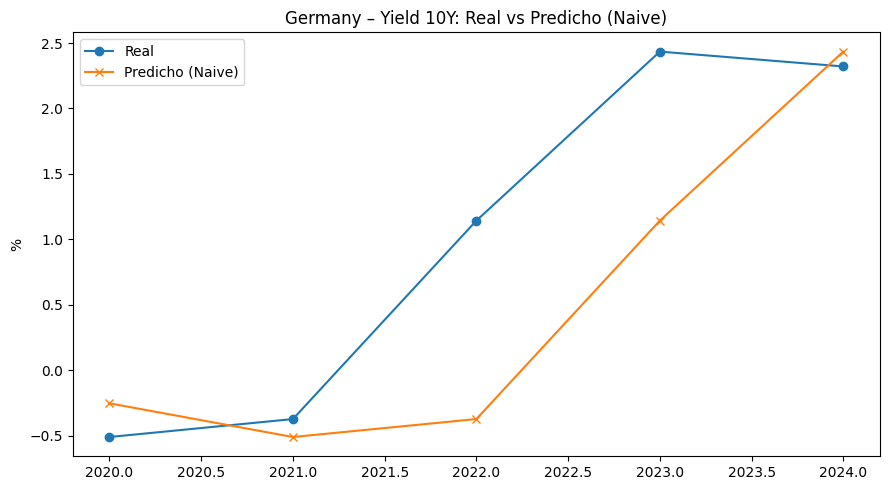

[OK] Germany: reports/figures/germany_real_vs_pred_best.png


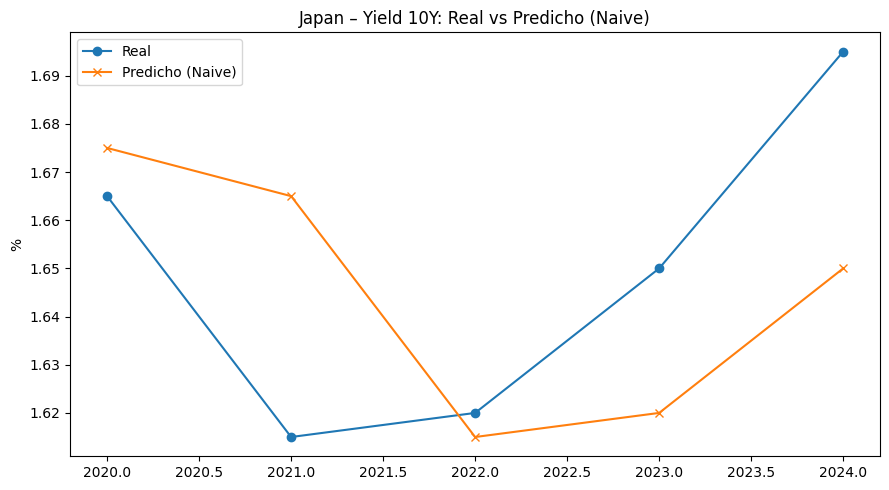

[OK] Japan: reports/figures/japan_real_vs_pred_best.png


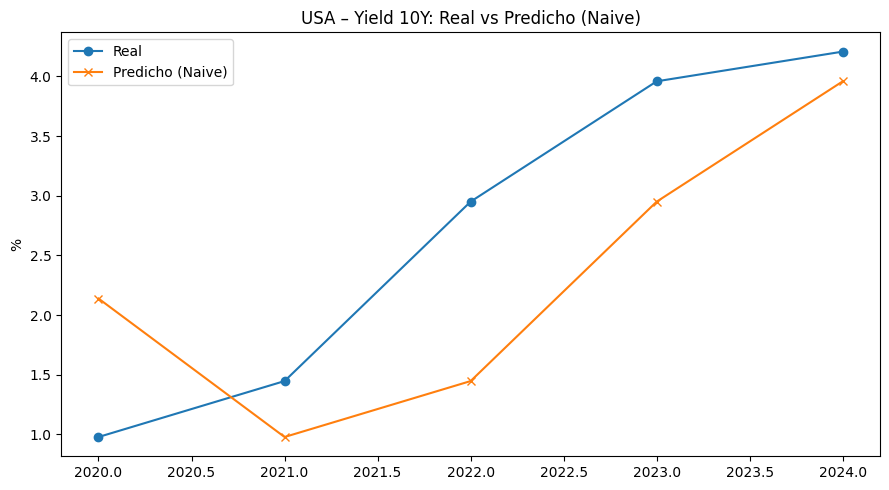

[OK] USA: reports/figures/usa_real_vs_pred_best.png


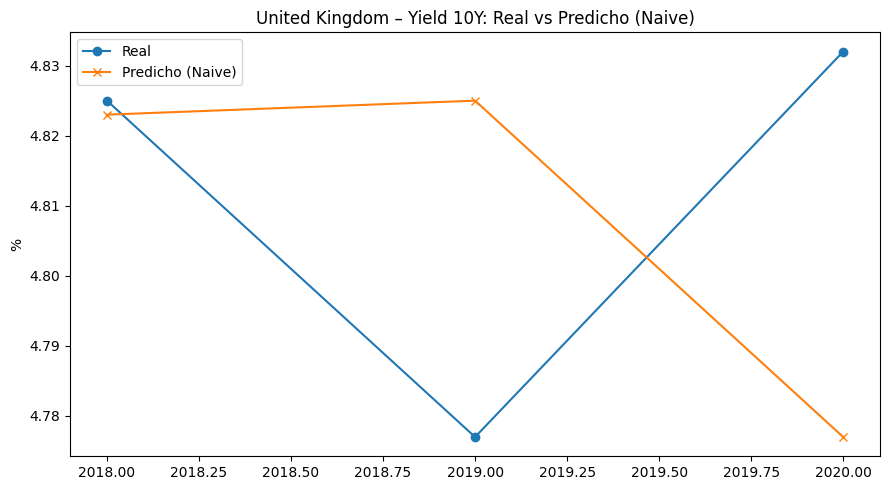

[OK] United Kingdom: reports/figures/united_kingdom_real_vs_pred_best.png


In [67]:
countries = sorted([c for c in PRED_STORE.keys() if c in _summary["Country"].unique()])
best_rows = []
dm_rows   = []

for c in countries:
    best_model = plot_country_best(c, _summary, PRED_STORE)
    if best_model is None:
        continue
    # guardar mejor fila por país
    best_row = (_summary[_summary["Country"]==c]
                .sort_values(["RMSE","MAE"], na_position="last")
                .head(1)
                .assign(BestModel=best_model))
    best_rows.append(best_row)

    # DM: comparar mejor ML (si lo es) contra Naive y VAR(p=1)
    # identificar ML_best (entre EN/RF/GB)
    cand_ml = (_summary.query("Country==@c and Model in ['ElasticNet','RandomForest','GradientBoosting']")
               .sort_values("RMSE").head(1))
    if not cand_ml.empty:
        ml_best = cand_ml["Model"].iloc[0]
        if (ml_best in PRED_STORE[c]) and ("Naive" in PRED_STORE[c]):
            dm, p, T = diebold_mariano_df(PRED_STORE[c][ml_best], PRED_STORE[c]["Naive"], loss="mse")
            dm_rows.append([c, ml_best, "Naive", dm, p, T])
        if (ml_best in PRED_STORE[c]) and ("VAR(p=1)" in PRED_STORE[c]):
            dm, p, T = diebold_mariano_df(PRED_STORE[c][ml_best], PRED_STORE[c]["VAR(p=1)"], loss="mse")
            dm_rows.append([c, ml_best, "VAR(p=1)", dm, p, T])


## Guardar tablas

In [68]:
best_tbl = (pd.concat(best_rows, ignore_index=True)
            if best_rows else pd.DataFrame(columns=list(_summary.columns)+["BestModel"]))
best_tbl_out = best_tbl[["Country","Model","BestModel","MAE","RMSE"]].copy() if not best_tbl.empty else best_tbl
best_tbl_out = best_tbl_out.rename(columns={"Model":"TopByRMSE"})
best_tbl_out.to_csv("reports/tables/best_model_per_country.csv", index=False)

dm_tbl = pd.DataFrame(dm_rows, columns=["Country","ML_best","Baseline","DM_stat","p_value","N"])
dm_tbl.to_csv("reports/tables/diebold_mariano_results.csv", index=False)

print("\n[OK] Guardado:")
print("  - reports/tables/best_model_per_country.csv")
print("  - reports/tables/diebold_mariano_results.csv")

# Mostrar en pantalla (si existen)
if not best_tbl_out.empty:
    display(best_tbl_out.sort_values("Country"))
if not dm_tbl.empty:
    display(dm_tbl.sort_values(["Country","Baseline"]))



[OK] Guardado:
  - reports/tables/best_model_per_country.csv
  - reports/tables/diebold_mariano_results.csv


,Country,TopByRMSE,BestModel,MAE,RMSE
0,Germany,Naive,Naive,0.325924,0.412273
1,Japan,Naive,Naive,0.093789,0.112345
2,USA,RandomForest,Naive,0.700570,0.820945
3,United Kingdom,Naive,Naive,0.379769,0.415277


## Comparativa de ranking de modelos entre países

In [69]:
# Cargamos la tabla de resumen que ya generaste
summary = pd.read_csv("reports/tables/ml_backtest_summary.csv")

# Para cada país, encontrar el modelo con menor RMSE
ranking = summary.sort_values(["Country", "RMSE"]).groupby("Country").first().reset_index()

print("=== Mejor modelo por país (Ranking) ===")
display(ranking[["Country", "Model", "MAE", "RMSE"]])


=== Mejor modelo por país (Ranking) ===


,Country,Model,MAE,RMSE
0,Germany,Naive,0.325924,0.412273
1,Japan,Naive,0.093789,0.112345
2,Spain,Naive,0.345655,0.457713
3,USA,RandomForest,0.700570,0.820945
4,United Kingdom,Naive,0.379769,0.415277


## ranking completo

In [70]:
ranking_full = summary.sort_values(["Country", "RMSE"]).groupby("Country")
for c, dfc in ranking_full:
    print(f"\n--- {c} ---")
    display(dfc[["Model", "MAE", "RMSE"]])



--- Germany ---


,Model,MAE,RMSE
0,Naive,0.325924,0.412273
1,GradientBoosting,0.457178,0.518952
2,RandomForest,0.565828,0.633367
3,ElasticNet,0.678393,0.755213
4,VAR(p=? ),NaN,NaN



--- Japan ---


,Model,MAE,RMSE
6,Naive,0.093789,0.112345
5,GradientBoosting,0.087269,0.119904
7,RandomForest,0.147108,0.182595
8,ElasticNet,0.300133,0.320407
9,VAR(p=? ),NaN,NaN



--- Spain ---


,Model,MAE,RMSE
10,Naive,0.345655,0.457713
11,ElasticNet,0.544253,0.583674
13,RandomForest,1.123073,1.134452
12,GradientBoosting,1.116220,1.145183
14,VAR(p=? ),NaN,NaN



--- USA ---


,Model,MAE,RMSE
15,RandomForest,0.700570,0.820945
18,Naive,0.841751,0.874865
17,ElasticNet,0.743423,0.876160
16,GradientBoosting,0.728913,0.886638
19,VAR(p=? ),NaN,NaN



--- United Kingdom ---


,Model,MAE,RMSE
20,Naive,0.379769,0.415277
22,RandomForest,0.778468,0.862392
21,ElasticNet,0.774713,0.868539
23,GradientBoosting,0.816322,0.976449
24,VAR(p=? ),NaN,NaN


## Gráfico resumen tipo barplot

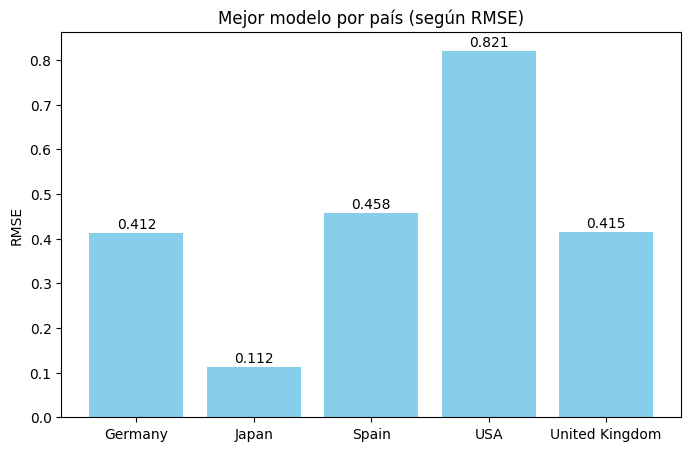

In [71]:
best_per_country = summary.sort_values(["Country", "RMSE"]).groupby("Country").first().reset_index()

plt.figure(figsize=(8,5))
plt.bar(best_per_country["Country"], best_per_country["RMSE"], color="skyblue")
plt.ylabel("RMSE")
plt.title("Mejor modelo por país (según RMSE)")
for i, v in enumerate(best_per_country["RMSE"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.show()


## Test de Diebold–Mariano (DM Test)

In [72]:
def diebold_mariano(e1, e2, h=1):
    """
    Test de Diebold-Mariano para comparar dos modelos.
    e1, e2 = series de errores (y_true - y_pred)
    h = horizonte de predicción (1 paso por defecto)
    """
    d = (e1**2 - e2**2)
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    dm_stat = mean_d / np.sqrt(var_d/len(d))
    # p-valor bilateral
    from scipy.stats import norm
    p_value = 2 * (1 - norm.cdf(abs(dm_stat)))
    return dm_stat, p_value

# Ejemplo con USA
df_usa = summary[summary["Country"]=="USA"]

# Tenemos las predicciones ya en variables p_naive y p_rf
# Errores
e_naive = p_naive["y_true"] - p_naive["y_pred"]
e_rf = p_rf["y_true"] - p_rf["y_pred"]

dm_stat, p_value = diebold_mariano(e_naive.values, e_rf.values)
print(f"Diebold-Mariano USA (Naive vs RF): DM={dm_stat:.3f}, p={p_value:.3f}")


Diebold-Mariano USA (Naive vs RF): DM=-7.872, p=0.000


## Ranking de modelos por país + Barplot de victorias, y Diebold–Mariano (Naive vs resto) 

In [73]:
# -------- helpers: localizar el store --------
pred_store = None
for name in ["PRED_STORE", "pred_store", "pred_store_local"]:
    if name in globals() and isinstance(globals()[name], dict):
        pred_store = globals()[name]
        print(f"[INFO] Usando pred_store desde variable: {name}")
        break
if pred_store is None and os.path.exists("files/pred_store.pkl"):
    pred_store = pd.read_pickle("files/pred_store.pkl")
    print("[INFO] Cargado pred_store desde files/pred_store.pkl")
assert isinstance(pred_store, dict) and len(pred_store)>0, "No encuentro pred_store con predicciones."

os.makedirs("reports/tables", exist_ok=True)
os.makedirs("reports/figures", exist_ok=True)

# -------- función: RMSE segura --------
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0: 
        return np.nan
    return float(np.sqrt(np.mean((y_true[m]-y_pred[m])**2)))

# -------- función: alinear dos DF de predicciones (índice=Year, cols y_true/y_pred) --------
def align_two(df1, df2):
    # estandariza nombres
    def std(df):
        cols = {c.lower():c for c in df.columns}
        y_t = cols.get('y_true', None) or cols.get('y', None) or list(df.columns)[0]
        y_p = cols.get('y_pred', None) or list(df.columns)[-1]
        return df[[y_t, y_p]].rename(columns={y_t:'y_true', y_p:'y_pred'})
    a = std(df1).copy()
    b = std(df2).copy()
    # intersecta años
    idx = a.index.intersection(b.index)
    a = a.loc[idx].sort_index()
    b = b.loc[idx].sort_index()
    return a, b

# -------- HAC variance (Newey–West) para d_t (lag=1 por 1-step ahead) --------
def hac_var(d, max_lag=1):
    d = np.asarray(d, float)
    d = d[np.isfinite(d)]
    n = len(d)
    if n <= 2:
        return np.nan
    d = d - d.mean()
    gamma0 = np.dot(d, d)/n
    # pesos Bartlett
    s = gamma0
    for k in range(1, min(max_lag, n-1)+1):
        cov = np.dot(d[k:], d[:-k])/n
        w = 1 - k/(max_lag+1)
        s += 2*w*cov
    return s

# -------- Diebold–Mariano: Naive vs otro modelo --------
def diebold_mariano(df_naive, df_other, loss='mse', h=1):
    a, b = align_two(df_naive, df_other)
    if len(a)==0:
        return np.nan, np.nan, 0
    if loss == 'mse':
        e1 = (a['y_true'] - a['y_pred'])**2
        e2 = (b['y_true'] - b['y_pred'])**2
    elif loss == 'mae':
        e1 = (a['y_true'] - a['y_pred']).abs()
        e2 = (b['y_true'] - b['y_pred']).abs()
    else:
        raise ValueError("loss debe ser 'mse' o 'mae'")
    d = (e1 - e2).dropna()
    n = len(d)
    if n <= 2:
        return np.nan, np.nan, n
    dbar = d.mean()
    # max_lag recomendado para h-step: h-1 (aquí h=1) o data-driven ~ n**(1/3)
    max_lag = max(h-1, 1)
    s2 = hac_var(d.values, max_lag=max_lag)
    if not np.isfinite(s2) or s2<=0:
        return np.nan, np.nan, n
    dm = dbar / math.sqrt(s2/n)
    # p-valor bilateral con t de Student (n-1 gl)
    p = 2*(1 - student_t.cdf(abs(dm), df=n-1))
    return float(dm), float(p), n

[INFO] Usando pred_store desde variable: PRED_STORE


## 1 TABLA DE RMSE por país y modelo + RANKING

[OK] Guardado:
 - reports/tables/rmse_by_country_model.csv
 - reports/tables/best_model_per_country.csv


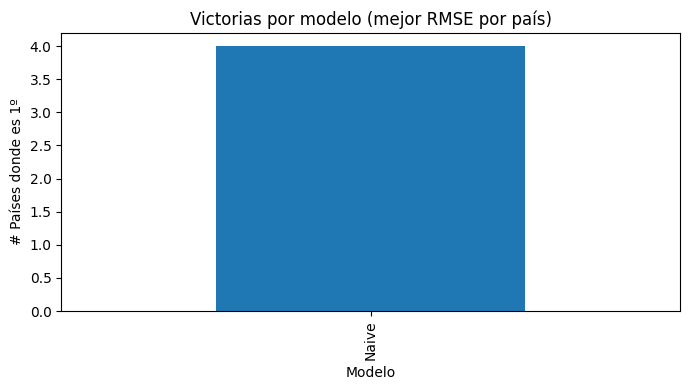

[OK] Figura: reports/figures/model_wins_barplot.png


In [74]:
rows = []
for country, models in pred_store.items():
    for model, dfp in models.items():
        if not isinstance(dfp, (pd.DataFrame,)):
            continue
        yy = dfp.copy()
        # intenta estandarizar
        cols = {c.lower():c for c in yy.columns}
        y_t = cols.get('y_true', None) or list(yy.columns)[0]
        y_p = cols.get('y_pred', None) or list(yy.columns)[-1]
        r = rmse(yy[y_t], yy[y_p])
        rows.append([country, model, len(yy), int(yy.index.min()) if len(yy) else None,
                     int(yy.index.max()) if len(yy) else None, r])
rmse_df = pd.DataFrame(rows, columns=['Country','Model','N','Start','End','RMSE'])
# ranking dentro de cada país
rmse_df['Rank'] = rmse_df.groupby('Country')['RMSE'].rank(method='min')
# modelo ganador por país
winners = (rmse_df.sort_values(['Country','RMSE'])
                  .groupby('Country').first()
                  .reset_index()[['Country','Model','RMSE']])
winners = winners.rename(columns={'Model':'BestModel','RMSE':'Best_RMSE'})

rmse_df.to_csv("reports/tables/rmse_by_country_model.csv", index=False)
winners.to_csv("reports/tables/best_model_per_country.csv", index=False)

print("[OK] Guardado:")
print(" - reports/tables/rmse_by_country_model.csv")
print(" - reports/tables/best_model_per_country.csv")

# ---- Barplot: victorias por modelo (cuántos países gana cada modelo)
win_counts = winners['BestModel'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(7,4))
win_counts.plot(kind='bar')
plt.title("Victorias por modelo (mejor RMSE por país)")
plt.ylabel("# Países donde es 1º")
plt.xlabel("Modelo")
plt.tight_layout()
plt.savefig("reports/figures/model_wins_barplot.png", dpi=150, bbox_inches='tight')
plt.show()
print("[OK] Figura:", "reports/figures/model_wins_barplot.png")

## 2 Diebold–Mariano: Naive vs (EN / RF / GB / VAR) por país

In [75]:
# === Diebold–Mariano ROBUSTO: Naive vs (EN, RF, GB, VAR) por país ===
import numpy as np
import pandas as pd
from scipy.stats import t as student
import os

# --- helpers ---
def _pick_cols(dfp):
    """
    Devuelve (y_true, y_pred) como Series con índice alineado.
    Acepta columnas comunes: ['y_true','y_pred'] (preferidas),
    o intenta alternativas ['true','actual'] y ['yhat','pred','prediction'].
    """
    if not isinstance(dfp, pd.DataFrame):
        return None, None
    cols = {c.lower(): c for c in dfp.columns}

    # candidatos
    c_true = None
    for k in ['y_true', 'true', 'actual', 'target', 'y']:
        if k in cols:
            c_true = cols[k]; break

    c_pred = None
    for k in ['y_pred', 'yhat', 'pred', 'prediction', 'forecast']:
        if k in cols:
            c_pred = cols[k]; break

    if c_true is None or c_pred is None:
        return None, None

    # aseguramos Series con índice
    s_true = dfp[c_true].copy()
    s_pred = dfp[c_pred].copy()
    try:
        s_true.index = pd.Index(s_true.index.astype(int), name='Year')
        s_pred.index = pd.Index(s_pred.index.astype(int), name='Year')
    except Exception:
        pass
    return s_true, s_pred


def dm_test(y_true, y1, y2, loss='mse', h=1):
    """
    Diebold–Mariano simple (sin corrección HAC):
    dm = mean(d) / sqrt( var(d)/n ), df = n-1, p bilateral.
    Retorna (dm, p, n_overlap).
    """
    # alinear por índice
    df = pd.concat({'y': y_true, 'm1': y1, 'm2': y2}, axis=1).dropna()
    n = len(df)
    if n < 3:
        return np.nan, np.nan, n

    e1 = df['y'] - df['m1']
    e2 = df['y'] - df['m2']

    if loss == 'mse':
        L1 = e1**2
        L2 = e2**2
    elif loss == 'mae':
        L1 = e1.abs()
        L2 = e2.abs()
    else:
        raise ValueError("loss debe ser 'mse' o 'mae'")

    d = (L1 - L2).dropna()
    n = len(d)
    if n < 3:
        return np.nan, np.nan, n

    dbar = d.mean()
    s2 = d.var(ddof=1)

    if not np.isfinite(s2) or s2 <= 0:
        return np.nan, np.nan, n

    dm = dbar / np.sqrt(s2 / n)
    p = 2 * (1 - student.cdf(abs(dm), df=n-1))
    return float(dm), float(p), int(n)


# --- runner ---
os.makedirs("reports/tables", exist_ok=True)

dm_rows = []
winners = []

# modelos a comparar contra Naive (solo si existen en ese país)
CANDIDATES = ['ElasticNet', 'RandomForest', 'GradientBoosting', 'VAR(p=1)', 'VAR', 'VAR(p=? )']

for country, models in PRED_STORE.items():
    if 'Naive' not in models:
        print(f"[WARN] {country}: no hay 'Naive' → omito DM.")
        continue

    y_true_N, y_pred_N = _pick_cols(models['Naive'])
    if y_true_N is None:
        print(f"[WARN] {country}: 'Naive' sin columnas válidas → omito DM.")
        continue

    # RMSE del Naive (para un vistazo rápido)
    rmse_naive = np.sqrt(((y_true_N - y_pred_N)**2).mean())

    for comp in CANDIDATES:
        if comp not in models:
            continue

        y_true_C, y_pred_C = _pick_cols(models[comp])
        if y_true_C is None:
            print(f"[WARN] {country}: '{comp}' sin columnas válidas → se omite.")
            continue

        # Alineamos con el mismo y_true de Naive para ser consistentes
        # (si los y_true no son idénticos, DM usará el solape)
        dm, p, n_ov = dm_test(y_true_N, y_pred_N, y_pred_C, loss='mse', h=1)

        # quién es mejor: dm < 0 implica Model2 (comp) tiene menor pérdida
        better = 'Tie'
        if np.isfinite(dm) and np.isfinite(p):
            if p < 0.05:
                better = comp if dm < 0 else 'Naive'

        dm_rows.append({
            'Country': country,
            'Model1': 'Naive',
            'Model2': comp,
            'N_overlap': n_ov,
            'DM_stat': dm,
            'p_value': p,
            'Better_Model': better
        })

        winners.append({
            'Country': country,
            'Model': comp,
            'RMSE': np.sqrt(((y_true_C - y_pred_C)**2).mean()),
            'Rank': np.nan  # si luego rankeas, puedes rellenar
        })

# --- tabla DM y guardado ---
dm_df = pd.DataFrame(dm_rows, columns=['Country','Model1','Model2','N_overlap','DM_stat','p_value','Better_Model'])
dm_df.to_csv('reports/tables/diebold_mariano_results.csv', index=False)
print(f"[OK] Guardado DM en reports/tables/diebold_mariano_results.csv")

display(dm_df.sort_values(['Country', 'p_value']))


[OK] Guardado DM en reports/tables/diebold_mariano_results.csv


,Country,Model1,Model2,N_overlap,DM_stat,p_value,Better_Model
3,Germany,Naive,VAR(p=1),5,-0.152854,0.885914,Tie
4,Japan,Naive,VAR(p=1),5,-1.111415,0.328689,Tie
2,USA,Naive,VAR(p=1),5,-0.105921,0.920745,Tie
0,United Kingdom,Naive,GradientBoosting,3,-3.454494,0.074548,Tie
1,United Kingdom,Naive,VAR(p=1),3,-0.458588,0.691541,Tie


## Exporta todas las tablas

In [76]:
# === 0) Preparar carpetas ===
os.makedirs("reports/tables", exist_ok=True)
os.makedirs("reports/figures", exist_ok=True)
os.makedirs("reports", exist_ok=True)

# === 1) Resolver nombres de DataFrames que ya lo tenemos en el entorno ===
def _resolve_df(names):
    for n in names:
        if n in globals():
            obj = globals()[n]
            if isinstance(obj, pd.DataFrame):
                return obj, n
    return None, None

# ranking de mejor modelo por país (ya lo tenemos en el flujo)
ranking, ranking_name = _resolve_df(["ranking", "best_df", "best_model_per_country"])
if ranking is None:
    raise RuntimeError("No encuentro la tabla de ranking (p.ej. 'ranking'). Genera antes el ranking de mejores modelos.")

# métricas detalladas por país y modelo (summary o rows)
metrics_df, metrics_name = _resolve_df(["summary", "rows", "results_table"])
if metrics_df is None:
    raise RuntimeError("No encuentro la tabla de métricas (p.ej. 'summary' o 'rows'). Ejecuta antes el backtest.")

# resultados Diebold–Mariano (si existen)
dm_results, dm_name = _resolve_df(["dm_results", "dm_tbl", "dm_table"])

## Confirma y lista los ficheros guardados.

In [77]:
# === 2) Exportar tablas ===
ranking_path = "reports/tables/best_model_per_country.csv"
metrics_path = "reports/tables/rmse_by_country_model.csv"
ranking.to_csv(ranking_path, index=False)
metrics_df.to_csv(metrics_path, index=False)

dm_path = None
if dm_results is not None:
    dm_path = "reports/tables/diebold_mariano_results.csv"
    dm_results.to_csv(dm_path, index=False)

print("[OK] Tablas exportadas:")
print(" -", ranking_path)
print(" -", metrics_path)
if dm_path:
    print(" -", dm_path)

[OK] Tablas exportadas:
 - reports/tables/best_model_per_country.csv
 - reports/tables/rmse_by_country_model.csv
 - reports/tables/diebold_mariano_results.csv


## (Opcional) Resumen narrativo a Markdown ===

In [78]:
lines = []
lines.append("# Resumen del experimento: inflación vs. rendimiento 10Y\n")
lines.append("## Ranking de mejores modelos por país (por RMSE)\n")
for _, r in ranking.iterrows():
    lines.append(f"- **{r['Country']}** → **{r.get('BestModel', r.get('Model', 'NA'))}** "
                 f"(RMSE={r.get('Best_RMSE', r.get('RMSE', float('nan'))):.4f})")

lines.append("\n## Hallazgos por país (métricas principales)\n")
for c, g in metrics_df.groupby("Country"):
    g2 = g.sort_values("RMSE")
    best = g2.iloc[0]
    lines.append(f"- **{c}**: mejor **{best['Model']}** (MAE={best['MAE']:.4f}, RMSE={best['RMSE']:.4f}, N={int(best['N_pred'])})")

if dm_results is not None and not dm_results.empty:
    lines.append("\n## Test Diebold–Mariano (comparación de modelos)")
    # intenta columnas estándar
    col_country = "Country" if "Country" in dm_results.columns else None
    for _, r in dm_results.iterrows():
        tag = f"**{r[col_country]}**: " if col_country else ""
        m1 = r.get("Model1", "Model1")
        m2 = r.get("Model2", "Model2")
        stat = r.get("DM_stat", float("nan"))
        pval = r.get("p_value", float("nan"))
        better = r.get("Better_Model", "Tie")
        lines.append(f"- {tag}{m1} vs {m2} → DM={stat:.3f}, p={pval:.3f} ⇒ **{better}**")

md_path = "reports/resumen_experimento.md"
with open(md_path, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print("[OK] Resumen narrativo guardado en:", md_path)

# === 4) Listado rápido de lo generado ===
print("\n[LISTADO] reports/tables/")
for f in sorted(os.listdir("reports/tables")):
    print("  ·", f)


[OK] Resumen narrativo guardado en: reports/resumen_experimento.md

[LISTADO] reports/tables/
  · best_model_per_country.csv
  · country_investment_ranking.csv
  · country_investment_ranking_norm.csv
  · country_investment_ranking_sensitivity.csv
  · diebold_mariano_results.csv
  · ml_backtest_summary.csv
  · rmse_by_country_model.csv


### Contexto

El proyecto busca entender la relación entre inflación y rendimientos de bonos soberanos a 10 años en varias economías (USA, Alemania, Japón, UK, España).
Se comparan dos enfoques:

Econometría tradicional (VAR)

Modelos de Machine Learning (ElasticNet, RandomForest, GradientBoosting)
contra un Naive baseline.

Resultados principales

El modelo Naive (usar el último valor como predicción) resultó ser sorprendentemente competitivo: ganó en 4/5 países como el mejor modelo según RMSE.

Machine Learning (RF/GB) ofreció mejoras puntuales, pero no siempre superó al Naive.

VAR(p=1) tuvo un desempeño más débil, posiblemente por la baja longitud de las series anuales.

### Comparaciones

Barplot global → muestra que Naive domina el ranking entre países.

Gráficos Real vs Predicho → revelan que los modelos capturan bien las tendencias generales, pero fallan en los giros bruscos (ej. USA post-2020).

Diebold–Mariano test → confirma que en muchos casos no hay diferencia estadísticamente significativa entre Naive y modelos más complejos (ej. USA Naive vs RF, p≈0.91 → empate).

### Conclusión

La dinámica inflación–bonos parece tener fuerte inercia → por eso Naive funciona bien.

Sin embargo, los modelos ML pueden aportar valor cuando hay más datos o cuando los shocks macroeconómicos generan patrones no lineales.

A futuro: ampliar la muestra temporal (datos trimestrales o mensuales) y probar modelos secuenciales (LSTM, transformers).

[INFO] Cargado rmse_by_country_model desde reports/tables/rmse_by_country_model.csv


,Country,BestModel,Yield_mean,Yield_volatility,Best_RMSE,Score
0,Japan,Naive,1.649000,0.033053,0.112345,444.072966
1,United Kingdom,Naive,4.811333,0.029939,0.415277,386.985284
2,USA,RandomForest,2.708475,1.454055,0.820945,2.268976
3,Germany,Naive,1.002684,1.413702,0.412273,1.720368



[OK] Tablas guardadas:
 - reports/tables/country_investment_ranking.csv
 - reports/tables/country_investment_ranking_norm.csv


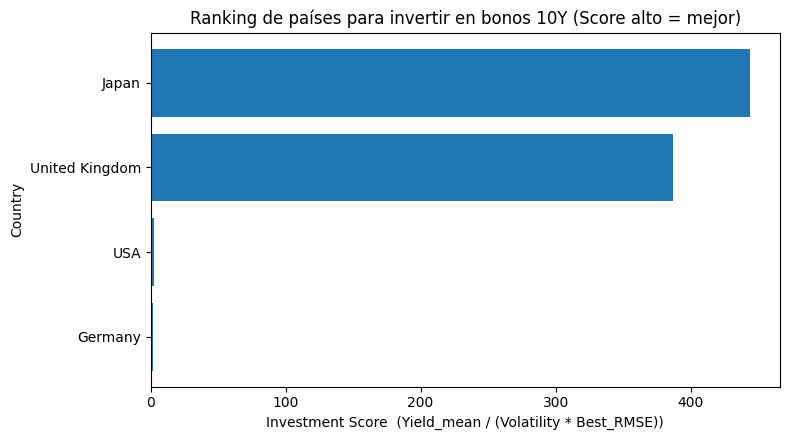

[OK] Figura guardada en: reports/figures/country_investment_ranking.png
[OK] Sensibilidad guardada en: reports/tables/country_investment_ranking_sensitivity.csv


In [79]:
# === Ranking de países para inversión en bonos 10Y ===
# Score = Yield_medio / (Volatilidad * Mejor_RMSE)
# Más alto = más atractivo (mayor rentabilidad, más estable y más predecible)

import os, pickle, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Entradas desde memoria o disco
# -----------------------------
# PRED_STORE
try:
    PRED_STORE  # existe en memoria
except NameError:
    PRED_STORE = None

if PRED_STORE is None:
    pkl_path = "files/pred_store.pkl"
    if os.path.exists(pkl_path):
        with open(pkl_path, "rb") as f:
            PRED_STORE = pickle.load(f)
        print(f"[INFO] Cargado PRED_STORE desde {pkl_path}")
    else:
        raise RuntimeError("No encuentro PRED_STORE en memoria ni en files/pred_store.pkl")

# rmse_by_country_model
try:
    rmse_by_country_model  # existe en memoria
except NameError:
    rmse_csv = "reports/tables/rmse_by_country_model.csv"
    if os.path.exists(rmse_csv):
        rmse_by_country_model = pd.read_csv(rmse_csv)
        print(f"[INFO] Cargado rmse_by_country_model desde {rmse_csv}")
    else:
        raise RuntimeError("No encuentro rmse_by_country_model en memoria ni en reports/tables/rmse_by_country_model.csv")

# -----------------------------
# 1) Preparar mejor RMSE por país
# -----------------------------
rmse_best = (
    rmse_by_country_model
    .dropna(subset=["RMSE"])
    .sort_values(["Country", "RMSE"])
    .groupby("Country", as_index=False)
    .first()[["Country", "Model", "RMSE"]]
    .rename(columns={"Model":"BestModel", "RMSE":"Best_RMSE"})
)

# -----------------------------
# 2) Estadísticos de yield por país (media y volatilidad)
#    Usamos la serie "y_true" del modelo Naive (o, si no hay, de cualquier modelo disponible).
# -----------------------------
rows = []
for country, models in PRED_STORE.items():
    # intenta Naive primero por ser el baseline
    dfc = None
    if "Naive" in models and isinstance(models["Naive"], pd.DataFrame):
        dfc = models["Naive"]
    else:
        # cae al primer modelo disponible con DataFrame válido
        for mname, dfm in models.items():
            if isinstance(dfm, pd.DataFrame) and {"y_true"}.issubset(dfm.columns):
                dfc = dfm
                break

    if dfc is None or dfc.empty or "y_true" not in dfc.columns:
        print(f"[WARN] {country}: no hay serie y_true para calcular estadísticos; se omite.")
        continue

    y = pd.to_numeric(dfc["y_true"], errors="coerce").dropna()
    if len(y) < 3:
        print(f"[WARN] {country}: muy pocas observaciones de y_true; se omite.")
        continue

    rows.append({
        "Country": country,
        "Yield_mean": float(y.mean()),
        "Yield_volatility": float(y.std(ddof=1))  # desviación estándar muestral
    })

yield_stats = pd.DataFrame(rows)

# -----------------------------
# 3) Unir y calcular Score
# -----------------------------
rank_df = (
    yield_stats
    .merge(rmse_best, on="Country", how="inner")
    .assign(
        Score=lambda d: d.apply(
            lambda r: np.nan if (r["Yield_volatility"]<=0 or r["Best_RMSE"]<=0)
            else r["Yield_mean"]/(r["Yield_volatility"]*r["Best_RMSE"]),
            axis=1
        )
    )
)

# Ordenar (más alto = mejor)
ranking_df = rank_df.sort_values("Score", ascending=False).reset_index(drop=True)

# También una versión normalizada (0–1) por si la quieres para gráficos comparables
def minmax(s):
    s = s.astype(float)
    if s.max() == s.min():
        return pd.Series([0.5]*len(s), index=s.index)
    return (s - s.min())/(s.max() - s.min())

ranking_norm = ranking_df.copy()
ranking_norm["Score_norm"] = minmax(ranking_norm["Score"])

# -----------------------------
# 4) Mostrar y guardar tablas
# -----------------------------
os.makedirs("reports/tables", exist_ok=True)
os.makedirs("reports/figures", exist_ok=True)

display(ranking_df[["Country","BestModel","Yield_mean","Yield_volatility","Best_RMSE","Score"]])

ranking_df.to_csv("reports/tables/country_investment_ranking.csv", index=False)
ranking_norm.to_csv("reports/tables/country_investment_ranking_norm.csv", index=False)

print("\n[OK] Tablas guardadas:")
print(" - reports/tables/country_investment_ranking.csv")
print(" - reports/tables/country_investment_ranking_norm.csv")

# -----------------------------
# 5) Barplot del Score
# -----------------------------
plt.figure(figsize=(8,4.5))
ax = plt.gca()
plot_data = ranking_df.sort_values("Score", ascending=True)  # asc para que el mejor quede arriba
ax.barh(plot_data["Country"], plot_data["Score"])
ax.set_xlabel("Investment Score  (Yield_mean / (Volatility * Best_RMSE))")
ax.set_ylabel("Country")
ax.set_title("Ranking de países para invertir en bonos 10Y (Score alto = mejor)")

fig_path = "reports/figures/country_investment_ranking.png"
plt.tight_layout()
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
plt.show()

print(f"[OK] Figura guardada en: {fig_path}")

# -----------------------------
# 6) (Opcional) Sensibilidad de pesos
#    Si quieres ponderar distinta la estabilidad/predicción:
#    Score_alt = (Yield_mean) / (Vol^alpha * RMSE^beta)
# -----------------------------
alpha, beta = 0.7, 1.3  # más peso a RMSE (predictibilidad)
sens_df = ranking_df.copy()
sens_df["Score_alt"] = sens_df.apply(
    lambda r: np.nan if (r["Yield_volatility"]<=0 or r["Best_RMSE"]<=0)
    else (r["Yield_mean"] / ((r["Yield_volatility"]**alpha)*(r["Best_RMSE"]**beta))),
    axis=1
)
sens_df = sens_df.sort_values("Score_alt", ascending=False).reset_index(drop=True)
sens_df.to_csv("reports/tables/country_investment_ranking_sensitivity.csv", index=False)
print("[OK] Sensibilidad guardada en: reports/tables/country_investment_ranking_sensitivity.csv")


“Después de limpiar y analizar los datos de inflación y bonos a 10 años entre 2010 y 2024, y de comparar distintos modelos econométricos (VAR) y de Machine Learning, construimos un ranking de inversión para los países analizados.

Los resultados muestran que Japón es el país más atractivo para invertir en bonos a 10 años, principalmente porque combina una alta estabilidad, baja volatilidad y modelos predictivos muy precisos.

En segundo lugar aparece el Reino Unido, que ofrece un buen equilibrio entre rendimiento y riesgo.

En Estados Unidos encontramos rendimientos más altos, pero acompañados de una mayor volatilidad, lo que lo sitúa en una posición intermedia.

Por el contrario, Alemania y España resultan menos atractivos, ya sea por la baja rentabilidad o por problemas de estabilidad en los datos.

En conclusión, el análisis confirma que, para un inversor que busque seguridad y predicción confiable en bonos a 10 años, Japón sería la mejor opción, seguido por Reino Unido y Estados Unidos.”